In [1]:
import os
import importlib
import time

import numpy as np
import pandas as pd

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import skimage
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
#from torchvision import transforms
from torch.utils import data
from torch.utils.data.sampler import SubsetRandomSampler

import load_data
import model
#import first_exp_model_with_pytorch as dloader
#import first_exp_model_with_pytorch

In [2]:
plt.style.use('Solarize_Light2')
%matplotlib inline
importlib.reload(load_data)
importlib.reload(model)

<module 'model' from '/home/uldo/work/kaggle/competitions/Human_Protein_Atlas_Image_Classification/code/model.py'>

In [3]:
W = H = 256

BATCH_SIZE = 100

LABEL_NAMES_MAP = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

In [4]:
def show(image, labels):
    f, (ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(25,25), sharey=True)

    title = ''
    #npimage = image.numpy()[:, ::-1, :, :]
    #print(image.size())
    #print(labels)
    #print(labels.size())
    #print(image)
    npimage = image.numpy()
    nplabels = labels.numpy()
    print(npimage.shape)
    print(nplabels)
    #transposed_npimage = np.transpose(npimage, (1, 2, 0))
    
    #print(transposed_npimage.shape)
    
    #labels =sample['target']
                
    #for i, label in enumerate(LABELS):
    #    if labels[i] == 1:
    #        if title == '':
    #            title += label
    #        else:
    #            title += " & " + label
    
    #for i, label in enumerate(nplabels[0]):
    for i, label in enumerate(nplabels):
        if label == 1:
            if title == '':
                title += LABEL_NAMES_MAP[i]
            else:
                title += " & " + LABEL_NAMES_MAP[i]
    
    ax1.imshow(npimage[0,:,:],cmap="hot")
    ax1.set_title('Red')
    ax2.imshow(npimage[1,:,:],cmap="copper")
    ax2.set_title('Green')
    ax3.imshow(npimage[2,:,:],cmap="bone")
    ax3.set_title('Blue')
    ax4.imshow(npimage[3,:,:],cmap="afmhot")
    ax4.set_title('Yellow')
    f.suptitle(title, fontsize=20, y=0.62)
    

In [5]:
class HPA_ConvNeuralNet(nn.Module):
    
    def __init__(self):
        super(HPA_ConvNeuralNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(4, 8, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.drop_out = nn.Dropout()
        self.out1 = nn.Linear(int(16 * W/4 * H/4), 900)
        self.out2 = nn.Linear(900, 28)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.drop_out(x)
        output = self.out1(x)
        output = self.out2(output)
        #return output, x
        return output

In [6]:
def prepare_loaders(dataset, valid_train_ratio=0.6):
    dataset_size = len(dataset)
    print("dataset_size: ", dataset_size)
    #train_subset_size = int(valid_train_ratio * dataset_size)
    validation_subset_size = int(dataset_size * (1 - valid_train_ratio))
    print("validation_subset_size: ", validation_subset_size)

    indices = list(range(dataset_size))
    validation_indices = np.random.choice(indices, size=validation_subset_size, replace=False)
    train_indices = list(set(indices) - set(validation_indices))

    train_sampler = SubsetRandomSampler(train_indices)
    validation_sampler = SubsetRandomSampler(validation_indices)
    
    dataset_sizes = {
            'train': len(train_indices),
            'validation': len(validation_indices)
        }

    train_loader = data.DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=1, sampler=train_sampler)
    validation_loader = data.DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=1, sampler=validation_sampler)

    loaders = {
            'train': train_loader,
            'validation': validation_loader
        }

    return loaders, dataset_sizes

In [42]:
def validate(model, validation_loader, validation_dataset_size):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        #i = 0
        for images, labels in validation_loader:
            images = images.to(device, dtype=torch.float)
            print("images.size(): ", images.size())
            
            labels = labels.to(device, dtype=torch.uint8)
            
            print("labels.size(): ", labels.size())
            print("labels:\n", labels)
            print("labels.dtype: ", labels.dtype)
            outputs = model(images)
            #outputs = model(images)[0]
            print("outputs.size(): ", outputs.size())
            print("outputs:\n", outputs)
            print("outputs.data:\n", outputs.data)
            #_, predicted = torch.max(outputs.data, 1)
            #pred, predicted = torch.max(outputs.data, 1)
            predicted = outputs > 0
            #predicted = outputs.to(device, dtype=torch.int64)
            #predicted = outputs.to(device, dtype=torch.uint8)
            print("predicted.size(): ", predicted.size())
            print("predicted:\n", predicted)
            #print("predicted.size(): ", predicted.size())
            #print("pred:\n", pred)
            total += labels.size(0)
            print("labels.sum(): ", labels.sum())
            print("predicted.sum():", predicted.sum())
            print("predicted == labels:\n", predicted == labels)
            print("(predicted == labels).all(1):\n", (predicted == labels).all(1))
            print("\ntorch.sum((predicted == labels).all(1)): ", torch.sum((predicted == labels).all(1)))
            print("((predicted == labels).all(1)).sum(): ", ((predicted == labels).all(1)).sum())
            #correct += torch.sum((predicted == labels).all(1))
            correct += ((predicted == labels).all(1)).sum()[0]
            #i += 1
            #if i == 10:
            #    break
        accuracy = correct * 1.0 / total
        print(
                "Validation accuracy of the model on the {} validation images: {} ".format(
                    validation_dataset_size,
                    accuracy
                )
            )

    return accuracy

In [8]:
train_df = load_data.load_text_data('../input/train.csv')

In [9]:
print(train_df.shape)

(31072, 2)


In [10]:
dataset = load_data.HumanProteinAtlasDataset(
    train_df,
    transform=load_data.transforms.ToTensor()
)

In [11]:
dataset_loaders, dataset_sizes = prepare_loaders(dataset)

dataset_size:  31072
validation_subset_size:  12428


In [12]:
#train_loader = dloader.data.DataLoader(dataset, batch_size=10, shuffle=True, num_workers=1)
#train_loader = load_data.data.DataLoader(train_dataset, batch_size=40, shuffle=True, num_workers=1)
train_loader = dataset_loaders['train']
validation_loader = dataset_loaders['validation']
train_dataset_size = dataset_sizes['train']
validation_dataset_size = dataset_sizes['validation']

In [13]:
print(train_dataset_size)
print(validation_dataset_size)

18644
12428


In [14]:
print(train_loader)

In [15]:
train_iter = iter(train_loader)

In [16]:
print(type(train_iter))

<class 'torch.utils.data.dataloader._DataLoaderIter'>


In [17]:
images, labels = train_iter.next()

In [18]:
print("images shape on batch size = {}".format(images.size()))
print("labels shape on batch size = {}".format(labels.size()))

images shape on batch size = torch.Size([100, 4, 256, 256])
labels shape on batch size = torch.Size([100, 28])


In [19]:
#import torchvision

In [20]:
#grid = torchvision.utils.make_grid(images)
#grid = torchvision.utils.make_grid([image[0] for image in images])

In [21]:
#plt.imshow(grid)
#plt.axis('off')
#plt.title(labels.numpy())

(4, 256, 256)
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


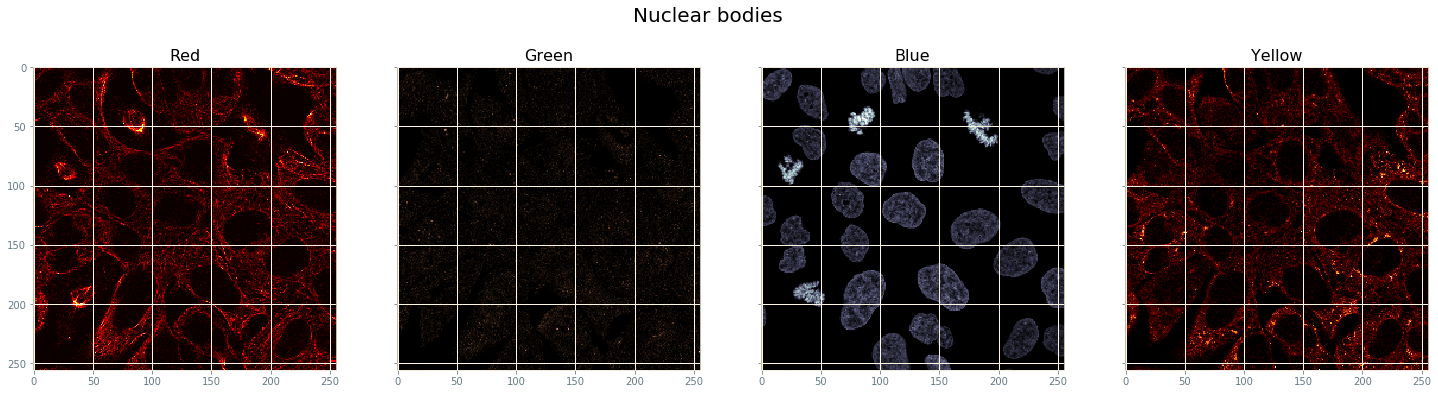

In [22]:
show(images[0], labels[0])

In [23]:
hpa_conv_neural_net = HPA_ConvNeuralNet()

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
print(device)

cuda:0


In [26]:
hpa_conv_neural_net.to(device)

HPA_ConvNeuralNet(
  (conv1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5)
  (out1): Linear(in_features=65536, out_features=900, bias=True)
  (out2): Linear(in_features=900, out_features=28, bias=True)
)

In [27]:
#criterion = nn.CrossEntropyLoss()
criterion=nn.BCEWithLogitsLoss(reduction='sum')
#optimizer = optim.SGD(hpa_conv_neural_net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(hpa_conv_neural_net.parameters(), lr=0.001, betas=(0.9, 0.99))

In [28]:
torch.cuda.empty_cache()
since = time.time()
for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data
        inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
        print("inputs.size(): ", inputs.size())
        print("inputs:\n", inputs)
        #labels = labels[0]
        print("labels.size(): ", labels.size())
        print("labels: ", labels)
        optimizer.zero_grad()
        
        outputs = hpa_conv_neural_net(inputs)
        print("type(outputs): ", type(outputs))
        print("outputs.size(): ", outputs.size())
        print("outputs:\n", outputs)
        #loss = criterion(outputs, labels.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 200 == 199:
            print("[%d, %5d, loss: %.3f]" % (epoch + 1, i + 1, running_loss / 20.0))
            running_loss = 0.0
            
print("Finished Training")
time_elapsed = time.time() - since
print(
    'Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60
    )
)

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

type(outputs):  <class 'torch.Tensor'>
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.0447,  0.0066,  0.0128,  ...,  0.0415, -0.0077, -0.0155],
        [ 0.0410, -0.0078,  0.0171,  ...,  0.0381, -0.0001,  0.0043],
        [ 0.0361, -0.0078,  0.0186,  ...,  0.0337, -0.0068, -0.0084],
        ...,
        [ 0.0339, -0.0005,  0.0113,  ...,  0.0446, -0.0033, -0.0068],
        [ 0.0236, -0.0072,  0.0005,  ...,  0.0397, -0.0051, -0.0114],
        [ 0.0271, -0.0027,  0.0157,  ...,  0.0256, -0.0117, -0.0135]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)
inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0078,  ..., 0.0117, 0.0938, 0.0547],
          [0.0000, 0.0078, 0.0000,  ..., 0.0586, 0.0664, 0.0352],
          [0.0000, 0.0000, 0.0000,  ..., 0.1641, 0.0469, 0.0352],
          ...,
          [0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0117],
          [0.0000, 0.0000, 0.0273,  ..., 0.0078, 0.0000, 0.0000],
          [0.0000, 0.0000,

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.6406, 0.4492, 0.0703,  ..., 0.0117, 0.0742, 0.0078],
          [0.2266, 0.4844, 0.6289,  ..., 0.1289, 0.0586, 0.0859],
          [0.0781, 0.1641, 0.2578,  ..., 0.0039, 0.0508, 0.0273],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0078, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.1602, 0.2148, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          [0.2305, 0.1406, 0.4297,  ..., 0.0156, 0.0117, 0.0039],
          [0.2461, 0.1250, 0.2305,  ..., 0.0000, 0.0000, 0.0391],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0156, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0078, 0.0820, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0508, 0.0391,  ..., 0.0000, 0.0117, 0.0000],
          [0.0117, 0.0625, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0352, 0.0352, 0.0195],
          [0.0000, 0.0000, 0.0000,  ..., 0.0742, 0.0195, 0.0117],
          [0.0000, 0.0039, 0.0000,  ..., 0.1172, 0.0469, 0.0391]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0156, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0781, 0.0078, 0.0430],
          [0.0000, 0.0000, 0.0000,  ..., 0.0508, 0.0117, 0.0273],
          [0.0000, 0.0078, 0.0000,  ..., 0.0273, 0.0430, 0.0664]],

         [[0.0039, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1758, 0.1602, 0.0391,  ..., 0.1680, 0.3359, 0.1758],
          [0.2188, 0.3945, 0.1289,  ..., 0.9102, 0.1094, 0.4062],
          [0.6602, 0.4453, 0.4414,  ..., 0.3047, 0.1484, 0.1914],
          ...,
          [0.0391, 0.0195, 0.0586,  ..., 0.3477, 0.3398, 0.3086],
          [0.0430, 0.0195, 0.0430,  ..., 0.2227, 0.2422, 0.1914],
          [0.0938, 0.1406, 0.0859,  ..., 0.2188, 0.3438, 0.1992]],

         [[0.0742, 0.0586, 0.0156,  ..., 0.0469, 0.2031, 0.0039],
          [0.1562, 0.0312, 0.0547,  ..., 0.0586, 0.1367, 0.0039],
          [0.0039, 0.0273, 0.2188,  ..., 0.0625, 0.0078, 0.1055],
          ...,
          [0.0000, 0.0352, 0.0078,  ..., 0.0977, 0.0430, 0.0430],
          [0.0195, 0.0234, 0.0000,  ..., 0.1016, 0.0000, 0.0352],
          [0.0312, 0.0000, 0.0586,  ..., 0.1758, 0.1172, 0.2422]],

         [[0.0664, 0.1992, 0.2344,  ..., 0.0000, 0.0000, 0.0039],
          [0.0156, 0.1016, 0.3594,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0664, 0.0625,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0195, 0.0430,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0078, 0.0000, 0.0000,  ..., 0.1523, 0.0820, 0.0938],
          [0.0000, 0.0117, 0.0000,  ..., 0.1211, 0.1328, 0.0938],
          [0.0000, 0.0117, 0.0000,  ..., 0.1055, 0.0625, 0.1602]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0195, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0781, 0.0000, 0.0078]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1172, 0.0820, 0.0664,  ..., 0.0078, 0.2773, 0.2617],
          [0.0469, 0.0586, 0.0547,  ..., 0.0039, 0.0508, 0.1133],
          [0.1484, 0.0898, 0.1328,  ..., 0.0039, 0.0195, 0.3281],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.1523, 0.0156, 0.0273,  ..., 0.0195, 0.0000, 0.0000],
          [0.2031, 0.1016, 0.0234,  ..., 0.0117, 0.0195, 0.0117],
          [0.0742, 0.0078, 0.0586,  ..., 0.0117, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0117, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0117,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.1016, 0.0547, 0.0273],
          [0.0000, 0.0039, 0.0000,  ..., 0.0156, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0312, 0.0352],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.4219, 0.4062, 0.1992],
          [0.0000, 0.0000, 0.0000,  ..., 0.1328, 0.2422, 0.4414],
          [0.0000, 0.0000, 0.0000,  ..., 0.2578, 0.1719, 0.3164]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0078, 0.0273],
          [0.0000, 0.0000, 0.0000,  ..., 0.1328, 0.0781, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.1055, 0.0469, 0.0469],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1836, 0.2539, 0.0859],
          [0.0000, 0.0000, 0.0000,  ..., 0.6914, 0.3047, 0.4180],
          [0.0000, 0.0000, 0.0000,  ..., 0.2930, 0.8516, 0.1602]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1328, 0.0938, 0.1016,  ..., 0.0000, 0.0000, 0.0000],
          [0.0703, 0.0977, 0.0781,  ..., 0.0000, 0.0000, 0.0000],
          [0.1641, 0.0898, 0.0977,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.9961, 0.9961, 0.9961,  ..., 0.0078, 0.0195, 0.0000],
          [0.8750, 0.9961, 0.9961,  ..., 0.0156, 0.0234, 0.0000],
          [0.5859, 0.9961, 0.9961,  ..., 0.0234, 0.0000, 0.0000]],

         [[0.0234, 0.0352, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1055, 0.0469, 0.1289,  ..., 0.0000, 0.0000, 0.0000],
          [0.1406, 0.1172, 0.1406,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0859, 0.0859, 0.0469,  ..., 0.0078, 0.0156, 0.0039],
          [0.0117, 0.1406, 0.0703,  ..., 0.0039, 0.0000, 0.0078],
          [0.0273, 0.0586, 0.1484,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.2773, 0.1250, 0.0586],
          [0.0000, 0.0000, 0.0000,  ..., 0.0742, 0.2070, 0.0977],
          [0.0000, 0.0000, 0.0000,  ..., 0.2188, 0.1250, 0.0977],
          ...,
          [0.4180, 0.0430, 0.2773,  ..., 0.0039, 0.0352, 0.0000],
          [0.5430, 0.0508, 0.0781,  ..., 0.0117, 0.0977, 0.0625],
          [0.4766, 0.1992, 0.0547,  ..., 0.0078, 0.0352, 0.2266]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0156, 0.0000],
          ...,
          [0.0547, 0.1445, 0.0625,  ..., 0.0000, 0.0156, 0.0000],
          [0.0117, 0.0312, 0.2109,  ..., 0.0000, 0.0156, 0.0000],
          [0.0625, 0.0781, 0.1914,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0195],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0117],
          ...,
          [0.4453, 0.3047, 0.3008,  ..., 0.0039, 0.0039, 0.0000],
          [0.2578, 0.1797, 0.1914,  ..., 0.0039, 0.0117, 0.0234],
          [0.5547, 0.3789, 0.2500,  ..., 0.0000, 0.0312, 0.0117]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0508, 0.0391],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0586, 0.0742],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0742, 0.0273],
          ...,
          [0.1211, 0.0508, 0.0742,  ..., 0.0000, 0.0078, 0.0039],
          [0.0273, 0.0078, 0.0508,  ..., 0.0078, 0.0195, 0.0078],
          [0.0273, 0.0156, 0.1914,  ..., 0.0273, 0.0039, 0.0117]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1602, 0.2852, 0.1797,  ..., 0.0000, 0.0000, 0.0000],
          [0.1367, 0.2500, 0.2266,  ..., 0.0000, 0.0000, 0.0000],
          [0.2344, 0.2461, 0.2266,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0352, 0.0430, 0.0430],
          [0.0000, 0.0000, 0.0039,  ..., 0.0312, 0.0273, 0.0547],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0312, 0.0352]],

         [[0.0859, 0.2148, 0.1484,  ..., 0.0000, 0.0000, 0.0000],
          [0.2500, 0.2109, 0.5508,  ..., 0.0000, 0.0000, 0.0000],
          [0.1445, 0.1055, 0.5273,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0156, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0039]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0547, 0.7812],
          [0.0000, 0.0000, 0.0000,  ..., 0.3398, 0.5820, 0.3281],
          [0.0000, 0.0000, 0.0000,  ..., 0.3828, 0.4766, 0.0352],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.5430, 0.5977, 0.4922],
          [0.0000, 0.0000, 0.0000,  ..., 0.1328, 0.1602, 0.0625],
          [0.0000, 0.0000, 0.0000,  ..., 0.1289, 0.0547, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0000, 0.0352],
          [0.0000, 0.0000, 0.0000,  ..., 0.3164, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0312, 0.0078],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0352, 0.0039, 0.0859],
          [0.0000, 0.0000, 0.0000,  ..., 0.1484, 0.1562, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0469, 0.0625, 0.0078]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.1953],
          [0.0000, 0.0000, 0.0000,  ..., 0.5078, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.6758, 0.2734],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0039, 0.1719],
          [0.0000, 0.0000, 0.0000,  ..., 0.0469, 0.0586, 0.1484]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0000, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.0547, 0.0000, 0.0703],
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0234, 0.0312]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0273, 0.0664, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          [0.0234, 0.0664, 0.0977,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0312,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.4180, 0.0352, 0.3008,  ..., 0.0000, 0.0000, 0.0000],
          [0.0859, 0.9961, 0.1211,  ..., 0.0000, 0.0234, 0.0000],
          [0.1289, 0.2109, 0.1367,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0547, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0312],
          [0.0000, 0.0000, 0.0000,  ..., 0.0352, 0.0039, 0.0273]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0469, 0.0664],
          [0.0000, 0.0039, 0.0000,  ..., 0.0312, 0.1406, 0.0664]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0039, 0.0000, 0.0000],
          ...,
          [0.0234, 0.0547, 0.0000,  ..., 0.0078, 0.0938, 0.0430],
          [0.0391, 0.0117, 0.0469,  ..., 0.0117, 0.0312, 0.0508],
          [0.0078, 0.0117, 0.0703,  ..., 0.0234, 0.0312, 0.1133]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0000, 0.0000],
          [0.0273, 0.0156, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0039, 0.0078],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0586, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.3711, 0.1250, 0.3789],
          [0.0000, 0.0000, 0.0000,  ..., 0.1680, 0.1172, 0.1445],
          [0.0000, 0.0000, 0.0000,  ..., 0.1484, 0.0859, 0.1016]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0273, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0625, 0.0781],
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0430, 0.0820, 0.0625,  ..., 0.0000, 0.0000, 0.0000],
          [0.0586, 0.0195, 0.0430,  ..., 0.0000, 0.0000, 0.0000],
          [0.0430, 0.0703, 0.0430,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.4648, 0.3672, 0.0039,  ..., 0.2617, 0.0117, 0.0000],
          [0.2148, 0.3086, 0.0000,  ..., 0.0898, 0.2070, 0.2852],
          [0.1367, 0.2930, 0.0508,  ..., 0.0312, 0.2930, 0.0547]],

         [[0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0352, 0.0234, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0273, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0391,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0273, 0.0547, 0.0312,  ..., 0.0938, 0.0195, 0.1133],
          [0.0312, 0.0312, 0.0586,  ..., 0.0430, 0.0156, 0.0312],
          [0.0234, 0.0430, 0.0391,  ..., 0.0430, 0.0469, 0.0273],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1055, 0.1523, 0.2031],
          [0.0000, 0.0000, 0.0000,  ..., 0.2227, 0.2969, 0.4922],
          [0.0000, 0.0000, 0.0000,  ..., 0.3906, 0.2695, 0.2812]],

         [[0.0156, 0.0117, 0.0078,  ..., 0.0195, 0.0312, 0.0156],
          [0.0312, 0.0078, 0.0117,  ..., 0.0000, 0.0117, 0.0078],
          [0.0234, 0.0078, 0.0117,  ..., 0.0273, 0.0352, 0.0664],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0195, 0.0195],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0391, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.0820, 0.0391, 0.0430]],

         [[0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0273, 0.0000],
          ...,
          [0.0938, 0.0547, 0.0859,  ..., 0.2188, 0.1172, 0.0703],
          [0.0508, 0.0312, 0.0508,  ..., 0.1484, 0.2070, 0.1016],
          [0.0312, 0.0547, 0.0703,  ..., 0.1641, 0.1680, 0.1289]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0273],
          ...,
          [0.0039, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0234],
          [0.0117, 0.0039, 0.0039,  ..., 0.0391, 0.0195, 0.0039],
          [0.0000, 0.0547, 0.0352,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0586, 0.0898, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039]],

         [[0.0000, 0.0000, 0.1484,  ..., 0.0547, 0.1016, 0.0195],
          [0.0898, 0.0156, 0.0273,  ..., 0.0625, 0.0508, 0.0391],
          [0.3125, 0.3164, 0.1641,  ..., 0.0430, 0.0859, 0.0625],
          ...,
          [0.0078, 0.0078, 0.0000,  ..., 0.0000, 0.0078, 0.0156],
          [0.0039, 0.0156, 0.0469,  ..., 0.0000, 0.0078, 0.0000],
          [0.0117, 0.0078, 0.0117,  ..., 0.0000, 0.0039, 0.0039]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0469, 0.1094],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0586, 0.0469],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          ...,
          [0.0078, 0.0117, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0195, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0117, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0820, 0.0664, 0.0469,  ..., 0.2266, 0.2930, 0.3789],
          [0.0195, 0.1016, 0.1875,  ..., 0.0859, 0.4258, 0.2578],
          [0.0039, 0.0078, 0.0781,  ..., 0.1914, 0.2383, 0.3203],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.4609, 0.2695, 0.1602,  ..., 0.1406, 0.1836, 0.1562],
          [0.4766, 0.4141, 0.3047,  ..., 0.1484, 0.0977, 0.1680],
          [0.3125, 0.3672, 0.3711,  ..., 0.0781, 0.1328, 0.1445],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0078, 0.0039,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1523, 0.1055, 0.2695,  ..., 0.0078, 0.0469, 0.0312],
          [0.0352, 0.3789, 0.0820,  ..., 0.0000, 0.0000, 0.0312],
          [0.0781, 0.4297, 0.1250,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0156, 0.0469],
          [0.0078, 0.0000, 0.0156,  ..., 0.0000, 0.0039, 0.0078],
          ...,
          [0.0820, 0.0469, 0.3906,  ..., 0.0391, 0.0156, 0.0391],
          [0.0547, 0.4414, 0.1602,  ..., 0.1133, 0.0000, 0.0000],
          [0.2344, 0.2383, 0.1914,  ..., 0.0000, 0.0156, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0977, 0.1641, 0.1133,  ..., 0.0000, 0.0156, 0.0312],
          [0.0781, 0.0352, 0.0234,  ..., 0.0000, 0.0078, 0.0078],
          [0.0664, 0.0078, 0.0117,  ..., 0.0078, 0.0078, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.3320, 0.2070, 0.0703],
          [0.0000, 0.0000, 0.0000,  ..., 0.0703, 0.2852, 0.1484],
          [0.0000, 0.0000, 0.0000,  ..., 0.4805, 0.1562, 0.0703]],

         [[0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0039, 0.0000],
          [0.0078, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0352, 0.0273, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0195],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0195, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.2852, 0.3984,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0391, 0.0391, 0.0547,  ..., 0.2773, 0.5156, 0.2891],
          [0.0781, 0.0078, 0.0000,  ..., 0.4492, 0.1367, 0.1133],
          [0.0000, 0.0195, 0.0078,  ..., 0.1133, 0.1328, 0.2031],
          ...,
          [0.6680, 0.4844, 0.5234,  ..., 0.0703, 0.1094, 0.0898],
          [0.2539, 0.2109, 0.2188,  ..., 0.1250, 0.1016, 0.0977],
          [0.0703, 0.1094, 0.0820,  ..., 0.2266, 0.1680, 0.1836]],

         [[0.0000, 0.0117, 0.0117,  ..., 0.0000, 0.0234, 0.0000],
          [0.0078, 0.0000, 0.0000,  ..., 0.0078, 0.0352, 0.0078],
          [0.0000, 0.0117, 0.0117,  ..., 0.0000, 0.0000, 0.0391],
          ...,
          [0.0156, 0.0039, 0.0000,  ..., 0.0000, 0.0039, 0.0117],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0078, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0742, 0.1055, 0.3945,  ..., 0.0000, 0.0000, 0.0000],
          [0.1602, 0.0820, 0.3984,  ..., 0.0000, 0.0000, 0.0000],
          [0.1016, 0.1250, 0.1523,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0039, 0.0000, 0.0000,  ..., 0.1094, 0.1094, 0.1328],
          [0.0039, 0.0000, 0.0078,  ..., 0.2578, 0.4297, 0.5312],
          [0.0195, 0.0078, 0.0000,  ..., 0.1367, 0.3984, 0.3359]],

         [[0.0547, 0.0977, 0.0938,  ..., 0.0000, 0.0000, 0.0000],
          [0.0469, 0.0195, 0.7539,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0352, 0.0195,  ..., 0.0000, 0.0352, 0.0000],
          ...,
          [0.0000, 0.0352, 0.0195,  ..., 0.2578, 0.0938, 0.1484],
          [0.0000, 0.0000, 0.0273,  ..., 0.1484, 0.2070, 0.2578],
          [0.0039, 0.0391, 0.0273,  ..., 0.0547, 0.0391, 0.2305]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0195, 0.0234, 0.0117,  ..., 0.3398, 0.2812, 0.3984],
          [0.0117, 0.0078, 0.0156,  ..., 0.3711, 0.2500, 0.2812],
          [0.0000, 0.0117, 0.0156,  ..., 0.1875, 0.0703, 0.2617],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0117, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.1172, 0.1016, 0.0938],
          [0.0000, 0.0000, 0.0000,  ..., 0.2070, 0.0742, 0.1250],
          [0.0000, 0.0000, 0.0000,  ..., 0.1914, 0.0430, 0.1875],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0430, 0.0234, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0938, 0.0703, 0.0703],
          [0.0000, 0.0000, 0.0000,  ..., 0.3633, 0.1094, 0.0781]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0586, 0.0898, 0.0078],
          [0.0000, 0.0000, 0.0078,  ..., 0.0664, 0.0742, 0.1289],
          [0.0000, 0.0000, 0.0000,  ..., 0.0352, 0.0195, 0.0156],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0000, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0078, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.3203, 0.3398, 0.5742],
          [0.0000, 0.0000, 0.0000,  ..., 0.4102, 0.4

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0273, 0.0039, 0.0273,  ..., 0.0000, 0.0078, 0.0000],
          [0.0000, 0.0312, 0.0000,  ..., 0.0234, 0.0391, 0.0156],
          [0.0117, 0.0078, 0.0312,  ..., 0.0156, 0.0234, 0.0273]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1172, 0.1680, 0.1445,  ..., 0.0664, 0.1328, 0.1523],
          [0.1094, 0.1172, 0.1055,  ..., 0.1133, 0.1055, 0.1211],
          [0.1562, 0.1094, 0.1055,  ..., 0.1484, 0.0859, 0.1328]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0820, 0.0000, 0.0430,  ..., 0.0195, 0.0000, 0.0078],
          [0.1523, 0.2422, 0.0117,  ..., 0.0000, 0.0508, 0.0000],
          [0.4062, 0.2656, 0.0000,  ..., 0.0000, 0.0000, 0.0508],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1406, 0.2031, 0.0664],
          [0.0000, 0.0000, 0.0000,  ..., 0.1719, 0.0938, 0.2539],
          [0.0000, 0.0000, 0.0000,  ..., 0.3047, 0.3047, 0.1406]],

         [[0.1953, 0.0195, 0.0273,  ..., 0.0039, 0.0000, 0.0039],
          [0.0195, 0.0352, 0.0938,  ..., 0.0039, 0.0000, 0.0312],
          [0.1094, 0.0586, 0.1875,  ..., 0.0000, 0.0234, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1680, 0.0820, 0.0742],
          [0.0000, 0.0000, 0.0000,  ..., 0.0664, 0.1602, 0.1406],
          [0.0000, 0.0000, 0.0000,  ..., 0.1641, 0.1641, 0.1016]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0977, 0.0312, 0.0547],
          [0.0039, 0.0000, 0.0000,  ..., 0.1016, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0391, 0.0000, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0117, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1133, 0.0352, 0.0938],
          [0.0000, 0.0000, 0.0000,  ..., 0.4922, 0.6602, 0.0859],
          [0.0000, 0.0000, 0.0000,  ..., 0.9961, 0.9961, 0.5977]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0352, 0.0508],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0000, 0.0234],
          [0.0000, 0.0039, 0.0000,  ..., 0.0781, 0.0195, 0.0273]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0391, 0.0039, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0859, 0.2461, 0.3359,  ..., 0.0000, 0.0000, 0.0000],
          [0.1211, 0.0703, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0352, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          [0.0547, 0.0469, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0703, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0469, 0.4023, 0.2305,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.1445,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0078, 0.0195, 0.0078,  ..., 0.0039, 0.0039, 0.0039],
          [0.0156, 0.0078, 0.0156,  ..., 0.0039, 0.0039, 0.0039],
          [0.0078, 0.0195, 0.0078,  ..., 0.0039, 0.0039, 0.0039],
          ...,
          [0.0156, 0.0117, 0.0078,  ..., 0.2070, 0.1914, 0.1406],
          [0.0117, 0.0156, 0.0078,  ..., 0.2461, 0.0664, 0.2305],
          [0.0195, 0.0078, 0.0117,  ..., 0.0312, 0.1211, 0.2695]],

         [[0.0078, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.1289, 0.1250,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0000, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0391, 0.0078, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039]],

         [[0.2031, 0.1875, 0.3086,  ..., 0.0000, 0.0000, 0.0000],
          [0.1992, 0.2578, 0.2305,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.6367, 0.4844, 0.2500,  ..., 0.0000, 0.0117, 0.0586],
          [0.3594, 0.2305, 0.4844,  ..., 0.0234, 0.0000, 0.0195],
          [0.9062, 0.6484, 0.7539,  ..., 0.0391, 0.0117, 0.0703],
          ...,
          [0.0078, 0.0078, 0.0039,  ..., 0.0000, 0.0469, 0.1875],
          [0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0547, 0.2109],
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0430, 0.0547]],

         [[0.4219, 0.4062, 0.1992,  ..., 0.2969, 0.1016, 0.4414],
          [0.1367, 0.1758, 0.1875,  ..., 0.2070, 0.3906, 0.2578],
          [0.2891, 0.3359, 0.1953,  ..., 0.1094, 0.0234, 0.3086],
          ...,
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0352, 0.0703],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1016],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0156, 0.0312]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.1680, 0.1289, 0.2188],
          [0.0000, 0.0000, 0.0000,  ..., 0.1992, 0.2

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.2617, 0.5938, 0.3203,  ..., 0.0000, 0.0039, 0.0000],
          [0.1641, 0.3555, 0.8711,  ..., 0.0625, 0.0156, 0.0117],
          [0.1016, 0.3867, 0.7031,  ..., 0.0391, 0.0312, 0.0469],
          ...,
          [0.0703, 0.1094, 0.0703,  ..., 0.0000, 0.0000, 0.0000],
          [0.1094, 0.0664, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          [0.1484, 0.0703, 0.1602,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.1211, 0.0664, 0.1016,  ..., 0.0000, 0.0000, 0.0117],
          [0.1016, 0.0781, 0.0586,  ..., 0.0000, 0.0000, 0.0000],
          [0.1367, 0.0742, 0.0664,  ..., 0.0039, 0.0078, 0.0039],
          ...,
          [0.0547, 0.0703, 0.0820,  ..., 0.0000, 0.0000, 0.0000],
          [0.0703, 0.0586, 0.0625,  ..., 0.0000, 0.0000, 0.0000],
          [0.0977, 0.1289, 0.0938,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.4883, 0.0117, 0.0039,  ..., 0.0000, 0.0039, 0.0000],
          [0.7812, 0.0508, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1484, 0.2461, 0.1250,  ..., 0.0000, 0.0000, 0.0000],
          [0.1562, 0.1016, 0.1328,  ..., 0.0000, 0.0000, 0.0000],
          [0.1445, 0.1172, 0.1680,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0625, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0117, 0.0156,  ..., 0.0039, 0.0000, 0.0000],
          [0.0312, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0039, 0.1055, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0898, 0.0078, 0.0742,  ..., 0.0078, 0.0000, 0.0039],
          [0.0195, 0.1680, 0.0273,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0391,  ..., 0.0078, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0078, 0.0117, 0.0391,  ..., 0.0039, 0.0000, 0.0117],
          [0.0234, 0.0234, 0.0352,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0078, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0234, 0.0117, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0195, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0352, 0.1172, 0.0703,  ..., 0.0000, 0.0000, 0.0000],
          [0.0352, 0.0078, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.2305, 0.1211, 0.0664,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.9961, 0.5938, 0.3945,  ..., 0.0000, 0.0000, 0.0000],
          [0.4961, 0.4727, 0.3516,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0781, 0.1250, 0.1445,  ..., 0.0664, 0.1328, 0.1094],
          [0.0625, 0.1250, 0.0547,  ..., 0.0195, 0.0742, 0.0898],
          [0.0977, 0.1523, 0.0430,  ..., 0.1133, 0.1836, 0.1797],
          ...,
          [0.0586, 0.2227, 0.0430,  ..., 0.0000, 0.0000, 0.0000],
          [0.0430, 0.0234, 0.1641,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0352, 0.1055,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0195, 0.0273, 0.0469,  ..., 0.1523, 0.0117, 0.0898],
          [0.4336, 0.1250, 0.0234,  ..., 0.0117, 0.0430, 0.0352],
          [0.5039, 0.6562, 0.0781,  ..., 0.0781, 0.0156, 0.0352],
          ...,
          [0.1484, 0.0742, 0.2734,  ..., 0.0000, 0.0000, 0.0000],
          [0.1680, 0.2109, 0.1289,  ..., 0.0000, 0.0000, 0.0000],
          [0.1602, 0.1289, 0.0898,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0117, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0078, 0.0195, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1484, 0.1484, 0.3164],
          [0.0000, 0.0000, 0.0234,  ..., 0.8320, 0.8086, 0.2344],
          [0.0000, 0.0000, 0.0117,  ..., 0.3047, 0.1445, 0.0391]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.4219, 0.1484, 0.0781,  ..., 0.0000, 0.0000, 0.0000],
          [0.1367, 0.2852, 0.1172,  ..., 0.0000, 0.0000, 0.0000],
          [0.4727, 0.2266, 0.2344,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0039, 0.0000, 0.0000,  ..., 0.0430, 0.0469, 0.1289],
          [0.0000, 0.0000, 0.0039,  ..., 0.1367, 0.0352, 0.2266],
          [0.0078, 0.0000, 0.0000,  ..., 0.1602, 0.0312, 0.3320]],

         [[0.4492, 0.1992, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.1055, 0.1875, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0859, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0039, 0.0586, 0.0078,  ..., 0.0039, 0.1406, 0.0000],
          [0.0117, 0.0234, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0625, 0.0000, 0.0117,  ..., 0.0000, 0.0273, 0.0117]],

         [[0.0000, 0.0156, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0078, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0156, 0.0156, 0.0352,  ..., 0.0430, 0.0859, 0.0391],
          [0.0000, 0.0625, 0.0938,  ..., 0.0391, 0.0664, 0.0820],
          [0.0273, 0.0078, 0.1133,  ..., 0.1055, 0.0469, 0.0391],
          ...,
          [0.0586, 0.1289, 0.1680,  ..., 0.1094, 0.2227, 0.1797],
          [0.2070, 0.0586, 0.1367,  ..., 0.4180, 0.0312, 0.1992],
          [0.0703, 0.0195, 0.1172,  ..., 0.2812, 0.1328, 0.0664]],

         [[0.0664, 0.2578, 0.2461,  ..., 0.2969, 0.0898, 0.0000],
          [0.6172, 0.1094, 0.3320,  ..., 0.0664, 0.0469, 0.0039],
          [0.2930, 0.2773, 0.2109,  ..., 0.0586, 0.0117, 0.0000],
          ...,
          [0.0430, 0.1875, 0.0625,  ..., 0.0625, 0.0547, 0.1758],
          [0.1055, 0.1055, 0.0352,  ..., 0.1406, 0.0664, 0.0977],
          [0.1406, 0.1211, 0.1445,  ..., 0.0000, 0.1484, 0.2461]],

         [[0.2773, 0.2812, 0.3438,  ..., 0.0000, 0.0000, 0.0000],
          [0.3516, 0.4180, 0.3711,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0703, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0117, 0.0430,  ..., 0.0195, 0.1016, 0.0273],
          ...,
          [0.0273, 0.0000, 0.0195,  ..., 0.1484, 0.0117, 0.0586],
          [0.0000, 0.1211, 0.0000,  ..., 0.0391, 0.6211, 0.0000],
          [0.0234, 0.0000, 0.0273,  ..., 0.4961, 0.0117, 0.0078]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.2422, 0.3984, 0.3906,  ..., 0.0000, 0.0000, 0.0000],
          [0.1445, 0.1094, 0.0547,  ..., 0.0000, 0.0000, 0.0000],
          [0.2773, 0.1562, 0.1562,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0625, 0.0469, 0.0820,  ..., 0.0000, 0.0000, 0.0000],
          [0.1133, 0.1211, 0.0469,  ..., 0.0000, 0.0000, 0.0000],
          [0.0508, 0.1367, 0.1211,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0547,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0312],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0195],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0000, 0.0000],
          [0.0000, 0.1055, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0234, 0.0000,  ..., 0.0312, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0312, 0.0547, 0.0742,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0664, 0.1016,  ..., 0.0000, 0.0000, 0.0000],
          [0.0430, 0.0391, 0.0508,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0234, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.1289, 0.1055, 0.1523,  ..., 0.0000, 0.0000, 0.0000],
          [0.1016, 0.3594, 0.1641,  ..., 0.0000, 0.0000, 0.0000],
          [0.0547, 0.2383, 0.4844,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0117, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0117, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.3633, 0.1211, 0.2070,  ..., 0.1602, 0.1406, 0.0820],
          [0.0664, 0.0664, 0.0625,  ..., 0.4414, 0.4766, 0.1055],
          [0.2109, 0.1094, 0.2773,  ..., 0.1680, 0.5430, 0.1719],
          ...,
          [0.0586, 0.0898, 0.1914,  ..., 0.0430, 0.0742, 0.0977],
          [0.0742, 0.0430, 0.1445,  ..., 0.1406, 0.0820, 0.0859],
          [0.0664, 0.0156, 0.2227,  ..., 0.0898, 0.1367, 0.1016]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0117, 0.0000,  ..., 0.0234, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.5391, 0.3203, 0.4961,  ..., 0.5234, 0.5234, 0.3281],
          [0.1211, 0.3789, 0.4844,  ..., 0.1953, 0.2695, 0.2227],
          [0.1484, 0.1016, 0.2344,  ..., 0.2734, 0.2031, 0.1523],
          ...,
          [0.1875, 0.1875, 0.1406,  ..., 0.0000, 0.0000, 0.0000],
          [0.0898, 0.0430, 0.2930,  ..., 0.0000, 0.0000, 0.0000],
          [0.2539, 0.4609, 0.3867,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.1094, 0.0664, 0.1680,  ..., 0.0938, 0.0430, 0.0234],
          [0.0312, 0.0117, 0.0156,  ..., 0.0430, 0.0234, 0.0664],
          [0.0000, 0.0078, 0.0234,  ..., 0.1094, 0.0938, 0.0352],
          ...,
          [0.0742, 0.0703, 0.0703,  ..., 0.0000, 0.0000, 0.0000],
          [0.0352, 0.1680, 0.1445,  ..., 0.0000, 0.0000, 0.0000],
          [0.1289, 0.0234, 0.0391,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0547, 0.0156, 0.0078,  ..., 0.0078, 0.0664, 0.1797],
          [0.0078, 0.0391, 0.0352,  ..., 0.0273, 0.0742, 0.2227],
          [0.0508, 0.0352, 0.0586,  ..., 0.0156, 0.2070, 0.0430],
          ...,
          [0.0195, 0.0078, 0.0000,  ..., 0.0234, 0.1562, 0.0898],
          [0.0117, 0.0117, 0.0117,  ..., 0.0195, 0.4531, 0.0195],
          [0.0352, 0.0117, 0.0117,  ..., 0.1055, 0.4414, 0.0039]],

         [[0.0000, 0.1016, 0.0391,  ..., 0.1211, 0.1484, 0.0938],
          [0.0195, 0.0352, 0.0273,  ..., 0.0820, 0.3281, 0.8594],
          [0.0430, 0.0898, 0.0273,  ..., 0.1211, 0.0898, 0.0508],
          ...,
          [0.0898, 0.0938, 0.0312,  ..., 0.8125, 0.1172, 0.3320],
          [0.0547, 0.2383, 0.0781,  ..., 0.3086, 0.2852, 0.2500],
          [0.0469, 0.1016, 0.0586,  ..., 0.1836, 0.0586, 0.1719]],

         [[0.6133, 0.5273, 0.4141,  ..., 0.0000, 0.0000, 0.0000],
          [0.3086, 0.3555, 0.4141,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0039, 0.0586, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0117, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0273, 0.0234, 0.0430,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0859, 0.0352, 0.0898],
          [0.0000, 0.0000, 0.0000,  ..., 0.0664, 0.0234, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0898, 0.0312, 0.1172]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0586, 0.0000, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0312, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0078, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.4102, 0.1562, 0.7031,  ..., 0.3516, 0.2617, 0.1875],
          [0.2852, 0.3555, 0.1523,  ..., 0.3242, 0.3320, 0.2617],
          [0.3828, 0.4180, 0.3711,  ..., 0.2383, 0.3047, 0.1758],
          ...,
          [0.1758, 0.3398, 0.3633,  ..., 0.0000, 0.0000, 0.0000],
          [0.1016, 0.2031, 0.3477,  ..., 0.0000, 0.0000, 0.0000],
          [0.1523, 0.2422, 0.2148,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0078, 0.0547, 0.0586,  ..., 0.1211, 0.0977, 0.0547],
          [0.0195, 0.0000, 0.2539,  ..., 0.0273, 0.1289, 0.0469],
          [0.0273, 0.0586, 0.0703,  ..., 0.0312, 0.1211, 0.0430],
          ...,
          [0.0000, 0.0586, 0.1094,  ..., 0.0000, 0.0000, 0.0000],
          [0.1992, 0.0273, 0.1445,  ..., 0.0000, 0.0000, 0.0000],
          [0.0430, 0.0273, 0.1250,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0273, 0.0234, 0.0352,  ..., 0.2266, 0.2422, 0.2344],
          [0.0469, 0.0117, 0.0000,  ..., 0.1211, 0.1172, 0.1953],
          [0.0352, 0.0195, 0.0000,  ..., 0.1445, 0.0898, 0.1328],
          ...,
          [0.1289, 0.0078, 0.0039,  ..., 0.2266, 0.3203, 0.2656],
          [0.2383, 0.0000, 0.0039,  ..., 0.1875, 0.1875, 0.2812],
          [0.0273, 0.0000, 0.0000,  ..., 0.0703, 0.1211, 0.0859]],

         [[0.0703, 0.0547, 0.0234,  ..., 0.0625, 0.0195, 0.0469],
          [0.0039, 0.1992, 0.0586,  ..., 0.0078, 0.0938, 0.0625],
          [0.0508, 0.1094, 0.0703,  ..., 0.0742, 0.0352, 0.0508],
          ...,
          [0.1016, 0.0117, 0.0234,  ..., 0.0977, 0.0078, 0.0547],
          [0.0547, 0.0039, 0.0664,  ..., 0.0391, 0.2461, 0.0508],
          [0.0547, 0.0117, 0.0039,  ..., 0.1016, 0.1289, 0.1523]],

         [[0.5547, 0.6250, 0.7305,  ..., 0.0000, 0.0039, 0.0078],
          [0.6758, 0.6523, 0.9961,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0312, 0.0820, 0.0703,  ..., 0.0039, 0.0000, 0.0000],
          [0.0352, 0.0391, 0.0781,  ..., 0.0000, 0.0000, 0.0000],
          [0.0977, 0.1367, 0.2930,  ..., 0.0000, 0.0039, 0.0000],
          ...,
          [0.1953, 0.1484, 0.0859,  ..., 0.0234, 0.0703, 0.0625],
          [0.2227, 0.0664, 0.2305,  ..., 0.0508, 0.0234, 0.0820],
          [0.4922, 0.7773, 0.1367,  ..., 0.0586, 0.1289, 0.3125]],

         [[0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0117, 0.0000],
          [0.0078, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0078, 0.0703,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0352, 0.0508, 0.0234,  ..., 0.0195, 0.0234, 0.0156],
          [0.0195, 0.0469, 0.2773,  ..., 0.0195, 0.0430, 0.0469],
          [0.0430, 0.0586, 0.0625,  ..., 0.0078, 0.0195, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.2539, 0.3398, 0.4102,  ..., 0.0000, 0.0000, 0.0078],
          [0.2148, 0.2617, 0.2578,  ..., 0.0312, 0.0547, 0.0273],
          [0.3945, 0.1367, 0.0859,  ..., 0.0273, 0.0664, 0.0312],
          ...,
          [0.0000, 0.0000, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0469, 0.0586, 0.0234,  ..., 0.0000, 0.0039, 0.0000],
          [0.0312, 0.0391, 0.0430,  ..., 0.0000, 0.0156, 0.0273],
          [0.0430, 0.0234, 0.0625,  ..., 0.0273, 0.0039, 0.0195],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0430,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0156,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0195, 0.0117, 0.0039,  ..., 0.0273, 0.0898, 0.0508],
          [0.0000, 0.0312, 0.0000,  ..., 0.0703, 0.0664, 0.1016],
          [0.0000, 0.0156, 0.0078,  ..., 0.0625, 0.0195, 0.1016],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0195],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0586]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0039, 0.0352],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0117, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0820, 0.0586, 0.0156,  ..., 0.0000, 0.0078, 0.0352],
          [0.0312, 0.1836, 0.0547,  ..., 0.0000, 0.0000, 0.0000],
          [0.0391, 0.0508, 0.0820,  ..., 0.0000, 0.0039, 0.0000],
          ...,
          [0.0039, 0.0547, 0.1250,  ..., 0.0000, 0.0000, 0.0000],
          [0.0586, 0.0469, 0.0820,  ..., 0.0000, 0.0000, 0.0000],
          [0.0664, 0.0547, 0.1172,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0156, 0.0391, 0.0078,  ..., 0.0000, 0.0430, 0.0000],
          [0.0195, 0.0273, 0.0781,  ..., 0.0195, 0.0195, 0.0039],
          [0.0078, 0.0000, 0.0391,  ..., 0.0273, 0.0586, 0.0273],
          ...,
          [0.0000, 0.0000, 0.0273,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0156, 0.1680,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0156, 0.0000,  ..., 0.3164, 0.0039, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0195, 0.0625],
          [0.0000, 0.0000, 0.0000,  ..., 0.0508, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0039, 0.0195,  ..., 0.0156, 0.0039, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0078, 0.0117],
          [0.0039, 0.0039, 0.0156,  ..., 0.0664, 0.0625, 0.0156],
          ...,
          [0.0000, 0.0078, 0.0000,  ..., 0.0938, 0.0742, 0.1602],
          [0.0039, 0.0117, 0.0039,  ..., 0.1094, 0.1367, 0.0508],
          [0.0117, 0.0000, 0.0039,  ..., 0.0938, 0.0938, 0.0859]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.1250, 0.0625, 0.0781],
          [0.0000, 0.0000, 0.0000,  ..., 0.0586, 0.1016, 0.0586],
          [0.0000, 0.0000, 0.0039,  ..., 0.0898, 0.0508, 0.1133],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0195, 0.0195]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0117,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0117,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0078]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.6797, 0.0352, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.3125, 0.0195, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.2383, 0.0117, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          ...,
          [0.4648, 0.3477, 0.4102,  ..., 0.4023, 0.2852, 0.2969],
          [0.2578, 0.4805, 0.4648,  ..., 0.6016, 0.3320, 0.1484],
          [0.3906, 0.1797, 0.5312,  ..., 0.2188, 0.5234, 0.0586]],

         [[0.0156, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0078, 0.0273,  ..., 0.0000, 0.0000, 0.0312],
          [0.0117, 0.0156, 0.0039,  ..., 0.0117, 0.0234, 0.0000],
          [0.0117, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1250, 0.0195, 0.0547,  ..., 0.0508, 0.0234, 0.0273],
          [0.0781, 0.0625, 0.0352,  ..., 0.0039, 0.0312, 0.0508],
          [0.0742, 0.0586, 0.0234,  ..., 0.0000, 0.0234, 0.0391],
          ...,
          [0.0156, 0.0000, 0.0508,  ..., 0.3125, 0.0781, 0.0273],
          [0.1328, 0.0156, 0.0898,  ..., 0.0820, 0.0312, 0.0312],
          [0.0195, 0.0977, 0.0898,  ..., 0.1523, 0.0352, 0.0039]],

         [[0.1016, 0.0820, 0.0977,  ..., 0.0391, 0.0508, 0.0547],
          [0.0469, 0.2148, 0.0586,  ..., 0.0430, 0.1055, 0.1133],
          [0.1992, 0.1836, 0.0820,  ..., 0.0312, 0.0586, 0.0508],
          ...,
          [0.1680, 0.1328, 0.3320,  ..., 0.0625, 0.0000, 0.0000],
          [0.1445, 0.2500, 0.4531,  ..., 0.0312, 0.0078, 0.0078],
          [0.2461, 0.3594, 0.2422,  ..., 0.0547, 0.0195, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.2461, 0.1367, 0.1445,  ..., 0.3203, 0.2031, 0.5742],
          [0.0000, 0.0000, 0.0000,  ..., 0.3320, 0.1680, 0.3359],
          [0.0000, 0.0000, 0.0000,  ..., 0.1211, 0.1914, 0.2812],
          ...,
          [0.5781, 0.5430, 0.3242,  ..., 0.1875, 0.2852, 0.2734],
          [0.0195, 0.1172, 0.1602,  ..., 0.8320, 0.7539, 0.6484],
          [0.0000, 0.0039, 0.0039,  ..., 0.4531, 0.2969, 0.5000]],

         [[0.0508, 0.0000, 0.0156,  ..., 0.0586, 0.0039, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0430, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0234, 0.0117],
          ...,
          [0.0195, 0.0000, 0.0000,  ..., 0.0195, 0.0117, 0.0547],
          [0.0000, 0.0000, 0.0000,  ..., 0.0586, 0.1016, 0.0508],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0391, 0.0078]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0469, 0.1133, 0.1367],
          [0.0000, 0.0000, 0.0000,  ..., 0.0391, 0.0391, 0.1562],
          [0.0000, 0.0000, 0.0000,  ..., 0.0469, 0.0195, 0.0586],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.1016, 0.0078, 0.0273],
          [0.0000, 0.0000, 0.0117,  ..., 0.0039, 0.0039, 0.0117],
          [0.0000, 0.0039, 0.0000,  ..., 0.0156, 0.0039, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0195, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0312, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.2109, 0.1406, 0.1797,  ..., 0.0000, 0.0000, 0.0000],
          [0.2227, 0.3438, 0.3281,  ..., 0.0000, 0.0000, 0.0000],
          [0.6367, 0.3789, 0.6094,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0039, 0.0039, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0234, 0.0469,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0156, 0.0508,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0352, 0.0352, 0.1250,  ..., 0.0000, 0.0000, 0.0312],
          [0.0469, 0.0352, 0.0508,  ..., 0.0156, 0.0430, 0.0000],
          [0.0547, 0.0234, 0.0078,  ..., 0.0078, 0.0234, 0.0039],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0000, 0.0000]],

         [[0.0195, 0.0234, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0273, 0.0312, 0.0352,  ..., 0.0000, 0.0039, 0.0000],
          [0.0039, 0.0156, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0703, 0.0352, 0.0195,  ..., 0.0000, 0.0039, 0.0039],
          [0.0156, 0.0156, 0.0078,  ..., 0.0000, 0.0039, 0.0000],
          [0.0117, 0.0117, 0.0000,  ..., 0.0000, 0.0078, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0977, 0.0391, 0.0781],
          [0.0000, 0.0000, 0.0000,  ..., 0.0859, 0.0195, 0.0430],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0391, 0.0625],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0391, 0.0469, 0.0430],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0664, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0547, 0.0156, 0.0391]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0000, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0469, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0195, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0391, 0.0234, 0.2930],
          [0.0000, 0.0000, 0.0000,  ..., 0.0859, 0.1445, 0.0195]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0195, 0.0586, 0.0352,  ..., 0.0703, 0.0039, 0.0000],
          [0.1523, 0.0469, 0.0234,  ..., 0.0352, 0.0078, 0.0000],
          [0.0703, 0.1523, 0.0781,  ..., 0.0156, 0.0156, 0.0000],
          ...,
          [0.0273, 0.1328, 0.0938,  ..., 0.0547, 0.1289, 0.2227],
          [0.1172, 0.0117, 0.0391,  ..., 0.0625, 0.0625, 0.0625],
          [0.0586, 0.0273, 0.0625,  ..., 0.0117, 0.0430, 0.1133]],

         [[0.2852, 0.0586, 0.1367,  ..., 0.2461, 0.0664, 0.0430],
          [0.1875, 0.0625, 0.1367,  ..., 0.1094, 0.0703, 0.1016],
          [0.2148, 0.1328, 0.1641,  ..., 0.0898, 0.0547, 0.2148],
          ...,
          [0.0977, 0.3828, 0.1758,  ..., 0.0195, 0.1328, 0.0430],
          [0.2344, 0.0977, 0.2383,  ..., 0.0078, 0.1680, 0.0508],
          [0.0078, 0.0508, 0.0859,  ..., 0.0000, 0.1367, 0.0859]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.2500, 0.2617, 0.2305],
          [0.0000, 0.0000, 0.0000,  ..., 0.2852, 0.2

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0469, 0.0273, 0.0156],
          [0.0039, 0.0078, 0.0000,  ..., 0.0156, 0.0430, 0.0898],
          [0.0039, 0.0000, 0.0078,  ..., 0.0430, 0.1484, 0.0312],
          ...,
          [0.0039, 0.0039, 0.0508,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0312,  ..., 0.0195, 0.0156, 0.0000],
          [0.0000, 0.0156, 0.0000,  ..., 0.0820, 0.0586, 0.0156]],

         [[0.0117, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0039, 0.0156, 0.0000,  ..., 0.0000, 0.0039, 0.0312],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0039, 0.0078, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0625, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.2578, 0.4023, 0.1953,  ..., 0.0000, 0.0000, 0.0000],
          [0.3477, 0.2852, 0.1250,  ..., 0.0000, 0.0000, 0.0039],
          [0.1367, 0.1562, 0.3008,  ..., 0.0000, 0.0000, 0.0078],
          ...,
          [0.2695, 0.3867, 0.4375,  ..., 0.0625, 0.0469, 0.1797],
          [0.7461, 0.2305, 0.2500,  ..., 0.0547, 0.0664, 0.3047],
          [0.1172, 0.2305, 0.1953,  ..., 0.0859, 0.0547, 0.1250]],

         [[0.1289, 0.1133, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          [0.1914, 0.0312, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0273, 0.0352,  ..., 0.0000, 0.0000, 0.0039],
          ...,
          [0.0312, 0.0586, 0.1250,  ..., 0.0195, 0.0039, 0.0039],
          [0.0703, 0.1992, 0.1094,  ..., 0.0234, 0.0352, 0.0508],
          [0.0508, 0.0234, 0.2344,  ..., 0.0195, 0.0078, 0.0352]],

         [[0.5430, 0.1406, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.5273, 0.0195, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.1914, 0.1719, 0.0703],
          [0.0000, 0.0000, 0.0000,  ..., 0.1875, 0.3086, 0.3711],
          [0.0000, 0.0000, 0.0000,  ..., 0.4922, 0.3086, 0.0859],
          ...,
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0078, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.3281, 0.2578, 0.2969],
          [0.0000, 0.0000, 0.0000,  ..., 0.2891, 0.1680, 0.4766],
          [0.0000, 0.0000, 0.0000,  ..., 0.0938, 0.2617, 0.2188],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0312, 0.0273],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0273, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0312, 0.0312]],

         [[0.0000, 0.0000, 0.0078,  ..., 0.0273, 0.0352, 0.0117],
          [0.0000, 0.0000, 0.0039,  ..., 0.0117, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0195, 0.0000, 0.0977,  ..., 0.0000, 0.0000, 0.0000],
          [0.0234, 0.0273, 0.0469,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.4766, 0.3711, 0.0781,  ..., 0.0234, 0.1055, 0.1328],
          [0.1641, 0.0078, 0.0742,  ..., 0.0234, 0.0977, 0.1836],
          [0.2344, 0.0898, 0.2344,  ..., 0.0234, 0.0977, 0.1328]],

         [[0.0898, 0.0625, 0.1289,  ..., 0.0000, 0.0000, 0.0000],
          [0.0469, 0.1719, 0.3555,  ..., 0.0000, 0.0156, 0.0000],
          [0.1445, 0.0977, 0.1797,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1914, 0.2734, 0.2305,  ..., 0.0859, 0.0234, 0.0430],
          [0.1367, 0.2227, 0.2383,  ..., 0.0508, 0.1055, 0.1328],
          [0.2617, 0.1758, 0.1328,  ..., 0.1680, 0.0781, 0.1289]],

         [[0.6953, 0.6953, 0.4414,  ..., 0.0000, 0.0000, 0.0000],
          [0.3984, 0.4258, 0.5352,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0195, 0.0352, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0234, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0195, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0312, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0312, 0.0156, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0195, 0.1250, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.2188, 0.0000, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          [0.0195, 0.0391, 0.0586,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0312, 0.0703, 0.0820,  ..., 0.0195, 0.0000, 0.0000],
          [0.0352, 0.0195, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          [0.0352, 0.4453, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0234, 0.0156, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0312, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0430, 0.0156, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.5312, 0.5039, 0.3047,  ..., 0.0000, 0.0000, 0.0000],
          [0.7422, 0.3438, 0.3789,  ..., 0.0000, 0.0000, 0.0000],
          [0.7500, 0.6133, 0.1992,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0312, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0117, 0.0352, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0664, 0.0273, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0469, 0.0703, 0.0234,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1211, 0.1133, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0391, 0.0703,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0664, 0.0273,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1016, 0.0117, 0.0000,  ..., 0.0312, 0.0352, 0.0508],
          [0.0117, 0.0586, 0.0039,  ..., 0.0000, 0.1797, 0.0273],
          [0.0000, 0.0117, 0.0547,  ..., 0.2500, 0.0195, 0.0039]],

         [[0.0586, 0.0000, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0664, 0.1133, 0.0586,  ..., 0.0000, 0.0000, 0.0000],
          [0.0625, 0.0703, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0312, 0.0391, 0.0586,  ..., 0.0000, 0.0000, 0.0195],
          [0.0195, 0.0781, 0.0547,  ..., 0.0352, 0.0000, 0.0117],
          [0.0195, 0.0078, 0.0469,  ..., 0.0664, 0.0625, 0.0039]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0195, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1016, 0.2383, 0.1094,  ..., 0.0195, 0.0156, 0.0000],
          [0.0156, 0.2422, 0.0117,  ..., 0.1211, 0.0000, 0.0000],
          [0.1836, 0.1289, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0312, 0.0117, 0.0117,  ..., 0.0234, 0.1523, 0.0234],
          [0.0586, 0.0000, 0.0039,  ..., 0.0039, 0.0391, 0.0273],
          [0.0391, 0.0117, 0.0156,  ..., 0.0469, 0.0156, 0.0898],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.3477, 0.1836, 0.2930],
          [0.0000, 0.0000, 0.0000,  ..., 0.3594, 0.2

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0039, 0.0898],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0156, 0.1094],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0508, 0.1250],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0312, 0.0195],
          [0.0000, 0.0000, 0.0195,  ..., 0.0000, 0.0352, 0.0547],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0000, 0.0430],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0039, 0.0039, 0.0078,  ..., 0.0078, 0.0000, 0.0000],
          [0.0039, 0.0352, 0.0000,  ..., 0.0586, 0.0117, 0.0000],
          [0.0312, 0.0508, 0.0078,  ..., 0.0234, 0.0117, 0.0117],
          ...,
          [0.0586, 0.1211, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          [0.0195, 0.0469, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0391, 0.0273, 0.0352,  ..., 0.0039, 0.0000, 0.0000]],

         [[0.0000, 0.0039, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0117, 0.0312,  ..., 0.0078, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0234,  ..., 0.0000, 0.0000, 0.0156],
          ...,
          [0.0469, 0.0391, 0.0117,  ..., 0.0000, 0.0000, 0.0039],
          [0.0430, 0.0625, 0.0625,  ..., 0.0039, 0.0117, 0.0000],
          [0.0312, 0.1055, 0.0078,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0039, 0.0000,  ..., 0.1719, 0.2227, 0.0625],
          [0.0000, 0.0000, 0.0000,  ..., 0.1367, 0.0781, 0.0664],
          [0.0078, 0.0273, 0.0195,  ..., 0.4844, 0.1406, 0.0859]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0273, 0.0078, 0.0039,  ..., 0.2031, 0.0469, 0.0078],
          [0.0312, 0.0000, 0.0039,  ..., 0.1875, 0.0391, 0.0039],
          [0.0117, 0.0117, 0.0195,  ..., 0.0703, 0.0312, 0.1133]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0234,  ..., 0.0430, 0.0508, 0.0547],
          [0.0000, 0.0234, 0.0000,  ..., 0.0195, 0.1016, 0.1875],
          [0.0508, 0.0312, 0.0234,  ..., 0.0391, 0.0625, 0.0508],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0000, 0.0000]],

         [[0.0195, 0.0391, 0.0820,  ..., 0.1055, 0.0742, 0.2539],
          [0.0156, 0.0352, 0.1250,  ..., 0.0469, 0.0898, 0.1289],
          [0.0352, 0.0938, 0.0938,  ..., 0.1367, 0.0625, 0.1055],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0547, 0.0156, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0391, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0547, 0.0195, 0.0117]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0039, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.3320, 0.2070, 0.5000,  ..., 0.0000, 0.0000, 0.0000],
          [0.2578, 0.1641, 0.6250,  ..., 0.0000, 0.0000, 0.0000],
          [0.4023, 0.1133, 0.5117,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0391, 0.1328, 0.2500,  ..., 0.4453, 0.0742, 0.0703],
          [0.1445, 0.2383, 0.1680,  ..., 0.2188, 0.0547, 0.0625],
          [0.0938, 0.2695, 0.4375,  ..., 0.1250, 0.1758, 0.1445]],

         [[0.5352, 0.4961, 0.7227,  ..., 0.0000, 0.0078, 0.0000],
          [0.3906, 0.9727, 0.9961,  ..., 0.0078, 0.0039, 0.0000],
          [0.4219, 0.7773, 0.3984,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.2070, 0.1484, 0.3359,  ..., 0.4961, 0.9961, 0.8125],
          [0.9961, 0.4023, 0.2930,  ..., 0.3711, 0.4180, 0.4258],
          [0.2031, 0.1992, 0.5586,  ..., 0.3906, 0.9961, 0.9961]],

         [[0.0000, 0.0195, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0078, 0.0273, 0.0234,  ..., 0.0664, 0.0703, 0.0469],
          [0.0156, 0.0625, 0.0391,  ..., 0.0312, 0.0078, 0.0312],
          [0.0117, 0.0000, 0.0234,  ..., 0.0625, 0.0938, 0.0938],
          ...,
          [0.2031, 0.2734, 0.2461,  ..., 0.0000, 0.0000, 0.0000],
          [0.1797, 0.1602, 0.1484,  ..., 0.0000, 0.0000, 0.0000],
          [0.0703, 0.1992, 0.0938,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0469, 0.0234, 0.0195,  ..., 0.0859, 0.0117, 0.0820],
          [0.1211, 0.0547, 0.0273,  ..., 0.0234, 0.0234, 0.0117],
          [0.0781, 0.0703, 0.0586,  ..., 0.0117, 0.0195, 0.0352],
          ...,
          [0.1094, 0.1211, 0.1211,  ..., 0.0000, 0.0000, 0.0000],
          [0.1328, 0.1406, 0.1523,  ..., 0.0000, 0.0000, 0.0000],
          [0.1289, 0.1562, 0.0820,  ..., 0.0000, 0.0117, 0.0000]],

         [[0.1055, 0.1562, 0.2031,  ..., 0.2109, 0.2773, 0.1758],
          [0.1406, 0.1328, 0.1094,  ..., 0.3477, 0.2

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0508, 0.0391, 0.0000,  ..., 0.0391, 0.0000, 0.0156],
          [0.0352, 0.0625, 0.0625,  ..., 0.0000, 0.0156, 0.0234],
          [0.0977, 0.1289, 0.1797,  ..., 0.0000, 0.0547, 0.0156],
          ...,
          [0.0742, 0.1758, 0.2188,  ..., 0.0430, 0.0977, 0.0742],
          [0.1953, 0.1523, 0.0430,  ..., 0.0000, 0.0117, 0.0859],
          [0.0234, 0.0430, 0.0156,  ..., 0.0156, 0.0703, 0.1797]],

         [[0.1133, 0.0352, 0.0195,  ..., 0.0703, 0.1836, 0.0156],
          [0.0234, 0.0781, 0.0547,  ..., 0.0508, 0.0703, 0.0742],
          [0.2070, 0.1562, 0.0430,  ..., 0.0156, 0.0391, 0.0352],
          ...,
          [0.1484, 0.1016, 0.1836,  ..., 0.0078, 0.0039, 0.0703],
          [0.1719, 0.0742, 0.0859,  ..., 0.0977, 0.1953, 0.1016],
          [0.1367, 0.1602, 0.1875,  ..., 0.2969, 0.0117, 0.5430]],

         [[0.0312, 0.0352, 0.0469,  ..., 0.3516, 0.2891, 0.3906],
          [0.0430, 0.0352, 0.0312,  ..., 0.3164, 0.2

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0742, 0.0508],
          [0.0000, 0.0000, 0.0000,  ..., 0.0977, 0.0391, 0.0391],
          [0.0000, 0.0000, 0.0000,  ..., 0.1016, 0.0664, 0.0430],
          ...,
          [0.2266, 0.0586, 0.0391,  ..., 0.0000, 0.0000, 0.0000],
          [0.1094, 0.0391, 0.0469,  ..., 0.0000, 0.0000, 0.0000],
          [0.0898, 0.0430, 0.0273,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0781, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0820, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0547, 0.2617, 0.0938,  ..., 0.1055, 0.1523, 0.1484],
          [0.0352, 0.0742, 0.0234,  ..., 0.0117, 0.0039, 0.0547],
          [0.0469, 0.0000, 0.0430,  ..., 0.0977, 0.0273, 0.0508],
          ...,
          [0.0000, 0.0156, 0.1133,  ..., 0.3672, 0.0117, 0.0312],
          [0.0117, 0.0156, 0.0000,  ..., 0.0195, 0.0273, 0.1680],
          [0.0078, 0.0039, 0.0117,  ..., 0.1445, 0.0664, 0.0820]],

         [[0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0156, 0.0117],
          [0.0000, 0.0312, 0.0312,  ..., 0.0195, 0.0000, 0.0000],
          [0.0000, 0.0117, 0.0000,  ..., 0.0195, 0.0273, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0547, 0.0000, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0117, 0.0273],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0391, 0.0742, 0.0664],
          [0.0000, 0.0000, 0.0000,  ..., 0.0430, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0391, 0.0547, 0.1406,  ..., 0.0000, 0.0000, 0.0000],
          [0.1406, 0.0469, 0.1406,  ..., 0.0000, 0.0000, 0.0000],
          [0.0664, 0.1797, 0.0508,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.3945, 0.3281, 0.2539],
          [0.0000, 0.0000, 0.0000,  ..., 0.4102, 0.3594, 0.1406],
          [0.0000, 0.0000, 0.0000,  ..., 0.4570, 0.6484, 0.1250]],

         [[0.2227, 0.2305, 0.3477,  ..., 0.0000, 0.0000, 0.0000],
          [0.0312, 0.0156, 0.4766,  ..., 0.0000, 0.0000, 0.0000],
          [0.5898, 0.0469, 0.2500,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0586, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.0781, 0.0977, 0.3281],
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0352, 0.1680]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0664, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0078, 0.0195]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0625],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0312, 0.1641]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0117, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0820, 0.0938, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0742, 0.0430, 0.0469],
          [0.0000, 0.0000, 0.0000,  ..., 0.0430, 0.0000, 0.0625],
          ...,
          [0.0000, 0.0625, 0.1406,  ..., 0.0000, 0.0117, 0.0039],
          [0.0898, 0.1641, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0195, 0.1289, 0.0039,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0234, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0195],
          [0.0000, 0.0352, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.3398, 0.2266, 0.2109],
          [0.0000, 0.0000, 0.0000,  ..., 0.1406, 0.4688, 0.1953],
          [0.0000, 0.0000, 0.0000,  ..., 0.1641, 0.1406, 0.0625],
          ...,
          [0.0273, 0.1250, 0.1289,  ..., 0.2539, 0.0664, 0.1836],
          [0.0273, 0.0547, 0.0703,  ..., 0.1211, 0.2070, 0.1680],
          [0.0977, 0.0664, 0.1289,  ..., 0.1953, 0.1758, 0.2695]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0391, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0234, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0586, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0430, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0742, 0.1562, 0.0352],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0234, 0.0469],
          [0.0000, 0.0000, 0.0000,  ..., 0.0508, 0.0312, 0.0586],
          [0.0000, 0.0000, 0.0000,  ..., 0.0898, 0.0430, 0.0508]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0156, 0.0312],
          [0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0234, 0.0430],
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0117, 0.0352]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0117, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0078, 0.0156],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0820, 0.3359, 0.0898],
          [0.0000, 0.0000, 0.0000,  ..., 0.2695, 0.1289, 0.0469],
          [0.0000, 0.0000, 0.0000,  ..., 0.0938, 0.0156, 0.0391]],

         [[0.0000, 0.0430, 0.0000,  ..., 0.0430, 0.0781, 0.0820],
          [0.0000, 0.0000, 0.0000,  ..., 0.0859, 0.0039, 0.1289],
          [0.0000, 0.0000, 0.0430,  ..., 0.0273, 0.0430, 0.0234],
          ...,
          [0.0352, 0.0117, 0.0000,  ..., 0.0000, 0.0000, 0.0391],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1016, 0.0664],
          [0.0000, 0.0078, 0.0000,  ..., 0.0000, 0.2305, 0.0742]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0039,  ..., 0.0273, 0.0820, 0.2188],
          [0.0039, 0.0000, 0.0000,  ..., 0.0547, 0.3125, 0.0547],
          [0.0000, 0.0000, 0.0000,  ..., 0.3398, 0.0273, 0.0391],
          ...,
          [0.0703, 0.0703, 0.1016,  ..., 0.0078, 0.0000, 0.0352],
          [0.0977, 0.0469, 0.0938,  ..., 0.0156, 0.0156, 0.0312],
          [0.0586, 0.2188, 0.1133,  ..., 0.0117, 0.0234, 0.0156]],

         [[0.0039, 0.0000, 0.0000,  ..., 0.0547, 0.0391, 0.0039],
          [0.0000, 0.0000, 0.0156,  ..., 0.0234, 0.0273, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.1484, 0.0312, 0.0508],
          ...,
          [0.2227, 0.0508, 0.0430,  ..., 0.1367, 0.6406, 0.1953],
          [0.0859, 0.0078, 0.0586,  ..., 0.0742, 0.1211, 0.1602],
          [0.0352, 0.0117, 0.0078,  ..., 0.1172, 0.0352, 0.0664]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1367, 0.0469, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          [0.1250, 0.0469, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          [0.1328, 0.0469, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.3477, 0.2148, 0.1641,  ..., 0.0859, 0.0742, 0.1016],
          [0.8086, 0.5586, 0.2930,  ..., 0.0156, 0.0977, 0.1641],
          [0.3086, 0.1523, 0.3828,  ..., 0.0430, 0.0352, 0.0391]],

         [[0.0234, 0.0547, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0352, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0977, 0.0508, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.6641, 0.2227, 0.6289,  ..., 0.0000, 0.1367, 0.1484],
          [0.7266, 0.3789, 0.3086,  ..., 0.0000, 0.1367, 0.1133],
          [0.0625, 0.3086, 0.2930,  ..., 0.0586, 0.1797, 0.1992]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0742, 0.0430, 0.1172,  ..., 0.0000, 0.0000, 0.0000],
          [0.1133, 0.0664, 0.0391,  ..., 0.0000, 0.0000, 0.0000],
          [0.0469, 0.0664, 0.0664,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0234, 0.0039, 0.0156,  ..., 0.0000, 0.0000, 0.0039],
          [0.0352, 0.0000, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0195, 0.0078,  ..., 0.0000, 0.0039, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0352, 0.0000, 0.0078,  ..., 0.0000, 0.0078, 0.0195],
          [0.1484, 0.0000, 0.0039,  ..., 0.1484, 0.0625, 0.0312],
          [0.1836, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0508],
          ...,
          [0.0117, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0273, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.1016, 0.1289, 0.0391,  ..., 0.0000, 0.0156, 0.0039],
          [0.0859, 0.0391, 0.0117,  ..., 0.0000, 0.0742, 0.0039],
          [0.1758, 0.0938, 0.0703,  ..., 0.0000, 0.0078, 0.0000],
          ...,
          [0.0273, 0.0508, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0391, 0.0508,  ..., 0.0000, 0.0000, 0.0000],
          [0.0391, 0.0156, 0.0391,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.7891, 0.7617, 0.1016,  ..., 0.0000, 0.0000, 0.0000],
          [0.1836, 0.2148, 0.2344,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0234, 0.0039,  ..., 0.1367, 0.2383, 0.1523],
          [0.0273, 0.0039, 0.0078,  ..., 0.2109, 0.1719, 0.2539],
          [0.0117, 0.0195, 0.0625,  ..., 0.2695, 0.1211, 0.0742],
          ...,
          [0.0469, 0.0781, 0.0781,  ..., 0.0078, 0.0273, 0.0742],
          [0.0586, 0.0469, 0.0547,  ..., 0.0195, 0.0586, 0.1172],
          [0.0742, 0.0938, 0.0703,  ..., 0.0469, 0.0586, 0.0547]],

         [[0.0039, 0.0078, 0.0000,  ..., 0.0430, 0.0391, 0.0078],
          [0.0000, 0.0078, 0.0078,  ..., 0.0352, 0.0039, 0.0391],
          [0.0000, 0.0117, 0.0078,  ..., 0.0508, 0.0156, 0.0430],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0195,  ..., 0.0039, 0.0078, 0.0430],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0117, 0.0391]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.4062, 0.2305, 0.3008,  ..., 0.1133, 0.1602, 0.2266],
          [0.3164, 0.2852, 0.4414,  ..., 0.1328, 0.1016, 0.1562],
          [0.5508, 0.4375, 0.3828,  ..., 0.2383, 0.1445, 0.1055],
          ...,
          [0.0078, 0.0273, 0.0859,  ..., 0.0000, 0.0000, 0.0000],
          [0.0469, 0.0117, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          [0.0625, 0.0469, 0.0781,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0234, 0.0469, 0.0156,  ..., 0.0117, 0.0547, 0.0352],
          [0.1367, 0.0430, 0.0039,  ..., 0.0039, 0.0000, 0.1172],
          [0.1016, 0.0625, 0.0508,  ..., 0.0000, 0.0039, 0.2070],
          ...,
          [0.0938, 0.1172, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          [0.1289, 0.4922, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          [0.1172, 0.1172, 0.0352,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0156, 0.0312, 0.1445,  ..., 0.0000, 0.0000, 0.0352],
          [0.1172, 0.0859, 0.0547,  ..., 0.0000, 0.0156, 0.0781],
          [0.2031, 0.1289, 0.0625,  ..., 0.2539, 0.3555, 0.0742],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0234, 0.0195, 0.0625,  ..., 0.0000, 0.0000, 0.0000],
          [0.1445, 0.0352, 0.0859,  ..., 0.0000, 0.0000, 0.0078],
          [0.0742, 0.0898, 0.0078,  ..., 0.0000, 0.0000, 0.0312],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0078, 0.0664, 0.0430,  ..., 0.0000, 0.0000, 0.0000],
          [0.0742, 0.0547, 0.0625,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0742, 0.1094, 0.1250,  ..., 0.0000, 0.0000, 0.0000],
          [0.1250, 0.1719, 0.1523,  ..., 0.0000, 0.0000, 0.0000],
          [0.1914, 0.0859, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0078, 0.0820, 0.0859,  ..., 0.0000, 0.0000, 0.0000],
          [0.0391, 0.0938, 0.1406,  ..., 0.0000, 0.0000, 0.0000],
          [0.0625, 0.1133, 0.0586,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.1484, 0.1445, 0.1172,  ..., 0.0000, 0.0000, 0.0000],
          [0.1914, 0.2070, 0.1172,  ..., 0.0000, 0.0000, 0.0000],
          [0.1641, 0.1523, 0.1484,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0703, 0.1250, 0.0820,  ..., 0.0000, 0.0000, 0.0000],
          [0.0547, 0.0938, 0.1172,  ..., 0.0000, 0.0000, 0.0000],
          [0.0391, 0.0820, 0.1328,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0156,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0117, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0117, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.1211, 0.1055, 0.0430]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0352, 0.0195],
          [0.0078, 0.0000, 0.0000,  ..., 0.0781, 0.2734, 0.0898],
          [0.0000, 0.0000, 0.0000,  ..., 0.2539, 0.2578, 0.0859]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0273, 0.0781, 0.0273,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.1094, 0.0508,  ..., 0.0000, 0.0039, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0117, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0156, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0156, 0.0000, 0.0039,  ..., 0.0195, 0.0273, 0.0430],
          [0.2305, 0.0977, 0.0000,  ..., 0.0156, 0.0352, 0.0078],
          [0.3125, 0.2617, 0.1914,  ..., 0.0469, 0.0508, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0430],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0352, 0.0195, 0.0859,  ..., 0.0312, 0.0000, 0.0547],
          [0.0273, 0.0430, 0.0000,  ..., 0.0000, 0.0977, 0.0000],
          [0.0898, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0391, 0.0156],
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0234, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0547, 0.2109],
          ...,
          [0.0469, 0.0000, 0.0508,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0508, 0.0977, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0195, 0.0273, 0.0859,  ..., 0.0000, 0.0000, 0.0000],
          [0.0273, 0.0234, 0.0273,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.2461, 0.2656, 0.2500,  ..., 0.4453, 0.0469, 0.0664],
          [0.1055, 0.1602, 0.7734,  ..., 0.2617, 0.0391, 0.1914],
          [0.5078, 0.0195, 0.1367,  ..., 0.1445, 0.0820, 0.1758],
          ...,
          [0.0000, 0.0039, 0.0000,  ..., 0.0312, 0.0000, 0.0156],
          [0.0078, 0.0000, 0.2266,  ..., 0.1953, 0.3672, 0.1328],
          [0.0273, 0.0117, 0.0508,  ..., 0.0312, 0.2773, 0.4414]],

         [[0.0000, 0.0430, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0078,  ..., 0.0039, 0.0078, 0.0000],
          [0.0000, 0.0117, 0.0000,  ..., 0.0000, 0.0469, 0.0234],
          ...,
          [0.0000, 0.0000, 0.0273,  ..., 0.0000, 0.0000, 0.0039],
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0156, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0625, 0.1719, 0.1211,  ..., 0.8711, 0.4492, 0.1719],
          [0.0000, 0.0000, 0.0000,  ..., 0.2422, 0.1719, 0.9961],
          [0.0000, 0.0000, 0.0078,  ..., 0.2383, 0.3984, 0.4766]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0312,  ..., 0.0195, 0.0625, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0039, 0.0195, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0234]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0625, 0.0508],
          [0.0000, 0.0000, 0.0000,  ..., 0.0547, 0.0273, 0.1133],
          [0.0000, 0.0000, 0.0000,  ..., 0.0508, 0.0469, 0.0195],
          ...,
          [0.2695, 0.1016, 0.0781,  ..., 0.0000, 0.0000, 0.0039],
          [0.1445, 0.1562, 0.2305,  ..., 0.0039, 0.0156, 0.0000],
          [0.0938, 0.1172, 0.1211,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.1133, 0.0117, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0703, 0.0078, 0.0938],
          [0.0000, 0.0000, 0.0000,  ..., 0.0352, 0.0000, 0.0156],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0117, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0820, 0.1016, 0.0625,  ..., 0.0469, 0.0195, 0.0234],
          [0.2188, 0.0625, 0.2188,  ..., 0.0117, 0.0469, 0.0273],
          [0.1836, 0.3555, 0.1250,  ..., 0.0156, 0.0156, 0.0234]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0195, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0664, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0273, 0.0703,  ..., 0.0117, 0.0352, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0977, 0.0312, 0.0586,  ..., 0.0000, 0.0000, 0.0000],
          [0.1953, 0.0547, 0.1328,  ..., 0.0000, 0.0000, 0.0000],
          [0.1680, 0.1328, 0.0703,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0781, 0.0000,  ..., 0.1641, 0.0625, 0.1484],
          [0.0000, 0.1289, 0.0078,  ..., 0.0547, 0.0000, 0.2773],
          [0.0000, 0.0117, 0.0820,  ..., 0.2617, 0.0234, 0.1055]],

         [[0.0156, 0.0312, 0.0430,  ..., 0.0000, 0.0000, 0.0000],
          [0.0312, 0.0234, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0391, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0000, 0.0156],
          [0.0000, 0.0039, 0.0156,  ..., 0.0234, 0.0000, 0.0000],
          [0.0547, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0547]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0195, 0.0039, 0.0039,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0391, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0859, 0.0625, 0.1602],
          [0.0000, 0.0000, 0.0000,  ..., 0.2070, 0.2383, 0.5664],
          [0.0000, 0.0000, 0.0000,  ..., 0.2500, 0.1680, 0.1836],
          ...,
          [0.1445, 0.0938, 0.1602,  ..., 0.0000, 0.0000, 0.0000],
          [0.1016, 0.1133, 0.1445,  ..., 0.0000, 0.0000, 0.0000],
          [0.1523, 0.1758, 0.2305,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.3906, 0.5547, 0.4336],
          [0.0000, 0.0000, 0.0000,  ..., 0.2891, 0.2

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0195],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0391, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0039, 0.0000,  ..., 0.0117, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0234, 0.0391]],

         [[0.0000, 0.0195, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0234, 0.0156,  ..., 0.0000, 0.0000, 0.0195],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0469, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0000,  ..., 0.0039, 0.0117, 0.0000],
          [0.0000, 0.0000, 0.0078,  ..., 0.0195, 0.0000, 0.0078]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1250, 0.2695, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.2383, 0.0898, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0664, 0.0430, 0.0039,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          ...,
          [0.0234, 0.0117, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0352, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0312, 0.0117, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0430, 0.3945, 0.1758,  ..., 0.0000, 0.0000, 0.0000],
          [0.4453, 0.1211, 0.0508,  ..., 0.0000, 0.0000, 0.0000],
          [0.0391, 0.0664, 0.2266,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0664, 0.0898, 0.2500,  ..., 0.0703, 0.1055, 0.0547],
          [0.2773, 0.0234, 0.0234,  ..., 0.0625, 0.0625, 0.0586],
          [0.0859, 0.0234, 0.0156,  ..., 0.0859, 0.0625, 0.0273]],

         [[0.1211, 0.0508, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0430, 0.0195, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0156, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0391, 0.0469, 0.0430,  ..., 0.0078, 0.0312, 0.0430],
          [0.0508, 0.0742, 0.0625,  ..., 0.0156, 0.0352, 0.0508],
          [0.0430, 0.0078, 0.0469,  ..., 0.1211, 0.0312, 0.0352]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0664, 0.0508, 0.0430,  ..., 0.0000, 0.0039, 0.0000],
          [0.0898, 0.0234, 0.0469,  ..., 0.0117, 0.0039, 0.0039],
          [0.0859, 0.0352, 0.0352,  ..., 0.0391, 0.0195, 0.0156],
          ...,
          [0.0000, 0.0039, 0.0000,  ..., 0.0117, 0.0039, 0.0000],
          [0.0039, 0.0000, 0.0156,  ..., 0.0273, 0.0000, 0.0039],
          [0.0078, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.3477, 0.1992, 0.0820,  ..., 0.0469, 0.0352, 0.0234],
          [0.2109, 0.1328, 0.1016,  ..., 0.1016, 0.0586, 0.0234],
          [0.3203, 0.0898, 0.1562,  ..., 0.1914, 0.0586, 0.1367],
          ...,
          [0.0078, 0.0000, 0.0039,  ..., 0.2305, 0.1445, 0.0039],
          [0.0078, 0.0117, 0.0078,  ..., 0.1797, 0.1328, 0.0352],
          [0.0547, 0.0117, 0.0117,  ..., 0.2383, 0.1172, 0.0039]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.3281, 0.4023, 0.4102],
          [0.0000, 0.0000, 0.0000,  ..., 0.3750, 0.2

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0117, 0.2148, 0.1562,  ..., 0.0000, 0.0039, 0.0000],
          [0.1406, 0.3867, 0.2617,  ..., 0.0312, 0.0039, 0.0000],
          [0.4297, 0.3633, 0.1328,  ..., 0.0117, 0.0039, 0.0000],
          ...,
          [0.2383, 0.1367, 0.0508,  ..., 0.0195, 0.0156, 0.0547],
          [0.4648, 0.2344, 0.2188,  ..., 0.0273, 0.0508, 0.0117],
          [0.4609, 0.4180, 0.1367,  ..., 0.0430, 0.0547, 0.0312]],

         [[0.1367, 0.0586, 0.0898,  ..., 0.1055, 0.1211, 0.0391],
          [0.0820, 0.0977, 0.0195,  ..., 0.0781, 0.0430, 0.0469],
          [0.0703, 0.0625, 0.1172,  ..., 0.0938, 0.0703, 0.0898],
          ...,
          [0.0898, 0.0391, 0.0508,  ..., 0.0078, 0.0508, 0.0234],
          [0.0430, 0.0547, 0.0742,  ..., 0.0430, 0.0078, 0.0039],
          [0.0547, 0.1328, 0.2578,  ..., 0.1055, 0.0078, 0.0078]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0352, 0.0625, 0.0469],
          [0.0000, 0.0000, 0.0000,  ..., 0.0352, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0195,  ..., 0.0195, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0000,  ..., 0.0078, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0195]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0195, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0430],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.2578, 0.2383, 0.0938,  ..., 0.7109, 0.4727, 0.4023],
          [0.2852, 0.3008, 0.1172,  ..., 0.3320, 0.4922, 0.3281],
          [0.0625, 0.3242, 0.2617,  ..., 0.7266, 0.6797, 0.4766],
          ...,
          [0.2305, 0.1289, 0.3750,  ..., 0.1953, 0.2188, 0.3125],
          [0.1641, 0.1406, 0.1797,  ..., 0.2578, 0.1523, 0.3203],
          [0.2070, 0.2422, 0.1406,  ..., 0.5859, 0.1016, 0.1055]],

         [[0.0078, 0.0117, 0.0039,  ..., 0.0078, 0.0195, 0.0039],
          [0.0312, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0117],
          [0.0234, 0.0156, 0.0312,  ..., 0.0078, 0.0195, 0.0039],
          ...,
          [0.0000, 0.0078, 0.0078,  ..., 0.0117, 0.0156, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0234, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0312, 0.0234]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0820, 0.4102, 0.0859],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0273, 0.2852],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0430]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0195, 0.0391],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0859],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0273]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0352, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0352, 0.0156, 0.0312],
          [0.0078, 0.0000, 0.0078,  ..., 0.0117, 0.0000, 0.0156],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0234],
          [0.0156, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0820, 0.0859, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0977, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0352, 0.0078,  ..., 0.9961, 0.3359, 0.0664],
          [0.0469, 0.0977, 0.0391,  ..., 0.9961, 0.3008, 0.0078],
          [0.0078, 0.0234, 0.1172,  ..., 0.5898, 0.1992, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0703, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.2617, 0.0078, 0.0000]],

         [[0.0000, 0.0117, 0.0430,  ..., 0.0078, 0.1172, 0.0430],
          [0.0000, 0.0000, 0.0000,  ..., 0.1055, 0.2227, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0977, 0.0195, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.1016, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.1133, 0.0195, 0.0000]],

         [[0.0312, 0.0469, 0.1133,  ..., 0.0117, 0.0000, 0.0000],
          [0.0273, 0.1055, 0.1172,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1055, 0.0547, 0.2266,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.2812,  ..., 0.0000, 0.0000, 0.0000],
          [0.0469, 0.0078, 0.1758,  ..., 0.0586, 0.0820, 0.0078],
          ...,
          [0.2812, 0.2461, 0.0625,  ..., 0.0000, 0.0000, 0.0000],
          [0.0625, 0.3789, 0.1250,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.1953, 0.0430,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0859, 0.1094, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          [0.0352, 0.0117, 0.0000,  ..., 0.0078, 0.0039, 0.0000],
          [0.1172, 0.0156, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0625, 0.0078, 0.0781,  ..., 0.0000, 0.0000, 0.0000],
          [0.0820, 0.1094, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0234, 0.1602, 0.0742,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.2812, 0.3516, 0.1992,  ..., 0.0430, 0.0000, 0.0000],
          [0.1406, 0.1445, 0.1406,  ..., 0.0078, 0.0000, 0.0000],
          [0.1719, 0.0625, 0.0391,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.3320, 0.4023, 0.2383,  ..., 0.0547, 0.0000, 0.0000],
          [0.2461, 0.1250, 0.1016,  ..., 0.0000, 0.0000, 0.0000],
          [0.0859, 0.0039, 0.1523,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.1133, 0.2266, 0.3047,  ..., 0.0195, 0.0508, 0.0938],
          [0.1641, 0.1719, 0.3320,  ..., 0.0586, 0.0508, 0.0195],
          [0.3164, 0.2656, 0.8594,  ..., 0.0000, 0.0664, 0.0391],
          ...,
          [0.1797, 0.2031, 0.1055,  ..., 0.0000, 0.0352, 0.0000],
          [0.2227, 0.0742, 0.2344,  ..., 0.0000, 0.0039, 0.0117],
          [0.2539, 0.2305, 0.3438,  ..., 0.0156, 0.0000, 0.2266]],

         [[0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0781, 0.0352, 0.0156,  ..., 0.0781, 0.0195, 0.0352],
          [0.7812, 0.2109, 0.0195,  ..., 0.0078, 0.0039, 0.0469],
          [0.0547, 0.1094, 0.0391,  ..., 0.0391, 0.0352, 0.0117],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0781, 0.0312, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0469, 0.1055, 0.0195],
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0586, 0.0234]],

         [[0.0195, 0.0195, 0.0039,  ..., 0.2500, 0.0898, 0.1133],
          [0.2031, 0.0625, 0.0391,  ..., 0.2422, 0.1523, 0.1758],
          [0.1875, 0.2969, 0.0703,  ..., 0.0820, 0.2578, 0.3164],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.4102, 0.0586, 0.0469],
          [0.0000, 0.0000, 0.0000,  ..., 0.2461, 0.1680, 0.1367],
          [0.0000, 0.0000, 0.0000,  ..., 0.1523, 0.2070, 0.1289]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0742, 0.2109, 0.2148],
          [0.0000, 0.0000, 0.0000,  ..., 0.2227, 0.2

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0273, 0.0273,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0156, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0312, 0.0000, 0.0234,  ..., 0.0703, 0.0000, 0.0039],
          [0.0625, 0.0195, 0.0547,  ..., 0.0273, 0.0625, 0.0547],
          [0.0117, 0.0352, 0.0156,  ..., 0.0352, 0.0117, 0.0664]],

         [[0.0000, 0.1406, 0.0391,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0039, 0.0469,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0078, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0000, 0.0039],
          [0.0000, 0.0156, 0.0234,  ..., 0.0000, 0.0352, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0781, 0.1328, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0352, 0.0234, 0.1367],
          [0.0000, 0.0000, 0.0000,  ..., 0.0508, 0.2031, 0.0000],
          ...,
          [0.0156, 0.0234, 0.0000,  ..., 0.5664, 0.0117, 0.0000],
          [0.0078, 0.0078, 0.0156,  ..., 0.2773, 0.7578, 0.2891],
          [0.0117, 0.0078, 0.0000,  ..., 0.2578, 0.7852, 0.3203]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0508],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0352, 0.0000,  ..., 0.0195, 0.0000, 0.0000],
          [0.0117, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0469, 0.0000,  ..., 0.0000, 0.0781, 0.0312]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.2617, 0.4414, 0.9688,  ..., 0.0000, 0.0000, 0.0000],
          [0.2422, 0.2461, 0.4453,  ..., 0.0000, 0.0000, 0.0000],
          [0.1719, 0.2266, 0.1523,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.1211, 0.0781, 0.3711,  ..., 0.0000, 0.0000, 0.0000],
          [0.3438, 0.1016, 0.2422,  ..., 0.0000, 0.0000, 0.0000],
          [0.2422, 0.1328, 0.3047,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0273, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0195, 0.0039, 0.0312,  ..., 0.0000, 0.0195, 0.0000],
          [0.0391, 0.0078, 0.0117,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0391, 0.0312, 0.0391],
          [0.0000, 0.0000, 0.0000,  ..., 0.0391, 0.0352, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0039, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0664, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0195, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0430, 0.0195, 0.0586,  ..., 0.0469, 0.0078, 0.0117],
          [0.0000, 0.0742, 0.0547,  ..., 0.0430, 0.0000, 0.0312],
          [0.0703, 0.0156, 0.0742,  ..., 0.0430, 0.0000, 0.0156],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0430, 0.0508, 0.0508],
          [0.0000, 0.0000, 0.0000,  ..., 0.0703, 0.0508, 0.0898],
          [0.0000, 0.0000, 0.0000,  ..., 0.1133, 0.0469, 0.1680]],

         [[0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0000, 0.0000],
          [0.0312, 0.0000, 0.0391,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0078, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0156]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0469, 0.0703],
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0078, 0.0391],
          [0.0000, 0.0000, 0.0000,  ..., 0.1211, 0.0234, 0.0391],
          ...,
          [0.0469, 0.0742, 0.0977,  ..., 0.0000, 0.0000, 0.0000],
          [0.1211, 0.0859, 0.0703,  ..., 0.0000, 0.0000, 0.0000],
          [0.1953, 0.1211, 0.0820,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0469, 0.0508, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0742, 0.0000, 0.0781],
          [0.0000, 0.0000, 0.0000,  ..., 0.1992, 0.1406, 0.0078],
          ...,
          [0.0234, 0.0000, 0.1055,  ..., 0.0000, 0.0000, 0.0234],
          [0.0859, 0.0234, 0.0625,  ..., 0.0000, 0.0000, 0.0234],
          [0.0820, 0.0195, 0.0273,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.1367, 0.2539, 0.2070],
          [0.0000, 0.0000, 0.0000,  ..., 0.1875, 0.1

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0234, 0.0859, 0.0898,  ..., 0.0000, 0.0000, 0.0000],
          [0.2500, 0.1211, 0.3242,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0586, 0.0781, 0.2773,  ..., 0.1680, 0.1406, 0.1367],
          [0.0664, 0.0742, 0.1719,  ..., 0.1133, 0.1367, 0.1641],
          [0.0469, 0.0117, 0.0938,  ..., 0.1914, 0.1953, 0.1641]],

         [[0.1055, 0.0547, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0977, 0.1328, 0.0781,  ..., 0.0000, 0.0000, 0.0000],
          [0.0820, 0.1484, 0.1250,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1406, 0.0156, 0.1875,  ..., 0.0781, 0.0977, 0.0859],
          [0.0430, 0.1172, 0.1445,  ..., 0.0586, 0.1016, 0.0938],
          [0.0547, 0.0000, 0.0352,  ..., 0.1758, 0.0508, 0.1250]],

         [[0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0156, 0.0156,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1133, 0.2305, 0.2148,  ..., 0.0625, 0.1953, 0.0977],
          [0.0859, 0.1602, 0.3398,  ..., 0.1914, 0.0000, 0.0000],
          [0.2852, 0.1016, 0.2383,  ..., 0.0469, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1953, 0.1250, 0.0430,  ..., 0.0000, 0.0000, 0.0078],
          [0.1758, 0.0703, 0.0586,  ..., 0.0000, 0.0000, 0.0000],
          [0.0312, 0.0977, 0.0938,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0156, 0.0078, 0.0195,  ..., 0.2344, 0.1055, 0.0508],
          [0.0078, 0.0391, 0.0234,  ..., 0.0820, 0.1289, 0.0117],
          [0.0078, 0.0117, 0.0352,  ..., 0.0742, 0.0938, 0.0547],
          ...,
          [0.0195, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0273, 0.0156,  ..., 0.0039, 0.0000, 0.0000],
          [0.0078, 0.0195, 0.0312,  ..., 0.0117, 0.0000, 0.0078]],

         [[0.1328, 0.1094, 0.0781,  ..., 0.0898, 0.2031, 0.1367],
          [0.1406, 0.1172, 0.0469,  ..., 0.1172, 0.3008, 0.1367],
          [0.0898, 0.1445, 0.3359,  ..., 0.1172, 0.3242, 0.1562],
          ...,
          [0.2188, 0.1328, 0.2266,  ..., 0.1562, 0.1719, 0.2578],
          [0.1836, 0.1211, 0.2344,  ..., 0.2461, 0.4102, 0.2617],
          [0.3477, 0.2344, 0.1055,  ..., 0.0820, 0.1055, 0.0977]],

         [[0.2578, 0.1719, 0.3164,  ..., 0.0000, 0.0000, 0.0000],
          [0.2109, 0.2266, 0.3633,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0312, 0.1094, 0.1172,  ..., 0.0000, 0.0000, 0.0000],
          [0.1289, 0.0859, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          [0.0430, 0.0430, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000]],

         [[0.0781, 0.0742, 0.0273,  ..., 0.0000, 0.0000, 0.0000],
          [0.0469, 0.0312, 0.1797,  ..., 0.0000, 0.0000, 0.0000],
          [0.1094, 0.1211, 0.2109,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0508, 0.0117, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0391, 0.0430, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          [0.1172, 0.0430, 0.0000,  ..., 0.0234, 0.0703, 0.1094],
          [0.0273, 0.0820, 0.0117,  ..., 0.1758, 0.0938, 0.1055]],

         [[0.0391, 0.1523, 0.1641,  ..., 0.0000, 0.0273, 0.0000],
          [0.0391, 0.0625, 0.4453,  ..., 0.0000, 0.0000, 0.0156],
          [0.0195, 0.1758, 0.1016,  ..., 0.0000, 0.0117, 0.0000],
          ...,
          [0.1133, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0117, 0.0000,  ..., 0.0078, 0.0039, 0.0977],
          [0.0547, 0.1172, 0.0117,  ..., 0.2070, 0.2734, 0.2812]],

         [[0.3242, 0.3086, 0.1719,  ..., 0.0000, 0.0000, 0.0000],
          [0.3281, 0.3047, 0.4336,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0078],
          ...,
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0195, 0.0430,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0508, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0078, 0.0078],
          [0.0078, 0.0117, 0.0000,  ..., 0.0000, 0.0469, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0078,  ..., 0.0078, 0.0000, 0.0000],
          [0.0000, 0.0117, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0273, 0.0391],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0391, 0.0625],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0312, 0.0547]],

         [[0.0000, 0.0156, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0039, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1953, 0.0820, 0.2031,  ..., 0.0000, 0.0000, 0.0000],
          [0.3359, 0.0000, 0.0430,  ..., 0.0000, 0.0000, 0.0000],
          [0.2812, 0.0195, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.4336, 0.1133,  ..., 0.0156, 0.0078, 0.0000],
          [0.1641, 0.0117, 0.4297,  ..., 0.0000, 0.0000, 0.0195],
          [0.0000, 0.0156, 0.1641,  ..., 0.0000, 0.0078, 0.0117]],

         [[0.0156, 0.0000, 0.1914,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0469, 0.0000, 0.0000,  ..., 0.0000, 0.0547, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.3047, 0.1641, 0.2539,  ..., 0.0000, 0.0000, 0.0000],
          [0.3398, 0.2148, 0.3203,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0078, 0.0117, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1836, 0.0938, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.1133, 0.1914, 0.2188,  ..., 0.0000, 0.0000, 0.0000],
          [0.2852, 0.0156, 0.0820,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.1875, 0.0781,  ..., 0.0000, 0.0000, 0.0000],
          [0.1055, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.1797, 0.1641, 0.4648],
          [0.0000, 0.0000, 0.0000,  ..., 0.2305, 0.2969, 0.6133],
          [0.0000, 0.0000, 0.0000,  ..., 0.1719, 0.3828, 0.2461],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0000, 0.0195],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0508, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0000],
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1523, 0.1094, 0.0781,  ..., 0.0000, 0.0000, 0.0000],
          [0.1953, 0.1133, 0.0703,  ..., 0.0000, 0.0000, 0.0000],
          [0.1406, 0.1367, 0.1055,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.2656, 0.2148, 0.1445,  ..., 0.0000, 0.0000, 0.0000],
          [0.3672, 0.1602, 0.1562,  ..., 0.0000, 0.0000, 0.0000],
          [0.2656, 0.1992, 0.1641,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0312, 0.0469, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0195, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0234, 0.0039, 0.0195,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0117, 0.0000, 0.0508,  ..., 0.0000, 0.0000, 0.0000],
          [0.0312, 0.0586, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          [0.1016, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0508, 0.0039, 0.0195],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0117, 0.0898],
          [0.0000, 0.0039, 0.0312,  ..., 0.0234, 0.0625, 0.0078],
          ...,
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0938, 0.2070, 0.0625],
          [0.0742, 0.0000, 0.0117,  ..., 0.2344, 0.1680, 0.0859],
          [0.0000, 0.0000, 0.0000,  ..., 0.2266, 0.1172, 0.1523],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0156, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0039, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0156, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.5508, 0.3164, 0.3750,  ..., 0.0000, 0.0000, 0.0078],
          [0.3320, 0.3320, 0.0273,  ..., 0.0000, 0.0000, 0.0078],
          [0.2148, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          ...,
          [0.1445, 0.1211, 0.1484,  ..., 0.0742, 0.0469, 0.0000],
          [0.0430, 0.0156, 0.0703,  ..., 0.0195, 0.0430, 0.0664],
          [0.0430, 0.0430, 0.0977,  ..., 0.2266, 0.0625, 0.0273]],

         [[0.1016, 0.0586, 0.1094,  ..., 0.0000, 0.0039, 0.0000],
          [0.0977, 0.0430, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1719, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1797, 0.1289, 0.0625,  ..., 0.0078, 0.0039, 0.0117],
          [0.0078, 0.0781, 0.0391,  ..., 0.0000, 0.0234, 0.0156],
          [0.0117, 0.0273, 0.0820,  ..., 0.0039, 0.0625, 0.0391]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0586,  ..., 0.0234, 0.0195, 0.0156],
          [0.0078, 0.0664, 0.3594,  ..., 0.0117, 0.0156, 0.0234],
          [0.0664, 0.4141, 0.3555,  ..., 0.0117, 0.0117, 0.0156]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0117, 0.0547],
          [0.0000, 0.0273, 0.5000,  ..., 0.0039, 0.0195, 0.0234]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0508,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.2656, 0.0547, 0.0586,  ..., 0.2344, 0.0664, 0.0859],
          [0.1484, 0.7578, 0.1328,  ..., 0.4414, 0.4219, 0.0859],
          [0.2070, 0.2461, 0.3281,  ..., 0.3477, 0.0352, 0.1875]],

         [[0.0000, 0.0859, 0.1641,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0469, 0.1406,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0664, 0.0742,  ..., 0.1562, 0.0938, 0.0234],
          [0.0000, 0.1094, 0.1641,  ..., 0.0117, 0.0273, 0.1016],
          [0.0547, 0.0352, 0.4258,  ..., 0.0820, 0.1641, 0.1211]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0156, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0039, 0.0000],
          ...,
          [0.0000, 0.0039, 0.0000,  ..., 0.1328, 0.1445, 0.1289],
          [0.0039, 0.0039, 0.0000,  ..., 0.1484, 0.1836, 0.2539],
          [0.0117, 0.0000, 0.0000,  ..., 0.1875, 0.2891, 0.1680]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0039],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0625, 0.0547],
          [0.0039, 0.0039, 0.0000,  ..., 0.0117, 0.0352, 0.0859],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0352, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0352, 0.1055, 0.0508,  ..., 0.2461, 0.2773, 0.3203],
          [0.0625, 0.0625, 0.0586,  ..., 0.2695, 0.1094, 0.4180],
          [0.0391, 0.0664, 0.1211,  ..., 0.1328, 0.3945, 0.5781],
          ...,
          [0.0000, 0.0078, 0.0000,  ..., 0.0156, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0547, 0.0117, 0.0039]],

         [[0.0703, 0.0430, 0.0508,  ..., 0.0625, 0.0898, 0.0156],
          [0.0039, 0.0898, 0.0430,  ..., 0.0781, 0.3984, 0.2383],
          [0.0312, 0.0312, 0.0469,  ..., 0.2578, 0.1055, 0.5352],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0352, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0352, 0.0312, 0.0625]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0078, 0.0078, 0.0039,  ..., 0.0352, 0.0234, 0.0938],
          [0.0078, 0.0039, 0.0039,  ..., 0.0156, 0.0273, 0.0234],
          [0.0078, 0.0078, 0.0039,  ..., 0.0117, 0.0391, 0.0234],
          ...,
          [0.2852, 0.4727, 0.1836,  ..., 0.3398, 0.9805, 0.1094],
          [0.1445, 0.2461, 0.4219,  ..., 0.9453, 0.0781, 0.0586],
          [0.2891, 0.1484, 0.1836,  ..., 0.0664, 0.0586, 0.0586]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0352, 0.0000, 0.1211],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0000, 0.0547],
          ...,
          [0.1172, 0.2773, 0.1094,  ..., 0.2227, 0.0820, 0.0469],
          [0.2891, 0.1055, 0.2344,  ..., 0.3477, 0.0273, 0.0000],
          [0.1367, 0.5430, 0.0664,  ..., 0.0000, 0.0000, 0.0156]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.5898, 0.9258, 0.5742,  ..., 0.0000, 0.0000, 0.0000],
          [0.5977, 0.9180, 0.9961,  ..., 0.0000, 0.0000, 0.0000],
          [0.6797, 0.7305, 0.4102,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0469,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0078, 0.0391,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0352, 0.0352, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0430, 0.0586, 0.0156,  ..., 0.0000, 0.0039, 0.0000],
          [0.0391, 0.0625, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1562, 0.0703, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0977, 0.0391, 0.0000],
          [0.0195, 0.0117, 0.0156,  ..., 0.0156, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0586, 0.0273, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0078, 0.0352, 0.0039],
          [0.0469, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0039, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0195, 0.0117, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0156, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0078, 0.0156,  ..., 0.2188, 0.1680, 0.2656],
          [0.0000, 0.0078, 0.0273,  ..., 0.1719, 0.3477, 0.3984],
          [0.0000, 0.0234, 0.0000,  ..., 0.3438, 0.3359, 0.1562],
          ...,
          [0.2578, 0.3203, 0.3242,  ..., 0.1680, 0.0742, 0.0430],
          [0.3164, 0.4141, 0.1641,  ..., 0.1289, 0.0859, 0.0156],
          [0.4648, 0.0508, 0.0156,  ..., 0.0938, 0.0352, 0.0078]],

         [[0.4609, 0.1602, 0.2617,  ..., 0.0586, 0.1602, 0.0312],
          [0.3203, 0.2422, 0.1133,  ..., 0.0664, 0.2969, 0.0859],
          [0.2148, 0.1836, 0.2852,  ..., 0.0508, 0.0820, 0.0938],
          ...,
          [0.2500, 0.0820, 0.0742,  ..., 0.0039, 0.0000, 0.0039],
          [0.1367, 0.0977, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0312, 0.0156, 0.0000,  ..., 0.0000, 0.0078, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.1445, 0.0508, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0898, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0195, 0.0000, 0.0586,  ..., 0.5469, 0.5234, 0.2148],
          [0.1797, 0.0391, 0.0508,  ..., 0.1523, 0.2852, 0.2812],
          [0.1172, 0.1016, 0.0586,  ..., 0.1953, 0.0469, 0.1250],
          ...,
          [0.0781, 0.0664, 0.0859,  ..., 0.1172, 0.1875, 0.0898],
          [0.0703, 0.0312, 0.0547,  ..., 0.0742, 0.0391, 0.0586],
          [0.1328, 0.0664, 0.0781,  ..., 0.0312, 0.0000, 0.0234]],

         [[0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0078],
          [0.0547, 0.0039, 0.0156,  ..., 0.0625, 0.0000, 0.0234],
          [0.0156, 0.0547, 0.0586,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0234,  ..., 0.0039, 0.0000, 0.0078],
          [0.0703, 0.0000, 0.0234,  ..., 0.0000, 0.0742, 0.0234],
          [0.0078, 0.0000, 0.0195,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0859, 0.0586, 0.0977],
          [0.0000, 0.0000, 0.0000,  ..., 0.2227, 0.0586, 0.0273],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0898, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.1602, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0977, 0.0195, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.2070, 0.0703, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0156, 0.0000],
          [0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0430, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0625, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0938, 0.0938, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0703, 0.0117, 0.0000,  ..., 0.0547, 0.0469, 0.0508],
          [0.0195, 0.0039, 0.0273,  ..., 0.0234, 0.0430, 0.0156],
          [0.0156, 0.0039, 0.0156,  ..., 0.0508, 0.0117, 0.0352],
          ...,
          [0.0117, 0.0000, 0.0000,  ..., 0.0156, 0.0391, 0.0195],
          [0.0000, 0.0000, 0.0000,  ..., 0.0469, 0.0156, 0.0312],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0352, 0.0195]],

         [[0.2422, 0.2344, 0.1094,  ..., 0.0000, 0.0117, 0.0000],
          [0.2188, 0.1914, 0.1250,  ..., 0.0117, 0.0039, 0.0000],
          [0.1797, 0.1953, 0.1523,  ..., 0.0078, 0.0000, 0.0000],
          ...,
          [0.0117, 0.0000, 0.0000,  ..., 0.0977, 0.2891, 0.5039],
          [0.0000, 0.0000, 0.0039,  ..., 0.2188, 0.1133, 0.1094],
          [0.0156, 0.0039, 0.0039,  ..., 0.1328, 0.2109, 0.1562]],

         [[0.2617, 0.3008, 0.6172,  ..., 0.0000, 0.0000, 0.0000],
          [0.4180, 0.3242, 0.3320,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0586, 0.0859, 0.4414,  ..., 0.0469, 0.0664, 0.1211],
          [0.1406, 0.3711, 0.1875,  ..., 0.1289, 0.0352, 0.0391],
          [0.3594, 0.4844, 0.2344,  ..., 0.0430, 0.0039, 0.0156]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0547,  ..., 0.0508, 0.0742, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0391, 0.0547, 0.0898],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0156, 0.1523]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0977, 0.1953, 0.0586,  ..., 0.0000, 0.0000, 0.0000],
          [0.5039, 0.9375, 0.1250,  ..., 0.0000, 0.0234, 0.0000],
          [0.1289, 0.0859, 0.1523,  ..., 0.0156, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.4609, 0.5625, 0.3750],
          [0.0000, 0.0000, 0.0000,  ..., 0.4727, 0.4805, 0.4102],
          [0.0039, 0.0000, 0.0000,  ..., 0.4922, 0.4570, 0.4258]],

         [[0.1133, 0.0156, 0.1523,  ..., 0.0000, 0.0000, 0.0000],
          [0.4727, 0.3047, 0.5938,  ..., 0.0000, 0.0000, 0.0000],
          [0.2695, 0.1094, 0.2812,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0391, 0.0000, 0.0000,  ..., 0.3477, 0.2695, 0.3359],
          [0.0000, 0.0000, 0.0000,  ..., 0.3438, 0.5977, 0.1758],
          [0.0000, 0.0000, 0.0000,  ..., 0.2031, 0.5625, 0.3086]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.5664, 0.1719, 0.0625,  ..., 0.0000, 0.0000, 0.0000],
          [0.1133, 0.2422, 0.0703,  ..., 0.0000, 0.0000, 0.0000],
          [0.1133, 0.3555, 0.1836,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0391, 0.0938,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0664,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0117, 0.3945, 0.4102,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.1055, 0.4180,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0586, 0.0000, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0469, 0.0898],
          ...,
          [0.0391, 0.0469, 0.1602,  ..., 0.0547, 0.0000, 0.0391],
          [0.1250, 0.1055, 0.0078,  ..., 0.0977, 0.0820, 0.0195],
          [0.1094, 0.1484, 0.0117,  ..., 0.0234, 0.1016, 0.0664]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0703, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0352, 0.0391, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.0820, 0.0273, 0.0000],
          ...,
          [0.2422, 0.1875, 0.2383,  ..., 0.0391, 0.0977, 0.0000],
          [0.1680, 0.2695, 0.0039,  ..., 0.1133, 0.4688, 0.0469],
          [0.1406, 0.1172, 0.0039,  ..., 0.0000, 0.0898, 0.0742]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0000, 0.0273],
          ...,
          [0.0117, 0.0078, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0117, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0156, 0.0078,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0586],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0586, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0117, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0039, 0.0703],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1172, 0.0625, 0.1719,  ..., 0.0781, 0.0469, 0.2031],
          [0.1484, 0.3789, 0.2148,  ..., 0.1211, 0.0000, 0.0312],
          [0.0117, 0.2500, 0.1250,  ..., 0.0742, 0.0352, 0.0430],
          ...,
          [0.0547, 0.0273, 0.2539,  ..., 0.0000, 0.0000, 0.0156],
          [0.1758, 0.0508, 0.2969,  ..., 0.0000, 0.0000, 0.0000],
          [0.0273, 0.4102, 0.2148,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0234, 0.0039,  ..., 0.3164, 0.1016, 0.0820],
          [0.0195, 0.0000, 0.0742,  ..., 0.2266, 0.0547, 0.0156],
          [0.1445, 0.1523, 0.0234,  ..., 0.0938, 0.1680, 0.0039],
          ...,
          [0.1055, 0.2227, 0.0859,  ..., 0.0352, 0.0000, 0.1562],
          [0.0781, 0.1172, 0.2422,  ..., 0.0000, 0.0000, 0.0000],
          [0.1562, 0.0547, 0.1055,  ..., 0.0000, 0.2031, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0742,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.2070, 0.2422, 0.2773,  ..., 0.3711, 0.3555, 0.4648],
          [0.2539, 0.2539, 0.2852,  ..., 0.5000, 0.2773, 0.1094],
          [0.2500, 0.2383, 0.1992,  ..., 0.4219, 0.3594, 0.9062],
          ...,
          [0.2969, 0.3711, 0.3164,  ..., 0.0000, 0.0000, 0.0000],
          [0.3438, 0.3242, 0.2539,  ..., 0.0000, 0.0000, 0.0000],
          [0.2852, 0.0586, 0.1133,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0117, 0.1094, 0.0078,  ..., 0.0000, 0.0156, 0.0000],
          [0.0000, 0.0273, 0.0273,  ..., 0.0391, 0.0078, 0.0195],
          [0.0469, 0.0156, 0.0000,  ..., 0.0000, 0.0000, 0.0195],
          ...,
          [0.0000, 0.0117, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0273, 0.0312, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000]],

         [[0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([44, 4, 256, 256])
inputs:
 tensor([[[[0.6328, 0.6953, 0.9805,  ..., 0.0000, 0.1055, 0.0586],
          [0.6992, 0.6602, 0.4297,  ..., 0.0352, 0.0195, 0.1250],
          [0.3828, 0.5000, 0.2188,  ..., 0.0234, 0.0352, 0.0898],
          ...,
          [0.1328, 0.2969, 0.0508,  ..., 0.2461, 0.7539, 0.1758],
          [0.0977, 0.2656, 0.1016,  ..., 0.2461, 0.0781, 0.2500],
          [0.1367, 0.4297, 0.1797,  ..., 0.1719, 0.1875, 0.1797]],

         [[0.2656, 0.0430, 0.1367,  ..., 0.1719, 0.2109, 0.1211],
          [0.6758, 0.7148, 0.4375,  ..., 0.1406, 0.1680, 0.2188],
          [0.1953, 0.4102, 0.2148,  ..., 0.2852, 0.5547, 0.0703],
          ...,
          [0.2422, 0.1250, 0.0859,  ..., 0.3125, 0.1758, 0.2734],
          [0.2188, 0.0977, 0.2070,  ..., 0.1055, 0.1289, 0.0586],
          [0.3320, 0.2656, 0.2617,  ..., 0.4922, 0.1992, 0.3047]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.3594, 0.4062, 0.2305],
          [0.0000, 0.0000, 0.0000,  ..., 0.3984, 0.39

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0625, 0.0078, 0.0586,  ..., 0.0391, 0.0234, 0.0742],
          [0.0117, 0.0039, 0.0000,  ..., 0.0391, 0.0430, 0.0195],
          [0.0117, 0.0000, 0.0000,  ..., 0.0195, 0.0000, 0.0000],
          ...,
          [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0000, 0.0000],
          [0.0156, 0.0000, 0.0078,  ..., 0.0430, 0.0352, 0.0078]],

         [[0.0391, 0.0000, 0.0195,  ..., 0.0000, 0.0000, 0.0195],
          [0.0000, 0.0156, 0.0000,  ..., 0.0000, 0.0000, 0.0391],
          [0.0117, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0234, 0.0000,  ..., 0.0000, 0.1094, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0625, 0.0352],
          [0.0000, 0.0000, 0.0000,  ..., 0.0625, 0.0000, 0.0078]],

         [[0.0703, 0.0781, 0.1133,  ..., 0.0000, 0.0000, 0.0000],
          [0.1953, 0.1484, 0.0938,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1289, 0.0938, 0.0625,  ..., 0.3984, 0.1758, 0.0703],
          [0.0898, 0.0469, 0.1328,  ..., 0.1211, 0.0664, 0.0156],
          [0.2539, 0.1016, 0.1328,  ..., 0.0664, 0.1055, 0.0742]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0312],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0938, 0.0000, 0.0664,  ..., 0.1055, 0.1289, 0.1758],
          [0.2383, 0.0859, 0.1328,  ..., 0.0000, 0.0156, 0.2305],
          [0.0234, 0.0234, 0.0820,  ..., 0.0469, 0.0078, 0.1406]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0469, 0.0547, 0.0781],
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0312, 0.0742],
          [0.0000, 0.0000, 0.0000,  ..., 0.0352, 0.0586, 0.0469],
          ...,
          [0.8125, 0.1562, 0.4609,  ..., 0.1094, 0.0742, 0.0508],
          [0.5977, 0.5820, 0.0703,  ..., 0.0508, 0.0312, 0.0273],
          [0.4453, 0.4062, 0.6094,  ..., 0.0742, 0.0273, 0.0703]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0273, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.5898, 0.5547, 0.5312],
          [0.0000, 0.0000, 0.0000,  ..., 0.1914, 0.7891, 0.5352],
          [0.0000, 0.0000, 0.0000,  ..., 0.4492, 0.5742, 0.3750],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0430, 0.0586, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0273, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0234, 0.0039]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.1367, 0.0898, 0.1562],
          [0.0039, 0.0000, 0.0000,  ..., 0.1836, 0.1016, 0.1641],
          [0.0000, 0.0000, 0.0000,  ..., 0.2070, 0.0586, 0.2422],
          ...,
          [0.0000, 0.0156, 0.0000,  ..., 0.0273, 0.0273, 0.0547],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0547, 0.0000, 0.1016],
          [0.0000, 0.0000, 0.0000,  ..., 0.3711, 0.0508, 0.1133],
          [0.0000, 0.0000, 0.0000,  ..., 0.1328, 0.3203, 0.2070],
          ...,
          [0.0039, 0.0000, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          [0.0195, 0.0078, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0195, 0.0508,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.1055, 0.0469, 0.0664],
          [0.0000, 0.0000, 0.0000,  ..., 0.1797, 0.0547, 0.0195],
          [0.0000, 0.0000, 0.0000,  ..., 0.1758, 0.2656, 0.0742],
          ...,
          [0.1562, 0.0781, 0.0586,  ..., 0.0000, 0.0000, 0.0000],
          [0.0820, 0.0156, 0.1680,  ..., 0.0000, 0.0000, 0.0000],
          [0.0195, 0.0508, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.3867, 0.3945, 0.4531],
          [0.0000, 0.0000, 0.0000,  ..., 0.2930, 0.2

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0391, 0.0859, 0.1328,  ..., 0.0977, 0.1719, 0.2031],
          [0.1328, 0.0703, 0.0703,  ..., 0.0195, 0.2227, 0.0508],
          [0.1484, 0.1445, 0.0234,  ..., 0.0352, 0.1094, 0.2422],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1953, 0.3164, 0.2578],
          [0.0000, 0.0000, 0.0000,  ..., 0.0391, 0.1797, 0.3438],
          [0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.1445, 0.1523]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0195, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0078]],

         [[0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0195, 0.0625],
          [0.0000, 0.0000, 0.0000,  ..., 0.0391, 0.1641, 0.0781],
          [0.0000, 0.0000, 0.0000,  ..., 0.1719, 0.1406, 0.0430],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0039, 0.0273],
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0859, 0.0625],
          [0.0000, 0.0000, 0.0000,  ..., 0.0820, 0.0312, 0.0430],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.5508, 0.4141, 0.1875],
          [0.0000, 0.0000, 0.0000,  ..., 0.2188, 0.2344, 0.1211],
          [0.0000, 0.0000, 0.0000,  ..., 0.1680, 0.3828, 0.3359],
          ...,
          [0.0039, 0.0430, 0.0781,  ..., 0.0000, 0.0000, 0.0000],
          [0.0234, 0.0742, 0.0547,  ..., 0.0000, 0.0000, 0.0000],
          [0.0195, 0.0117, 0.0586,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0586, 0.0781, 0.1875],
          [0.0000, 0.0039, 0.0000,  ..., 0.1016, 0.0781, 0.0586],
          [0.0000, 0.0000, 0.0000,  ..., 0.2461, 0.2656, 0.1367],
          ...,
          [0.0586, 0.0977, 0.1289,  ..., 0.0000, 0.0000, 0.0000],
          [0.1328, 0.2891, 0.0664,  ..., 0.0000, 0.0000, 0.0000],
          [0.1055, 0.1406, 0.0820,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0312, 0.0391],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0156, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0117, 0.0039],
          [0.0000, 0.0117, 0.0039,  ..., 0.0000, 0.0078, 0.0039],
          [0.0117, 0.0000, 0.0000,  ..., 0.0352, 0.0312, 0.0000]],

         [[0.0039, 0.0000, 0.0000,  ..., 0.0898, 0.0781, 0.0195],
          [0.0000, 0.0000, 0.0000,  ..., 0.0938, 0.0664, 0.0312],
          [0.0000, 0.0000, 0.0000,  ..., 0.0391, 0.1055, 0.0508],
          ...,
          [0.0469, 0.0234, 0.0078,  ..., 0.0664, 0.0703, 0.0781],
          [0.0117, 0.0820, 0.0234,  ..., 0.0820, 0.0820, 0.0781],
          [0.0078, 0.0312, 0.0156,  ..., 0.1016, 0.0547, 0.0898]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0195, 0.4805, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.2891, 0.0430, 0.0430,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0078, 0.2266,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0039, 0.0000, 0.0000,  ..., 0.2695, 0.3633, 0.2773],
          [0.0000, 0.0078, 0.0000,  ..., 0.1875, 0.6055, 0.4961],
          [0.0234, 0.0156, 0.0000,  ..., 0.1172, 0.7266, 0.6758]],

         [[0.1094, 0.1289, 0.0469,  ..., 0.0000, 0.0000, 0.0000],
          [0.1641, 0.1445, 0.0703,  ..., 0.0000, 0.0000, 0.0000],
          [0.3125, 0.0859, 0.0938,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0469, 0.0000, 0.0000,  ..., 0.3164, 0.3633, 0.2891],
          [0.0078, 0.0000, 0.0000,  ..., 0.4922, 0.3359, 0.4961],
          [0.0078, 0.0000, 0.0312,  ..., 0.3398, 0.2695, 0.4375]],

         [[0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.1445, 0.0820],
          [0.0000, 0.0000, 0.0000,  ..., 0.0352, 0.1094, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0391, 0.0586, 0.0703],
          ...,
          [0.1172, 0.1953, 0.2930,  ..., 0.0781, 0.0000, 0.0000],
          [0.0000, 0.1992, 0.2188,  ..., 0.0000, 0.0078, 0.0508],
          [0.1641, 0.1836, 0.3242,  ..., 0.0039, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0508, 0.0547],
          [0.0000, 0.0000, 0.0000,  ..., 0.1523, 0.0703, 0.1680],
          [0.0000, 0.0000, 0.0000,  ..., 0.0430, 0.0938, 0.1328],
          ...,
          [0.1172, 0.1641, 0.2383,  ..., 0.0391, 0.0664, 0.1094],
          [0.2266, 0.1172, 0.3516,  ..., 0.1680, 0.1602, 0.0039],
          [0.0742, 0.1445, 0.2891,  ..., 0.0859, 0.0078, 0.0234]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0039, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0664, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.3242, 0.1602, 0.0547],
          [0.0000, 0.0000, 0.0000,  ..., 0.8398, 0.1328, 0.2188],
          [0.0000, 0.0000, 0.0000,  ..., 0.6367, 0.9102, 0.6211],
          ...,
          [0.1211, 0.3320, 0.0977,  ..., 0.0000, 0.1484, 0.1445],
          [0.1484, 0.2344, 0.0859,  ..., 0.2031, 0.1641, 0.2773],
          [0.0156, 0.2305, 0.0195,  ..., 0.2539, 0.0234, 0.2695]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.3945, 0.5742, 0.5039],
          [0.0000, 0.0000, 0.0000,  ..., 0.5508, 0.4336, 0.3672],
          [0.0000, 0.0000, 0.0000,  ..., 0.5508, 0.4258, 0.6055],
          ...,
          [0.2930, 0.1953, 0.1992,  ..., 0.0000, 0.1602, 0.0625],
          [0.2500, 0.2539, 0.0977,  ..., 0.1289, 0.1445, 0.2109],
          [0.2109, 0.2266, 0.2539,  ..., 0.3359, 0.1719, 0.2773]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0664, 0.1250, 0.3203,  ..., 0.0000, 0.0000, 0.0000],
          [0.1680, 0.1328, 0.0664,  ..., 0.0000, 0.0000, 0.0000],
          [0.1719, 0.3164, 0.0781,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0938, 0.1133, 0.2969,  ..., 0.0000, 0.0000, 0.0000],
          [0.1758, 0.3398, 0.4922,  ..., 0.0000, 0.0000, 0.0000],
          [0.0820, 0.1914, 0.3164,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0039, 0.0117,  ..., 0.0234, 0.0234, 0.0195],
          [0.0078, 0.0117, 0.0195,  ..., 0.0234, 0.0234, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0586, 0.0469, 0.0469],
          ...,
          [0.0234, 0.0781, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          [0.0352, 0.0117, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          [0.0781, 0.0430, 0.0664,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.1758, 0.0977, 0.1797,  ..., 0.0234, 0.0625, 0.0117],
          [0.0703, 0.1523, 0.0391,  ..., 0.0117, 0.0117, 0.0195],
          [0.1758, 0.4258, 0.0859,  ..., 0.0312, 0.0195, 0.0078],
          ...,
          [0.0703, 0.0273, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0586, 0.3086,  ..., 0.0000, 0.0000, 0.0000],
          [0.0391, 0.0469, 0.0703,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.2852, 0.1875, 0.1875,  ..., 0.0000, 0.0000, 0.0000],
          [0.2109, 0.2969, 0.4180,  ..., 0.0039, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.2539, 0.0117, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.2344, 0.2383, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0234, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0508, 0.1367, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0156],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.8398, 0.5742, 0.6367],
          [0.0000, 0.0000, 0.0000,  ..., 0.2422, 0.2031, 0.2578],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0469, 0.1523]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0820, 0.0352, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0312, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0117, 0.0078],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0938, 0.0195, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.2422, 0.1797, 0.0625],
          [0.0000, 0.0000, 0.0000,  ..., 0.1680, 0.1055, 0.0625]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0859, 0.1016, 0.2148],
          [0.0000, 0.0000, 0.0000,  ..., 0.0938, 0.1

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.6562, 0.3242, 0.2305],
          [0.0000, 0.0000, 0.0000,  ..., 0.5273, 0.4609, 0.5977],
          [0.0000, 0.0000, 0.0000,  ..., 0.7109, 0.5469, 0.7227]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0352, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0039, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0312]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0273, 0.0000, 0.0703,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0273,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0938, 0.0469, 0.3398],
          [0.0000, 0.0000, 0.0000,  ..., 0.1055, 0.1250, 0.0195],
          [0.0000, 0.0000, 0.0000,  ..., 0.0977, 0.0664, 0.1133]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.2969, 0.2188, 0.1133,  ..., 0.0547, 0.1836, 0.0703],
          [0.1602, 0.1055, 0.0273,  ..., 0.0898, 0.1992, 0.0703],
          [0.2266, 0.2656, 0.2344,  ..., 0.1094, 0.1250, 0.1562]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.4688, 0.4180, 0.2266,  ..., 0.4023, 0.3672, 0.1797],
          [0.1953, 0.2969, 0.1641,  ..., 0.4258, 0.3320, 0.1328],
          [0.4336, 0.6211, 0.3984,  ..., 0.8594, 0.2617, 0.1797]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0273, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0195, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0820, 0.0039, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0000, 0.0430],
          [0.0273, 0.0117, 0.0273,  ..., 0.0000, 0.0156, 0.0000],
          [0.0000, 0.0547, 0.0078,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0898, 0.1992, 0.2031],
          [0.0000, 0.0000, 0.0000,  ..., 0.0586, 0.1367, 0.0781],
          [0.0000, 0.0000, 0.0000,  ..., 0.2539, 0.2695, 0.1406],
          ...,
          [0.0234, 0.2031, 0.0859,  ..., 0.3008, 0.2734, 0.7305],
          [0.0898, 0.0039, 0.1758,  ..., 0.4883, 0.6328, 0.4570],
          [0.0391, 0.0156, 0.0273,  ..., 0.4336, 0.4375, 0.3125]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0312, 0.0078, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0195, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0430, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0039, 0.0000,  ..., 0.0430, 0.0117, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0195, 0.0859],
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0000, 0.0000],
          ...,
          [0.0273, 0.0078, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0078, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0078, 0.0273, 0.0156,  ..., 0.0117, 0.0117, 0.0508],
          [0.0430, 0.0234, 0.0977,  ..., 0.1289, 0.0977, 0.1758],
          [0.0078, 0.0625, 0.0508,  ..., 0.0703, 0.0391, 0.0430],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0547, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0664, 0.1484, 0.1797],
          [0.0000, 0.0000, 0.0000,  ..., 0.7383, 0.0391, 0.1055]],

         [[0.0273, 0.0391, 0.0273,  ..., 0.0234, 0.0703, 0.0938],
          [0.0312, 0.0117, 0.0117,  ..., 0.0000, 0.1719, 0.0039],
          [0.0352, 0.0078, 0.0156,  ..., 0.0000, 0.0352, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0234, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0391, 0.0391, 0.1484],
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0000, 0.0195]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.4297, 0.6445, 0.5039,  ..., 0.0000, 0.0000, 0.0000],
          [0.9492, 0.3984, 0.3984,  ..., 0.0000, 0.0000, 0.0000],
          [0.6992, 0.4336, 0.5078,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0820, 0.0547, 0.1484,  ..., 0.0000, 0.0000, 0.0000],
          [0.1523, 0.2070, 0.0977,  ..., 0.0000, 0.0000, 0.0000],
          [0.2891, 0.2773, 0.1289,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0312, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0352, 0.0508,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0156, 0.0625,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0078, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0469,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0156,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1094, 0.0352, 0.0352,  ..., 0.0000, 0.0039, 0.0039],
          [0.0586, 0.0547, 0.0391,  ..., 0.0000, 0.0039, 0.0234],
          [0.0312, 0.1133, 0.0508,  ..., 0.0000, 0.0273, 0.0156],
          ...,
          [0.1641, 0.2266, 0.0430,  ..., 0.2305, 0.1602, 0.1836],
          [0.1367, 0.2422, 0.0664,  ..., 0.1328, 0.0898, 0.1328],
          [0.0664, 0.2461, 0.3359,  ..., 0.1602, 0.1172, 0.1680]],

         [[0.0000, 0.0000, 0.0156,  ..., 0.0586, 0.0195, 0.0586],
          [0.0039, 0.0312, 0.0000,  ..., 0.2422, 0.1758, 0.0742],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1055, 0.0391],
          ...,
          [0.0430, 0.0508, 0.0547,  ..., 0.0547, 0.0625, 0.0508],
          [0.0312, 0.0000, 0.2578,  ..., 0.0117, 0.0430, 0.0312],
          [0.0234, 0.0234, 0.0078,  ..., 0.0352, 0.0547, 0.0352]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.4258, 0.1289, 0.1719],
          [0.0000, 0.0000, 0.0000,  ..., 0.3008, 0.1

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0469, 0.0000,  ..., 0.0547, 0.0000, 0.0078],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.5039, 0.2539, 0.3320],
          [0.0000, 0.0000, 0.0352,  ..., 0.5312, 0.2539, 0.4180],
          [0.0000, 0.0000, 0.0039,  ..., 0.4023, 0.2266, 0.3672]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0508, 0.1836, 0.0859,  ..., 0.0000, 0.0000, 0.0000],
          [0.0195, 0.1289, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0391, 0.1484,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0352, 0.1055],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0195, 0.0586],
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0312, 0.0781]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.2109, 0.2070, 0.0898],
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0898, 0.1367],
          [0.0000, 0.0000, 0.0000,  ..., 0.0664, 0.0859, 0.0430]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.3711, 0.3008, 0.3711],
          [0.0000, 0.0000, 0.0000,  ..., 0.3594, 0.4570, 0.4258],
          [0.0000, 0.0000, 0.0000,  ..., 0.2734, 0.2656, 0.2266],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0352, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0195],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0195, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1758, 0.0547, 0.0820,  ..., 0.0039, 0.0117, 0.0312],
          [0.0234, 0.0195, 0.0117,  ..., 0.0625, 0.0156, 0.0820],
          [0.0469, 0.0117, 0.0625,  ..., 0.0156, 0.0195, 0.0078]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          [0.0039, 0.0000, 0.0000,  ..., 0.0234, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0547, 0.0234, 0.0117,  ..., 0.0547, 0.0195, 0.0078],
          [0.0078, 0.0156, 0.0273,  ..., 0.0508, 0.0547, 0.0156],
          [0.0156, 0.0547, 0.1094,  ..., 0.0430, 0.0234, 0.0273]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          ...,
          [0.9961, 0.5859, 0.1797,  ..., 0.0000, 0.0000, 0.0000],
          [0.8242, 0.5664, 0.9961,  ..., 0.0000, 0.0000, 0.0000],
          [0.7852, 0.9961, 0.5977,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0391, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0273,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0195,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1211, 0.1055, 0.0586,  ..., 0.0938, 0.0000, 0.0039],
          [0.0000, 0.0078, 0.1641,  ..., 0.0000, 0.0039, 0.0078],
          [0.0000, 0.0547, 0.0781,  ..., 0.0898, 0.0586, 0.0117],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0430, 0.0234, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0742, 0.0000, 0.0586],
          [0.0000, 0.0000, 0.0039,  ..., 0.0977, 0.0430, 0.0000]],

         [[0.0117, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0273, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0195, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0195, 0.0352],
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.1445, 0.0820]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0078, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0234, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0000, 0.0000],
          [0.0000, 0.0234, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0352, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0078, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0117, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000]],

         [[0.0586, 0.0039, 0.0469,  ..., 0.0742, 0.0312, 0.0508],
          [0.0703, 0.0273, 0.0820,  ..., 0.0586, 0.1250, 0.0742],
          [0.0039, 0.0391, 0.0703,  ..., 0.0859, 0.0781, 0.0664],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.2461, 0.2

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.9961, 0.2227, 0.1484,  ..., 0.0000, 0.0000, 0.0000],
          [0.5469, 0.9961, 0.2578,  ..., 0.0000, 0.0000, 0.0000],
          [0.2109, 0.9844, 0.3711,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.4609, 0.9961, 0.9961,  ..., 0.0078, 0.0039, 0.0000],
          [0.6875, 0.0508, 0.0547,  ..., 0.0000, 0.0000, 0.0000],
          [0.2227, 0.0820, 0.1016,  ..., 0.0391, 0.0977, 0.0234]],

         [[0.0742, 0.0234, 0.0391,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0703, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0117, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.7930, 0.3945, 0.1211,  ..., 0.0000, 0.0000, 0.0000],
          [0.1133, 0.2070, 0.0469,  ..., 0.0039, 0.0000, 0.0000],
          [0.0859, 0.1562, 0.2383,  ..., 0.0000, 0.0156, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0625, 0.0664],
          [0.0000, 0.0000, 0.0000,  ..., 0.0430, 0.1836, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.2930, 0.1133, 0.0312],
          ...,
          [0.0000, 0.0703, 0.0039,  ..., 0.0273, 0.0195, 0.5664],
          [0.1367, 0.0547, 0.0273,  ..., 0.1719, 0.3008, 0.2617],
          [0.2188, 0.0000, 0.1523,  ..., 0.0859, 0.1328, 0.5430]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0508, 0.3555, 0.4219],
          [0.0156, 0.0000, 0.0352,  ..., 0.1406, 0.0586, 0.4258],
          [0.0000, 0.0000, 0.0000,  ..., 0.1133, 0.1133, 0.1523],
          ...,
          [0.0117, 0.0391, 0.0000,  ..., 0.0312, 0.0273, 0.0000],
          [0.0625, 0.1094, 0.0000,  ..., 0.0000, 0.0547, 0.1016],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.1094, 0.0625]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0078, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.2617, 0.0781, 0.0898,  ..., 0.0625, 0.0547, 0.1094],
          [0.3555, 0.4062, 0.3125,  ..., 0.0039, 0.0117, 0.0312],
          [0.4844, 0.7266, 0.5703,  ..., 0.0000, 0.0117, 0.0117]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0352, 0.0078, 0.0312,  ..., 0.0195, 0.0234, 0.0078],
          [0.0742, 0.0742, 0.0430,  ..., 0.0078, 0.0117, 0.0273],
          [0.1758, 0.0938, 0.0664,  ..., 0.0820, 0.0742, 0.0312]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1523, 0.0938, 0.0703,  ..., 0.0547, 0.0508, 0.0859],
          [0.0859, 0.0508, 0.0117,  ..., 0.0469, 0.0820, 0.1836],
          [0.0195, 0.0195, 0.0195,  ..., 0.1133, 0.1016, 0.0703],
          ...,
          [0.1758, 0.1445, 0.3477,  ..., 0.0000, 0.0000, 0.0000],
          [0.1797, 0.2070, 0.1562,  ..., 0.0000, 0.0000, 0.0000],
          [0.1758, 0.4805, 0.2617,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0234, 0.0117, 0.0273,  ..., 0.0742, 0.0508, 0.0508],
          [0.0078, 0.0234, 0.0195,  ..., 0.0977, 0.0039, 0.0273],
          [0.0000, 0.0078, 0.0039,  ..., 0.0430, 0.0352, 0.0430],
          ...,
          [0.0430, 0.0625, 0.0273,  ..., 0.0000, 0.0000, 0.0000],
          [0.0938, 0.0391, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0508, 0.0195, 0.0391,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.5469, 0.6992, 0.5938],
          [0.0000, 0.0000, 0.0000,  ..., 0.5469, 0.5

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.2344, 0.1055, 0.1680,  ..., 0.9453, 0.5117, 0.3008],
          [0.0469, 0.0312, 0.0312,  ..., 0.6641, 0.4766, 0.0625],
          [0.0391, 0.0234, 0.0273,  ..., 0.2266, 0.2734, 0.4141]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0039, 0.0000, 0.0195,  ..., 0.0000, 0.0078, 0.0000],
          [0.0156, 0.0000, 0.0000,  ..., 0.0391, 0.0000, 0.0352],
          [0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0039, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0703, 0.1211, 0.1406,  ..., 0.1328, 0.0664, 0.1016],
          [0.0234, 0.1445, 0.0977,  ..., 0.0234, 0.0469, 0.0117],
          [0.0508, 0.0312, 0.0820,  ..., 0.1406, 0.0938, 0.1172],
          ...,
          [0.0000, 0.0000, 0.0078,  ..., 0.1094, 0.1484, 0.2070],
          [0.0000, 0.0000, 0.0078,  ..., 0.4062, 0.1094, 0.1523],
          [0.0000, 0.0039, 0.0234,  ..., 0.2656, 0.0703, 0.0703]],

         [[0.0000, 0.0000, 0.1016,  ..., 0.0742, 0.0312, 0.0195],
          [0.0352, 0.0000, 0.0703,  ..., 0.0273, 0.0117, 0.0898],
          [0.0039, 0.0156, 0.0000,  ..., 0.1641, 0.1367, 0.0859],
          ...,
          [0.0117, 0.0000, 0.0000,  ..., 0.4570, 0.0234, 0.1875],
          [0.0000, 0.0000, 0.0000,  ..., 0.2930, 0.1055, 0.4922],
          [0.0000, 0.0156, 0.0664,  ..., 0.1953, 0.2422, 0.0625]],

         [[0.1172, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1992, 0.1055, 0.0430,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0469, 0.0078, 0.0117,  ..., 0.1680, 0.1836, 0.1445],
          [0.0000, 0.0000, 0.0000,  ..., 0.1094, 0.0195, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.1719, 0.0000, 0.1172],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0430, 0.0234, 0.0781],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0156, 0.0273],
          [0.0000, 0.0000, 0.0000,  ..., 0.0664, 0.1445, 0.0547]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0430, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.1602, 0.0312, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.1953, 0.0117, 0.0039]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.2422, 0.3125, 0.1914,  ..., 0.0000, 0.0000, 0.0000],
          [0.1719, 0.4219, 0.2188,  ..., 0.0000, 0.0000, 0.0000],
          [0.3320, 0.3008, 0.1680,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1797, 0.1367, 0.1289,  ..., 0.0000, 0.0000, 0.0000],
          [0.0273, 0.0312, 0.1523,  ..., 0.0000, 0.0000, 0.0000],
          [0.0234, 0.0117, 0.1289,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0977, 0.0820, 0.0156,  ..., 0.1836, 0.2109, 0.0586],
          [0.0234, 0.0742, 0.0156,  ..., 0.0898, 0.3242, 0.0156],
          [0.0312, 0.0781, 0.1211,  ..., 0.0898, 0.1172, 0.1094],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0039]],

         [[0.0000, 0.0156, 0.0000,  ..., 0.0273, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0078, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1328, 0.3359, 0.5469,  ..., 0.0000, 0.0039, 0.0039],
          [0.2422, 0.0742, 0.4648,  ..., 0.0000, 0.0273, 0.0000],
          [0.2891, 0.3359, 0.3438,  ..., 0.0234, 0.0430, 0.0078],
          ...,
          [0.3438, 0.2734, 0.1367,  ..., 0.0156, 0.0156, 0.0039],
          [0.2852, 0.0781, 0.1875,  ..., 0.0156, 0.0039, 0.0078],
          [0.2109, 0.1445, 0.4141,  ..., 0.0000, 0.0078, 0.0312]],

         [[0.1016, 0.0977, 0.1602,  ..., 0.1953, 0.1133, 0.0352],
          [0.0469, 0.2891, 0.2109,  ..., 0.0508, 0.1680, 0.2422],
          [0.0156, 0.0586, 0.1367,  ..., 0.1055, 0.1367, 0.0430],
          ...,
          [0.0859, 0.1484, 0.1836,  ..., 0.0000, 0.0000, 0.0000],
          [0.1523, 0.9141, 0.2461,  ..., 0.0000, 0.0000, 0.0000],
          [0.1953, 0.0781, 0.2070,  ..., 0.0039, 0.0039, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.2461, 0.6562, 0.5781],
          [0.0000, 0.0000, 0.0000,  ..., 0.2734, 0.3

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1992, 0.0234, 0.1289,  ..., 0.0000, 0.0000, 0.0000],
          [0.2969, 0.0547, 0.1484,  ..., 0.0000, 0.0000, 0.0000],
          [0.0898, 0.0352, 0.1680,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0469, 0.0469, 0.0781,  ..., 0.0000, 0.0000, 0.0234],
          [0.1211, 0.0781, 0.2812,  ..., 0.0000, 0.0000, 0.0000],
          [0.0430, 0.1445, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0039, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0312],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.1094, 0.1289,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0078, 0.0000,  ..., 0.0039, 0.0156, 0.0391],
          [0.0430, 0.0117, 0.0117,  ..., 0.2227, 0.0039, 0.0352],
          [0.0664, 0.0195, 0.0195,  ..., 0.0977, 0.0977, 0.0156]],

         [[0.0000, 0.0117, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0234, 0.0547, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0391, 0.0000, 0.0039,  ..., 0.0234, 0.0000, 0.0156],
          [0.0234, 0.0234, 0.0000,  ..., 0.0820, 0.0000, 0.0039],
          [0.0586, 0.0156, 0.0312,  ..., 0.0234, 0.3203, 0.0508]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.5430, 0.0156, 0.0938,  ..., 0.0469, 0.0117, 0.2031],
          [0.4062, 0.0000, 0.2656,  ..., 0.0547, 0.0898, 0.0469],
          [0.2734, 0.0000, 0.4609,  ..., 0.0586, 0.1641, 0.1328],
          ...,
          [0.0547, 0.1094, 0.1641,  ..., 0.1250, 0.0156, 0.1758],
          [0.0547, 0.0312, 0.0586,  ..., 0.0430, 0.0312, 0.0312],
          [0.0312, 0.0508, 0.1289,  ..., 0.0078, 0.2031, 0.1016]],

         [[0.0352, 0.0000, 0.0117,  ..., 0.0000, 0.0078, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0000, 0.0000],
          [0.0000, 0.0117, 0.0586,  ..., 0.0078, 0.0195, 0.0000],
          ...,
          [0.0195, 0.0000, 0.0156,  ..., 0.0195, 0.0508, 0.0000],
          [0.0391, 0.0117, 0.0117,  ..., 0.0078, 0.0352, 0.1289],
          [0.0000, 0.0000, 0.0703,  ..., 0.0078, 0.0312, 0.2148]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0781, 0.0508, 0.0820,  ..., 0.0234, 0.0078, 0.0078],
          [0.0273, 0.0156, 0.0039,  ..., 0.0156, 0.0352, 0.0352],
          [0.0352, 0.0664, 0.0312,  ..., 0.0547, 0.0156, 0.0312],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0195, 0.0195],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0117, 0.0625],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0273, 0.0156]],

         [[0.1211, 0.0547, 0.1094,  ..., 0.0039, 0.0547, 0.0586],
          [0.0508, 0.0312, 0.0039,  ..., 0.0977, 0.0469, 0.0273],
          [0.0508, 0.0156, 0.1094,  ..., 0.0156, 0.0117, 0.0469],
          ...,
          [0.0000, 0.0000, 0.0039,  ..., 0.0742, 0.1172, 0.1797],
          [0.0000, 0.0000, 0.0312,  ..., 0.0898, 0.2031, 0.1641],
          [0.0000, 0.0000, 0.0000,  ..., 0.0859, 0.0781, 0.1016]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0625, 0.1680, 0.1992,  ..., 0.0000, 0.0000, 0.0000],
          [0.3164, 0.1172, 0.0664,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0352, 0.1641,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0156, 0.0156, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.1094, 0.0078, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0117, 0.0781,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.4258, 0.3398, 0.0977,  ..., 0.0000, 0.0000, 0.0000],
          [0.1602, 0.1094, 0.0273,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.2812, 0.2188, 0.0977],
          [0.0000, 0.0000, 0.0000,  ..., 0.0742, 0.0742, 0.1406],
          [0.0000, 0.0000, 0.0000,  ..., 0.1211, 0.2070, 0.2930],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0234, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0547, 0.0000, 0.0078],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0039, 0.0703, 0.1406,  ..., 0.0000, 0.0000, 0.0000],
          [0.0547, 0.0625, 0.0391,  ..., 0.0000, 0.0000, 0.0000],
          [0.0469, 0.0156, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0781, 0.0312, 0.0195,  ..., 0.0586, 0.0039, 0.0312],
          [0.0273, 0.0234, 0.0234,  ..., 0.0078, 0.0352, 0.0039],
          [0.0117, 0.0000, 0.0078,  ..., 0.0625, 0.0391, 0.0000]],

         [[0.0430, 0.0430, 0.0391,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0234, 0.0430,  ..., 0.0000, 0.0000, 0.0000],
          [0.0195, 0.0117, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1328, 0.2500, 0.3672,  ..., 0.0820, 0.1445, 0.1797],
          [0.1797, 0.2852, 0.3906,  ..., 0.0547, 0.0586, 0.2188],
          [0.2188, 0.3711, 0.4141,  ..., 0.0547, 0.0781, 0.1211]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0039, 0.0312, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.1055, 0.0273, 0.0430,  ..., 0.0508, 0.0508, 0.1562],
          [0.0117, 0.0586, 0.0000,  ..., 0.0078, 0.1406, 0.0117],
          [0.1289, 0.0000, 0.0820,  ..., 0.0000, 0.1602, 0.1172],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.4336, 0.5078, 0.4727,  ..., 0.3203, 0.2773, 0.1445],
          [0.3711, 0.4102, 0.3125,  ..., 0.1250, 0.1

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0742, 0.0391, 0.2422,  ..., 0.0000, 0.0547, 0.0508],
          [0.1953, 0.0430, 0.1406,  ..., 0.0625, 0.0039, 0.0469],
          [0.0352, 0.2070, 0.1094,  ..., 0.0352, 0.0352, 0.0234],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0352,  ..., 0.0000, 0.0234, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0547, 0.1562, 0.1680,  ..., 0.1172, 0.1055, 0.1055],
          [0.0117, 0.1133, 0.1719,  ..., 0.0039, 0.0508, 0.0781],
          [0.0469, 0.0469, 0.2539,  ..., 0.0273, 0.0039, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0430, 0.0273],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0156, 0.0117]],

         [[0.0234, 0.0352, 0.0000,  ..., 0.0234, 0.0195, 0.0078],
          [0.0312, 0.0078, 0.0312,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1797, 0.1953, 0.1172,  ..., 0.3438, 0.0508, 0.1328],
          [0.1328, 0.1875, 0.2461,  ..., 0.2461, 0.1016, 0.1328],
          [0.1719, 0.0625, 0.1836,  ..., 0.0586, 0.3945, 0.0508],
          ...,
          [0.3008, 0.5742, 0.7305,  ..., 0.2070, 0.1680, 0.1016],
          [0.5820, 0.8906, 0.3047,  ..., 0.1094, 0.2773, 0.2461],
          [0.4570, 0.4844, 0.2578,  ..., 0.1797, 0.3203, 0.2344]],

         [[0.0000, 0.0234, 0.0273,  ..., 0.0000, 0.0156, 0.0000],
          [0.0508, 0.0000, 0.0000,  ..., 0.0195, 0.0000, 0.0000],
          [0.0391, 0.0078, 0.0000,  ..., 0.0000, 0.0234, 0.0000],
          ...,
          [0.0273, 0.0234, 0.0078,  ..., 0.0117, 0.0000, 0.0039],
          [0.0195, 0.0469, 0.0078,  ..., 0.0234, 0.0039, 0.0000],
          [0.0000, 0.0195, 0.0117,  ..., 0.0312, 0.0742, 0.0547]],

         [[0.0195, 0.0117, 0.0117,  ..., 0.0078, 0.0000, 0.0039],
          [0.0078, 0.0000, 0.0156,  ..., 0.0195, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0430, 0.0703, 0.0352,  ..., 0.0000, 0.0156, 0.0000],
          [0.0000, 0.0078, 0.0039,  ..., 0.0273, 0.1172, 0.1094],
          [0.0547, 0.0430, 0.0039,  ..., 0.0547, 0.0703, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0195, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000]],

         [[0.2656, 0.0000, 0.2227,  ..., 0.0039, 0.0000, 0.0000],
          [0.1719, 0.0273, 0.1328,  ..., 0.0078, 0.0000, 0.0781],
          [0.0000, 0.0625, 0.0820,  ..., 0.0742, 0.0586, 0.0039],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0273],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0000]],

         [[0.0000, 0.1250, 0.1406,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0664, 0.0391,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0039, 0.0195, 0.0547,  ..., 0.0273, 0.0664, 0.0391],
          [0.0664, 0.0391, 0.1133,  ..., 0.0820, 0.0508, 0.0195],
          [0.0430, 0.0469, 0.0117,  ..., 0.0078, 0.0742, 0.0117],
          ...,
          [0.2617, 0.1133, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.3672, 0.0234, 0.0625,  ..., 0.0000, 0.0000, 0.0039],
          [0.3359, 0.0000, 0.0391,  ..., 0.0273, 0.0000, 0.0000]],

         [[0.0234, 0.0820, 0.0703,  ..., 0.5820, 0.0312, 0.0938],
          [0.1289, 0.4453, 0.0273,  ..., 0.0117, 0.0312, 0.0234],
          [0.0742, 0.0977, 0.0898,  ..., 0.0547, 0.0312, 0.0117],
          ...,
          [0.2305, 0.0117, 0.0352,  ..., 0.0078, 0.0000, 0.0195],
          [0.0078, 0.0000, 0.0469,  ..., 0.0117, 0.0000, 0.0117],
          [0.0117, 0.0312, 0.0742,  ..., 0.0078, 0.0039, 0.0078]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0742, 0.0859],
          [0.0000, 0.0000, 0.0000,  ..., 0.2422, 0.4

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1055, 0.0273, 0.0391,  ..., 0.0000, 0.0000, 0.0000],
          [0.1758, 0.0312, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          [0.1172, 0.2539, 0.0508,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.1094, 0.0859, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          [0.2773, 0.0664, 0.0469,  ..., 0.0000, 0.0000, 0.0000],
          [0.1875, 0.1211, 0.1016,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0625, 0.0039, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.2266, 0.0312, 0.1328],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.1641, 0.0391],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0117, 0.5469],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0312, 0.0898],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.1172, 0.0586],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.1719, 0.1680]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.1562, 0.0859, 0.0938],
          [0.0000, 0.0000, 0.0000,  ..., 0.1055, 0.1055, 0.1992],
          [0.0000, 0.0000, 0.0000,  ..., 0.0820, 0.1875, 0.0391],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0352, 0.0938, 0.1211],
          [0.0000, 0.0000, 0.0000,  ..., 0.1523, 0.0547, 0.0664],
          [0.0000, 0.0000, 0.0000,  ..., 0.0508, 0.0391, 0.0938]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.2891, 0.1758, 0.0625],
          [0.0000, 0.0000, 0.0000,  ..., 0.1484, 0.2227, 0.1172],
          [0.0078, 0.0078, 0.0000,  ..., 0.2695, 0.1484, 0.2070]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0352, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.1211, 0.0117, 0.0078],
          [0.0000, 0.0039, 0.0000,  ..., 0.0625, 0.0273, 0.0078]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.2109, 0.0117, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0586, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.5820, 0.1602, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.5430, 0.0312, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1445, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1523, 0.1875, 0.2852,  ..., 0.0234, 0.0195, 0.0430],
          [0.2773, 0.2031, 0.3320,  ..., 0.0078, 0.0156, 0.0117],
          [0.1406, 0.3164, 0.2109,  ..., 0.0195, 0.0234, 0.0078],
          ...,
          [0.0625, 0.0078, 0.0156,  ..., 0.0508, 0.0352, 0.0078],
          [0.0430, 0.0000, 0.0117,  ..., 0.0664, 0.0156, 0.0156],
          [0.0195, 0.0117, 0.0195,  ..., 0.0625, 0.0195, 0.0547]],

         [[0.0312, 0.0977, 0.1250,  ..., 0.0039, 0.0039, 0.0078],
          [0.0859, 0.0391, 0.0977,  ..., 0.0312, 0.0078, 0.0000],
          [0.0508, 0.1641, 0.0898,  ..., 0.0078, 0.0156, 0.0273],
          ...,
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0312, 0.0312],
          [0.0039, 0.0000, 0.0039,  ..., 0.0195, 0.0352, 0.0039],
          [0.0156, 0.0234, 0.0000,  ..., 0.0000, 0.0039, 0.0195]],

         [[0.0000, 0.0273, 0.0117,  ..., 0.0000, 0.0000, 0.0039],
          [0.0156, 0.0391, 0.0430,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0938, 0.0273, 0.0273],
          [0.0000, 0.0000, 0.0000,  ..., 0.0625, 0.0312, 0.0352],
          [0.0000, 0.0000, 0.0000,  ..., 0.0352, 0.0898, 0.0039],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0664, 0.0859, 0.1328],
          [0.0000, 0.0000, 0.0000,  ..., 0.0625, 0.0820, 0.0508],
          [0.0000, 0.0000, 0.0000,  ..., 0.1055, 0.1758, 0.0508],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0312, 0.0000, 0.0078,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0273, 0.0273,  ..., 0.0000, 0.0117, 0.0000],
          ...,
          [0.1172, 0.0156, 0.1133,  ..., 0.0078, 0.0078, 0.0000],
          [0.1719, 0.1484, 0.0430,  ..., 0.0000, 0.0000, 0.0000],
          [0.1484, 0.0820, 0.1055,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0156, 0.0234, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0547, 0.0000, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0391, 0.0078,  ..., 0.0547, 0.0000, 0.0000],
          ...,
          [0.1094, 0.0742, 0.1758,  ..., 0.0195, 0.0000, 0.0508],
          [0.1172, 0.1289, 0.1914,  ..., 0.0039, 0.0156, 0.0508],
          [0.0977, 0.0703, 0.1445,  ..., 0.0000, 0.0195, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0273, 0.0547, 0.0039,  ..., 0.1289, 0.1641, 0.0586],
          [0.0547, 0.0430, 0.0625,  ..., 0.0664, 0.0508, 0.1875],
          [0.2812, 0.1328, 0.1875,  ..., 0.0312, 0.1875, 0.2266],
          ...,
          [0.0078, 0.0430, 0.0234,  ..., 0.0000, 0.0039, 0.0000],
          [0.0078, 0.0000, 0.0000,  ..., 0.0195, 0.0117, 0.0078],
          [0.0039, 0.0117, 0.0000,  ..., 0.0547, 0.0469, 0.0430]],

         [[0.0977, 0.0703, 0.0625,  ..., 0.0430, 0.0195, 0.0703],
          [0.0781, 0.1172, 0.0078,  ..., 0.0625, 0.0312, 0.0469],
          [0.0391, 0.0586, 0.0586,  ..., 0.0703, 0.0781, 0.0312],
          ...,
          [0.0352, 0.0156, 0.0000,  ..., 0.1133, 0.1641, 0.1367],
          [0.0000, 0.0000, 0.0000,  ..., 0.1445, 0.1055, 0.1055],
          [0.0000, 0.0000, 0.0000,  ..., 0.1562, 0.1484, 0.1133]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0039, 0.0000, 0.0039,  ..., 0.1758, 0.1875, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.5234, 0.2695, 0.2070],
          [0.0000, 0.0000, 0.0000,  ..., 0.2227, 0.3672, 0.3047]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0703, 0.0391, 0.1680],
          [0.0000, 0.0000, 0.0000,  ..., 0.1797, 0.1836, 0.2734],
          [0.0000, 0.0000, 0.0039,  ..., 0.0820, 0.2461, 0.2539]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0156, 0.0039, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0234, 0.0195, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0430, 0.0391,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0977, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0195, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1133, 0.0352, 0.0625,  ..., 0.0000, 0.0000, 0.0000],
          [0.1641, 0.0781, 0.4844,  ..., 0.0000, 0.0000, 0.0000],
          [0.0352, 0.3281, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0547,  ..., 0.0781, 0.0703, 0.0430],
          [0.0000, 0.0000, 0.0000,  ..., 0.0508, 0.1367, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0391, 0.0312, 0.1406]],

         [[0.0000, 0.0234, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0117, 0.0195],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0078]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.5742, 0.1016, 0.2578,  ..., 0.1250, 0.0469, 0.0938],
          [0.2891, 0.2422, 0.4570,  ..., 0.0352, 0.0430, 0.1875],
          [0.3477, 0.1875, 0.2891,  ..., 0.0469, 0.1484, 0.0352],
          ...,
          [0.0352, 0.0664, 0.1133,  ..., 0.2734, 0.1094, 0.0625],
          [0.0703, 0.0820, 0.0547,  ..., 0.0898, 0.3398, 0.0938],
          [0.0469, 0.0508, 0.1328,  ..., 0.2070, 0.2344, 0.2305]],

         [[0.0352, 0.0156, 0.0234,  ..., 0.0000, 0.0000, 0.0156],
          [0.0586, 0.0039, 0.0156,  ..., 0.0117, 0.0039, 0.0664],
          [0.1133, 0.0273, 0.0664,  ..., 0.0000, 0.0273, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0703, 0.0508, 0.1641],
          [0.0078, 0.0938, 0.0195,  ..., 0.0781, 0.0156, 0.0391],
          [0.0156, 0.0234, 0.0117,  ..., 0.0859, 0.0547, 0.0508]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1641, 0.2031, 0.3203],
          [0.0000, 0.0000, 0.0000,  ..., 0.2031, 0.3164, 0.3750],
          [0.0000, 0.0000, 0.0000,  ..., 0.2930, 0.3086, 0.2500]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0391, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0234, 0.0664],
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0391, 0.1797],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0195, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.2461, 0.1797, 0.2656,  ..., 0.0117, 0.0000, 0.0156],
          [0.2344, 0.3438, 0.2305,  ..., 0.0352, 0.0000, 0.0000],
          [0.2539, 0.4688, 0.1367,  ..., 0.0195, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1328, 0.0703, 0.4180,  ..., 0.0586, 0.0000, 0.0000],
          [0.2617, 0.7109, 0.4023,  ..., 0.1133, 0.0195, 0.0000],
          [0.3555, 0.2461, 0.2109,  ..., 0.1250, 0.0703, 0.0469]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.2812, 0.0703, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.1289, 0.0000, 0.0195,  ..., 0.0352, 0.0000, 0.0000],
          [0.1758, 0.0234, 0.0039,  ..., 0.0078, 0.0000, 0.0000],
          ...,
          [0.0234, 0.0508, 0.1836,  ..., 0.0430, 0.0352, 0.0859],
          [0.0078, 0.0312, 0.2227,  ..., 0.0312, 0.0195, 0.0742],
          [0.0117, 0.0078, 0.0898,  ..., 0.0352, 0.0195, 0.0312]],

         [[0.2578, 0.0586, 0.0820,  ..., 0.0117, 0.0000, 0.0000],
          [0.1602, 0.0000, 0.0547,  ..., 0.0156, 0.0000, 0.0000],
          [0.1680, 0.0859, 0.0234,  ..., 0.0000, 0.0039, 0.0000],
          ...,
          [0.0391, 0.0664, 0.0078,  ..., 0.0586, 0.0234, 0.0469],
          [0.0820, 0.1328, 0.0664,  ..., 0.0312, 0.0039, 0.1250],
          [0.0117, 0.1953, 0.0234,  ..., 0.0977, 0.0117, 0.0977]],

         [[0.0938, 0.3047, 0.2930,  ..., 0.0000, 0.0000, 0.0000],
          [0.1836, 0.4492, 0.2148,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0195, 0.0820, 0.1875,  ..., 0.0000, 0.0000, 0.0000],
          [0.0703, 0.0820, 0.1523,  ..., 0.0000, 0.0000, 0.0000],
          [0.0312, 0.0547, 0.0938,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.3086, 0.7383, 0.1641],
          [0.0000, 0.0000, 0.0000,  ..., 0.6211, 0.6953, 0.2422],
          [0.0000, 0.0000, 0.0000,  ..., 0.1289, 0.1055, 0.2656]],

         [[0.0273, 0.0000, 0.0586,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0195, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0703, 0.0625, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0430, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0078, 0.0312]],

         [[0.3398, 0.3477, 0.2930,  ..., 0.0000, 0.0000, 0.0000],
          [0.4297, 0.4570, 0.4219,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0781,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0312,  ..., 0.0039, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0469, 0.0391, 0.0664,  ..., 0.0703, 0.0977, 0.0000],
          [0.1523, 0.3125, 0.1406,  ..., 0.0469, 0.0664, 0.0664],
          [0.0820, 0.0703, 0.1992,  ..., 0.0859, 0.1055, 0.0430],
          ...,
          [0.0117, 0.0234, 0.0156,  ..., 0.2383, 0.1680, 0.0742],
          [0.0508, 0.0234, 0.0391,  ..., 0.4805, 0.2617, 0.1445],
          [0.0117, 0.0078, 0.0352,  ..., 0.6562, 0.5312, 0.9453]],

         [[0.0547, 0.0234, 0.0000,  ..., 0.0859, 0.0820, 0.1797],
          [0.0352, 0.0430, 0.0000,  ..., 0.0273, 0.0312, 0.0781],
          [0.0078, 0.0000, 0.0078,  ..., 0.0312, 0.0117, 0.0000],
          ...,
          [0.4258, 0.6406, 0.4805,  ..., 0.0078, 0.0195, 0.0000],
          [0.8008, 0.7344, 0.4062,  ..., 0.0156, 0.0195, 0.0000],
          [0.4531, 0.4492, 0.4219,  ..., 0.0039, 0.3281, 0.0234]],

         [[0.3047, 0.2422, 0.0352,  ..., 0.2578, 0.3984, 0.7148],
          [0.2188, 0.0469, 0.0000,  ..., 0.0273, 0.1

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.5938, 0.4922, 0.1602,  ..., 0.1836, 0.2227, 0.0469],
          [0.1797, 0.2383, 0.1250,  ..., 0.0273, 0.4102, 0.0938],
          [0.1523, 0.5117, 0.2695,  ..., 0.1172, 0.0117, 0.1172],
          ...,
          [0.0195, 0.0508, 0.2617,  ..., 0.0000, 0.0156, 0.1094],
          [0.0117, 0.1172, 0.1719,  ..., 0.0156, 0.0156, 0.0195],
          [0.0859, 0.1289, 0.0508,  ..., 0.0078, 0.0117, 0.0000]],

         [[0.1719, 0.0430, 0.0195,  ..., 0.1016, 0.0664, 0.0664],
          [0.0547, 0.0781, 0.1484,  ..., 0.1172, 0.0000, 0.0352],
          [0.1289, 0.0508, 0.0977,  ..., 0.1094, 0.0469, 0.1523],
          ...,
          [0.0156, 0.0195, 0.0469,  ..., 0.0000, 0.0000, 0.0117],
          [0.0469, 0.0156, 0.0117,  ..., 0.0000, 0.0273, 0.0117],
          [0.0352, 0.0156, 0.0039,  ..., 0.0000, 0.0039, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1562, 0.2148, 0.2305,  ..., 0.1602, 0.0000, 0.0000],
          [0.2266, 0.2070, 0.1055,  ..., 0.1523, 0.0977, 0.1562],
          [0.2656, 0.0391, 0.0000,  ..., 0.1406, 0.3750, 0.0625],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1719, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.1055, 0.0039, 0.0391],
          [0.0000, 0.0000, 0.0000,  ..., 0.0469, 0.0742, 0.0078]],

         [[0.2773, 0.0820, 0.0352,  ..., 0.3086, 0.1602, 0.1016],
          [0.0430, 0.0898, 0.0508,  ..., 0.0742, 0.1484, 0.1523],
          [0.1406, 0.0000, 0.0352,  ..., 0.1602, 0.2930, 0.1523],
          ...,
          [0.0000, 0.0117, 0.0000,  ..., 0.0469, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0430, 0.0586, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0430, 0.0586, 0.0078]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.2891, 0.3203, 0.3789],
          [0.0000, 0.0000, 0.0000,  ..., 0.3711, 0.2

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1953, 0.3359, 0.0977,  ..., 0.0000, 0.0000, 0.0000],
          [0.3945, 0.1953, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.1719, 0.2227, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0000, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.2109, 0.0625, 0.0195],
          [0.0000, 0.0000, 0.0000,  ..., 0.1445, 0.1523, 0.0195]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1055, 0.2383, 0.1953,  ..., 0.1602, 0.1133, 0.2734],
          [0.2070, 0.3633, 0.1484,  ..., 0.1992, 0.1484, 0.1094],
          [0.3047, 0.2734, 0.1602,  ..., 0.1406, 0.2734, 0.0898],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0469],
          [0.0000, 0.0000, 0.0000,  ..., 0.0742, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0273,  ..., 0.0156, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0156, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0234, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0664, 0.0000, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0117],
          [0.0039, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0117, 0.0000, 0.0000,  ..., 0.0039, 0.0273, 0.0352],
          [0.0000, 0.0000, 0.0117,  ..., 0.0117, 0.0039, 0.0078],
          [0.0664, 0.0078, 0.0352,  ..., 0.0039, 0.0039, 0.0430]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0000, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0352, 0.0195, 0.0117]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0430, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.1367, 0.0664, 0.0352]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.1914, 0.1172, 0.1094],
          [0.0000, 0.0000, 0.0000,  ..., 0.1562, 0.2383, 0.1328],
          [0.0000, 0.0000, 0.0000,  ..., 0.2852, 0.2227, 0.1758],
          ...,
          [0.4609, 0.4180, 0.6602,  ..., 0.0000, 0.0000, 0.0000],
          [0.1875, 0.4023, 0.3203,  ..., 0.0000, 0.0000, 0.0000],
          [0.6523, 0.4453, 0.6836,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0117, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0000, 0.0430],
          ...,
          [0.0078, 0.0000, 0.0586,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0195, 0.0742,  ..., 0.0000, 0.0000, 0.0000],
          [0.0195, 0.0234, 0.0156,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0391, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0469, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0586,  ..., 0.0078, 0.0391, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0234, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0430, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.1250],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0469, 0.0234, 0.1758,  ..., 0.0000, 0.0000, 0.0000],
          [0.0625, 0.0977, 0.0586,  ..., 0.0000, 0.0000, 0.1328],
          [0.0430, 0.0469, 0.0352,  ..., 0.0000, 0.0195, 0.0664]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0586, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1016, 0.0000, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0352, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0508, 0.1484, 0.0664,  ..., 0.0547, 0.0547, 0.1172],
          [0.0586, 0.0156, 0.0586,  ..., 0.0664, 0.0273, 0.0469],
          [0.0234, 0.0430, 0.0273,  ..., 0.0234, 0.0352, 0.1445],
          ...,
          [0.0078, 0.0508, 0.0352,  ..., 0.3438, 0.4141, 0.6055],
          [0.0156, 0.0234, 0.0117,  ..., 0.2734, 0.1992, 0.1641],
          [0.0312, 0.0000, 0.0352,  ..., 0.1875, 0.0625, 0.0195]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0312],
          [0.0000, 0.0469, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0000, 0.0117,  ..., 0.0039, 0.0039, 0.0039],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0508, 0.0000, 0.0000],
          [0.0000, 0.0117, 0.0000,  ..., 0.0000, 0.1133, 0.0000]],

         [[0.0117, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0547, 0.0078, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0312, 0.0703, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0508, 0.1172, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0430, 0.0078, 0.0000,  ..., 0.0156, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0156, 0.0000]],

         [[0.0352, 0.0977, 0.0547,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0703, 0.0469,  ..., 0.0000, 0.0000, 0.0000],
          [0.1250, 0.0000, 0.0742,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0781, 0.0000, 0.0000,  ..., 0.1172, 0.0000, 0.0195],
          [0.0039, 0.0000, 0.0039,  ..., 0.0781, 0.0078, 0.0586],
          [0.0039, 0.0000, 0.0039,  ..., 0.0469, 0.0547, 0.0195]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.2578, 0.1211, 0.2422,  ..., 0.0117, 0.0195, 0.0547],
          [0.1484, 0.1133, 0.1016,  ..., 0.0000, 0.0742, 0.0000],
          [0.2070, 0.1289, 0.0977,  ..., 0.0039, 0.0039, 0.0117],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.2148, 0.2031, 0.1094],
          [0.0000, 0.0000, 0.0000,  ..., 0.1484, 0.1172, 0.1484],
          [0.0000, 0.0000, 0.0000,  ..., 0.0547, 0.1758, 0.1875]],

         [[0.1523, 0.0000, 0.0078,  ..., 0.0195, 0.0039, 0.0156],
          [0.0195, 0.0273, 0.1992,  ..., 0.0781, 0.0391, 0.0234],
          [0.0234, 0.0820, 0.1797,  ..., 0.0000, 0.0820, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.1367, 0.1172],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0781, 0.1523],
          [0.0000, 0.0000, 0.0000,  ..., 0.1562, 0.1641, 0.0352]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0273,  ..., 0.0273, 0.0156, 0.0039],
          [0.0000, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0156, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0117, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0195, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0117, 0.0078]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0156, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0625, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0039, 0.0156, 0.0547,  ..., 0.0430, 0.0508, 0.0391],
          [0.0039, 0.0039, 0.0234,  ..., 0.0938, 0.1680, 0.0469],
          [0.0000, 0.0078, 0.0273,  ..., 0.0820, 0.0352, 0.0391],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0352, 0.0000, 0.0000],
          [0.0117, 0.0000, 0.0000,  ..., 0.1016, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.4023, 0.0273, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0625, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0273],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0898, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0195, 0.0000, 0.0000,  ..., 0.0039, 0.0273, 0.0352],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0312, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0039, 0.0078],
          ...,
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0078, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0000, 0.0273,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0273, 0.0000, 0.0000,  ..., 0.0000, 0.0156, 0.0000],
          ...,
          [0.1250, 0.2812, 0.0625,  ..., 0.0039, 0.0000, 0.0000],
          [0.1211, 0.1328, 0.1758,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0117, 0.0859,  ..., 0.0039, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0078, 0.0078, 0.0000,  ..., 0.0273, 0.1172, 0.1172],
          [0.1250, 0.0273, 0.0312,  ..., 0.0273, 0.0234, 0.0938],
          [0.0117, 0.0234, 0.0078,  ..., 0.0117, 0.0234, 0.0312]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0859, 0.1094, 0.1133,  ..., 0.0000, 0.0000, 0.0000],
          [0.0703, 0.1016, 0.1133,  ..., 0.0000, 0.0000, 0.0000],
          [0.0859, 0.1133, 0.1133,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0312, 0.0469, 0.0391,  ..., 0.0000, 0.0000, 0.0000],
          [0.1328, 0.0312, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          [0.0195, 0.0195, 0.1289,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0078, 0.0156, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0508, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.1523, 0.3438, 0.2266,  ..., 0.0000, 0.0000, 0.0000],
          [0.1641, 0.2656, 0.2500,  ..., 0.0000, 0.0000, 0.0000],
          [0.2578, 0.1523, 0.1992,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.2383, 0.1484, 0.2227,  ..., 0.0000, 0.0000, 0.0000],
          [0.2617, 0.2031, 0.2539,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0312, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0156, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0312, 0.0273, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0352, 0.0430,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0430, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0312, 0.0312,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0195],
          [0.0000, 0.0000, 0.0430,  ..., 0.0000, 0.0000, 0.0234],
          [0.0000, 0.0000, 0.0000,  ..., 0.0898, 0.0000, 0.0039]],

         [[0.0469, 0.0625, 0.0547,  ..., 0.0156, 0.0039, 0.0000],
          [0.1484, 0.0156, 0.0000,  ..., 0.0000, 0.0000, 0.0664],
          [0.0352, 0.0586, 0.0586,  ..., 0.0000, 0.0039, 0.0117],
          ...,
          [0.0000, 0.0898, 0.0000,  ..., 0.0156, 0.2109, 0.1562],
          [0.1016, 0.0586, 0.0117,  ..., 0.0938, 0.1172, 0.1133],
          [0.0430, 0.0000, 0.0000,  ..., 0.0156, 0.0469, 0.0586]],

         [[0.0703, 0.0391, 0.0156,  ..., 0.0938, 0.1172, 0.1562],
          [0.0938, 0.0117, 0.0195,  ..., 0.0547, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0898, 0.0781, 0.0781],
          [0.0000, 0.0000, 0.0000,  ..., 0.1758, 0.0508, 0.1055],
          [0.0000, 0.0000, 0.0000,  ..., 0.0742, 0.1016, 0.1055],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0977, 0.1406],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.2930, 0.1914, 0.2422],
          [0.0000, 0.0000, 0.0000,  ..., 0.4844, 0.2969, 0.2656],
          [0.0000, 0.0000, 0.0000,  ..., 0.1797, 0.2188, 0.4023],
          ...,
          [0.0000, 0.0000, 0.0039,  ..., 0.0117, 0.0938, 0.1797],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0742, 0.5195, 0.3672],
          [0.0000, 0.0000, 0.0000,  ..., 0.3750, 0.3

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1016, 0.1211, 0.1016,  ..., 0.0156, 0.0000, 0.0078],
          [0.1328, 0.0859, 0.1992,  ..., 0.0000, 0.0000, 0.0000],
          [0.0664, 0.0117, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0859, 0.0977, 0.0430,  ..., 0.0703, 0.0820, 0.0469],
          [0.0859, 0.0391, 0.1953,  ..., 0.0273, 0.1211, 0.0625],
          [0.2305, 0.4414, 0.1250,  ..., 0.0078, 0.0273, 0.0312]],

         [[0.0508, 0.0703, 0.0781,  ..., 0.0000, 0.0000, 0.0000],
          [0.0234, 0.0312, 0.0391,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0586, 0.0000,  ..., 0.0000, 0.0156, 0.0039],
          [0.0039, 0.0000, 0.0195,  ..., 0.0000, 0.0039, 0.0039],
          [0.0273, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0820, 0.4219, 0.0391],
          [0.0000, 0.0000, 0.0000,  ..., 0.0664, 0.1211, 0.1602],
          [0.0000, 0.0000, 0.0000,  ..., 0.2773, 0.0234, 0.2852],
          ...,
          [0.0391, 0.0469, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0469, 0.0234, 0.0273,  ..., 0.0078, 0.0000, 0.0000],
          [0.0234, 0.0117, 0.0117,  ..., 0.0039, 0.0000, 0.0039]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.2539, 0.0078, 0.0898],
          [0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0039, 0.0586],
          [0.0000, 0.0000, 0.0000,  ..., 0.0508, 0.0195, 0.0469],
          ...,
          [0.0469, 0.0352, 0.0039,  ..., 0.2266, 0.1016, 0.1367],
          [0.0195, 0.0352, 0.0273,  ..., 0.4102, 0.1367, 0.1953],
          [0.0430, 0.0352, 0.0000,  ..., 0.4961, 0.5273, 0.3555]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0156, 0.0117, 0.0117,  ..., 0.0039, 0.0156, 0.0195],
          [0.0039, 0.0117, 0.0156,  ..., 0.0195, 0.0156, 0.0156],
          [0.0273, 0.0000, 0.0273,  ..., 0.0039, 0.0117, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0117],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0000,  ..., 0.0000, 0.0039, 0.0039],
          ...,
          [0.0000, 0.0234, 0.0234,  ..., 0.0078, 0.0000, 0.0000],
          [0.0430, 0.0117, 0.0508,  ..., 0.0039, 0.0000, 0.0078],
          [0.0195, 0.0156, 0.0195,  ..., 0.0000, 0.0078, 0.0469]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0078, 0.0156, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0273, 0.0156, 0.0117,  ..., 0.0000, 0.0000, 0.0039],
          [0.0234, 0.0156, 0.0391,  ..., 0.0000, 0.0000, 0.0039],
          ...,
          [0.1367, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1953, 0.0117, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1406, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0156, 0.0039],
          [0.0078, 0.0039, 0.0234,  ..., 0.0000, 0.0156, 0.0000],
          [0.0000, 0.0117, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0234, 0.0273,  ..., 0.0000, 0.0000, 0.0000],
          [0.0547, 0.0664, 0.0000,  ..., 0.0000, 0.0078, 0.0000],
          [0.1172, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0391,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0508, 0.0391, 0.0000,  ..., 0.0273, 0.0000, 0.0039],
          [0.0000, 0.0039, 0.0859,  ..., 0.0000, 0.0000, 0.0234],
          [0.0000, 0.0469, 0.0430,  ..., 0.0391, 0.0000, 0.0000],
          ...,
          [0.0508, 0.0586, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0742, 0.0508, 0.0273,  ..., 0.0000, 0.0000, 0.0000],
          [0.0547, 0.0586, 0.0312,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0117, 0.0000, 0.1094,  ..., 0.0039, 0.0430, 0.0000],
          [0.0039, 0.0820, 0.0508,  ..., 0.0078, 0.0000, 0.0117],
          [0.0000, 0.0156, 0.0234,  ..., 0.0000, 0.0664, 0.0469],
          ...,
          [0.1758, 0.0977, 0.1094,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0312, 0.0508,  ..., 0.0000, 0.0000, 0.0000],
          [0.1055, 0.0000, 0.0195,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.1094, 0.1094, 0.0781],
          [0.0000, 0.0000, 0.0000,  ..., 0.1094, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0078, 0.0000,  ..., 0.0469, 0.0781, 0.0352],
          [0.0039, 0.0000, 0.0000,  ..., 0.1289, 0.0195, 0.0625],
          [0.0000, 0.0000, 0.0000,  ..., 0.0742, 0.0742, 0.1133],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0195, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0742, 0.0312],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0703, 0.1250, 0.1328,  ..., 0.1445, 0.0234, 0.0508],
          [0.1719, 0.0586, 0.0859,  ..., 0.0273, 0.0742, 0.1992],
          [0.0586, 0.0977, 0.0234,  ..., 0.0977, 0.5586, 0.4609],
          ...,
          [0.0117, 0.2422, 0.1445,  ..., 0.0664, 0.0156, 0.1680],
          [0.0820, 0.2109, 0.1797,  ..., 0.0703, 0.0664, 0.0117],
          [0.0156, 0.0469, 0.1367,  ..., 0.0156, 0.0000, 0.0352]],

         [[0.0273, 0.0156, 0.0156,  ..., 0.1680, 0.0547, 0.1641],
          [0.1250, 0.0195, 0.0352,  ..., 0.1953, 0.3359, 0.2148],
          [0.0312, 0.1445, 0.0898,  ..., 0.0508, 0.0625, 0.1523],
          ...,
          [0.0117, 0.0586, 0.0156,  ..., 0.0820, 0.0000, 0.0195],
          [0.0430, 0.0664, 0.0195,  ..., 0.0078, 0.0430, 0.0000],
          [0.0039, 0.0938, 0.0898,  ..., 0.0469, 0.0234, 0.0391]],

         [[0.3203, 0.2812, 0.2930,  ..., 0.3789, 0.3242, 0.4453],
          [0.2656, 0.3320, 0.2305,  ..., 0.3789, 0.2

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0625, 0.0977, 0.0469,  ..., 0.0859, 0.0781, 0.0430],
          [0.1211, 0.0977, 0.1562,  ..., 0.0898, 0.0664, 0.0625],
          [0.1445, 0.0664, 0.0352,  ..., 0.0859, 0.0898, 0.0547],
          ...,
          [0.2266, 0.0859, 0.0781,  ..., 0.0156, 0.0586, 0.0977],
          [0.2969, 0.0781, 0.0820,  ..., 0.0273, 0.0742, 0.0781],
          [0.1914, 0.0352, 0.0547,  ..., 0.0195, 0.0352, 0.0586]],

         [[0.0234, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0156],
          [0.0000, 0.0234, 0.0156,  ..., 0.0039, 0.0000, 0.0000],
          [0.0117, 0.0117, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0195,  ..., 0.0234, 0.0430, 0.0195],
          [0.0000, 0.0195, 0.0078,  ..., 0.0195, 0.0195, 0.0000],
          [0.0039, 0.0039, 0.0000,  ..., 0.1289, 0.0234, 0.0273]],

         [[0.1289, 0.1445, 0.1562,  ..., 0.0000, 0.0000, 0.0000],
          [0.1133, 0.1016, 0.1094,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.5508, 0.2930, 0.2617,  ..., 0.0000, 0.0000, 0.0000],
          [0.2930, 0.3633, 0.0977,  ..., 0.0000, 0.0000, 0.0000],
          [0.3203, 0.0312, 0.1328,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1055, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.1094, 0.0664, 0.0273,  ..., 0.0000, 0.0000, 0.0000],
          [0.1055, 0.2109, 0.1250,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0312, 0.0117, 0.1680,  ..., 0.0000, 0.0000, 0.0000],
          [0.0859, 0.0586, 0.0469,  ..., 0.0000, 0.0000, 0.0000],
          [0.0430, 0.1367, 0.0781,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0391, 0.0352, 0.0273,  ..., 0.0000, 0.0000, 0.0000],
          [0.0898, 0.0703, 0.0391,  ..., 0.0000, 0.0000, 0.0000],
          [0.0703, 0.1211, 0.1992,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0156],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0117, 0.0117, 0.0820,  ..., 0.0547, 0.0234, 0.0898],
          [0.0195, 0.0820, 0.2852,  ..., 0.0352, 0.0508, 0.0508],
          [0.0078, 0.0625, 0.3516,  ..., 0.0430, 0.0234, 0.0430],
          ...,
          [0.3281, 0.1719, 0.0625,  ..., 0.7773, 0.3438, 0.1250],
          [0.0664, 0.1523, 0.1094,  ..., 0.3555, 0.4414, 0.1016],
          [0.0234, 0.0117, 0.0586,  ..., 0.2656, 0.1172, 0.0820]],

         [[0.0000, 0.0273, 0.0547,  ..., 0.0000, 0.0938, 0.0781],
          [0.0000, 0.0586, 0.0117,  ..., 0.0469, 0.0000, 0.0703],
          [0.0156, 0.0195, 0.0117,  ..., 0.0156, 0.0234, 0.0000],
          ...,
          [0.0703, 0.2930, 0.0938,  ..., 0.0234, 0.0586, 0.0742],
          [0.0039, 0.0039, 0.0312,  ..., 0.0391, 0.1953, 0.0234],
          [0.0000, 0.0234, 0.0742,  ..., 0.0391, 0.0117, 0.0078]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0156, 0.0508],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.2539, 0.3750, 0.6367,  ..., 0.2812, 0.0547, 0.0703],
          [0.5391, 0.1016, 0.3555,  ..., 0.0000, 0.0000, 0.0000],
          [0.1523, 0.2461, 0.1094,  ..., 0.2891, 0.0938, 0.0273],
          ...,
          [0.0781, 0.0820, 0.0508,  ..., 0.2539, 0.0391, 0.0781],
          [0.0352, 0.1367, 0.0977,  ..., 0.0664, 0.1250, 0.1094],
          [0.2539, 0.0547, 0.2344,  ..., 0.2344, 0.1094, 0.1641]],

         [[0.0039, 0.0000, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0000, 0.0117,  ..., 0.0078, 0.0000, 0.0000],
          [0.0039, 0.0820, 0.0000,  ..., 0.0117, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0078,  ..., 0.0039, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0312, 0.0977, 0.0703,  ..., 0.0586, 0.0234, 0.0117],
          [0.0273, 0.0469, 0.0156,  ..., 0.0156, 0.0430, 0.0586],
          [0.0000, 0.0391, 0.0234,  ..., 0.0664, 0.0117, 0.0273]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0195, 0.0000,  ..., 0.0039, 0.0000, 0.0078],
          [0.0000, 0.0039, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0273, 0.0000, 0.0625,  ..., 0.0469, 0.0352, 0.0156],
          [0.0234, 0.0898, 0.0625,  ..., 0.0195, 0.0469, 0.0039],
          [0.0312, 0.0156, 0.0469,  ..., 0.0117, 0.0469, 0.0078],
          ...,
          [0.0938, 0.4219, 0.2070,  ..., 0.2930, 0.2539, 0.1172],
          [0.3086, 0.3242, 0.5039,  ..., 0.2500, 0.0977, 0.2148],
          [0.4531, 0.6680, 0.5898,  ..., 0.9688, 0.9531, 0.2383]],

         [[0.0000, 0.0312, 0.0039,  ..., 0.4141, 0.1094, 0.0859],
          [0.0000, 0.0391, 0.0039,  ..., 0.0977, 0.3203, 0.1602],
          [0.0039, 0.0000, 0.0625,  ..., 0.0117, 0.0391, 0.2148],
          ...,
          [0.4648, 0.1953, 0.0898,  ..., 0.2422, 0.3086, 0.0273],
          [0.0938, 0.0625, 0.0117,  ..., 0.0234, 0.0000, 0.0898],
          [0.0664, 0.0430, 0.1133,  ..., 0.1797, 0.3828, 0.0469]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.5781, 0.6562, 0.6094],
          [0.0000, 0.0000, 0.0039,  ..., 0.5664, 0.7

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.5000, 0.4570, 0.1016,  ..., 0.0078, 0.0000, 0.0000],
          [0.4102, 0.1914, 0.1797,  ..., 0.0078, 0.0000, 0.0312],
          [0.2188, 0.1602, 0.1133,  ..., 0.0273, 0.0312, 0.0273],
          ...,
          [0.0430, 0.0000, 0.0000,  ..., 0.2656, 0.1445, 0.4453],
          [0.0000, 0.0000, 0.0000,  ..., 0.1406, 0.2422, 0.2969],
          [0.0000, 0.0000, 0.0000,  ..., 0.3359, 0.2148, 0.1445]],

         [[0.0000, 0.0586, 0.1289,  ..., 0.1875, 0.1719, 0.3008],
          [0.0000, 0.1016, 0.1055,  ..., 0.1211, 0.1797, 0.2109],
          [0.0312, 0.1836, 0.1445,  ..., 0.0664, 0.1680, 0.1875],
          ...,
          [0.0469, 0.0000, 0.0000,  ..., 0.1094, 0.0430, 0.1445],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0273, 0.0469],
          [0.0000, 0.0000, 0.0000,  ..., 0.0547, 0.0156, 0.0430]],

         [[0.0000, 0.0000, 0.0039,  ..., 0.1797, 0.0977, 0.1992],
          [0.0000, 0.0000, 0.0000,  ..., 0.2539, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0938, 0.0273, 0.0547,  ..., 0.0820, 0.0039, 0.0352],
          [0.0078, 0.0586, 0.0273,  ..., 0.3477, 0.0898, 0.0430],
          [0.0391, 0.0117, 0.0352,  ..., 0.1953, 0.1289, 0.0430],
          ...,
          [0.1289, 0.1445, 0.1953,  ..., 0.0000, 0.0000, 0.0000],
          [0.1914, 0.1367, 0.1133,  ..., 0.0000, 0.0000, 0.0039],
          [0.1445, 0.2578, 0.1328,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0078, 0.0000,  ..., 0.0234, 0.0078, 0.0156],
          [0.0664, 0.0000, 0.0039,  ..., 0.0078, 0.0391, 0.0078],
          [0.0078, 0.0000, 0.0195,  ..., 0.0000, 0.0078, 0.0078],
          ...,
          [0.0156, 0.0469, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          [0.0352, 0.0195, 0.0547,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0938, 0.0000,  ..., 0.0117, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0859, 0.1016, 0.0000,  ..., 0.0859, 0.1367, 0.0938],
          [0.0977, 0.0000, 0.0039,  ..., 0.0703, 0.0742, 0.0625],
          [0.0781, 0.0312, 0.1211,  ..., 0.0820, 0.1758, 0.0391],
          ...,
          [0.1758, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0977, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1094, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0000, 0.0000],
          [0.0000, 0.0117, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          [0.0391, 0.0000, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0430, 0.0430, 0.1172,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0039, 0.0547,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0664, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0391, 0.0234, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0312, 0.0508,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0156,  ..., 0.0234, 0.0586, 0.0352],
          [0.0000, 0.0039, 0.0156,  ..., 0.1875, 0.1367, 0.1484],
          [0.0156, 0.0156, 0.0859,  ..., 0.0000, 0.0312, 0.0039],
          ...,
          [0.0586, 0.0312, 0.0039,  ..., 0.0234, 0.0430, 0.1367],
          [0.0977, 0.1484, 0.0625,  ..., 0.0000, 0.0156, 0.0625],
          [0.2891, 0.2148, 0.2070,  ..., 0.0508, 0.0469, 0.0000]],

         [[0.0000, 0.0000, 0.0391,  ..., 0.1719, 0.0938, 0.1055],
          [0.0195, 0.0352, 0.0547,  ..., 0.1406, 0.3320, 0.1836],
          [0.0273, 0.0391, 0.0938,  ..., 0.1289, 0.1406, 0.1211],
          ...,
          [0.2188, 0.1172, 0.2305,  ..., 0.1328, 0.4062, 0.3555],
          [0.2500, 0.3047, 0.2930,  ..., 0.3906, 0.4336, 0.1992],
          [0.4648, 0.3672, 0.4375,  ..., 0.6680, 0.6875, 0.1562]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0039, 0.0000, 0.0156,  ..., 0.5859, 0.0352, 0.0000],
          [0.0000, 0.0156, 0.0078,  ..., 0.4727, 0.2539, 0.0078],
          [0.0234, 0.0352, 0.2305,  ..., 0.1641, 0.3203, 0.0703],
          ...,
          [0.2109, 0.7266, 0.2188,  ..., 0.8359, 0.6875, 0.7031],
          [0.4062, 0.1289, 0.2734,  ..., 0.4180, 0.3398, 0.3945],
          [0.1445, 0.2812, 0.1914,  ..., 0.2266, 0.3125, 0.4062]],

         [[0.1406, 0.1094, 0.0234,  ..., 0.2500, 0.0000, 0.0000],
          [0.1133, 0.2773, 0.1055,  ..., 0.0156, 0.0547, 0.0000],
          [0.1602, 0.0352, 0.2344,  ..., 0.0195, 0.0742, 0.0039],
          ...,
          [0.1406, 0.0000, 0.0156,  ..., 0.1133, 0.1953, 0.1250],
          [0.0430, 0.2930, 0.0781,  ..., 0.2422, 0.2930, 0.2461],
          [0.1523, 0.3125, 0.0625,  ..., 0.1016, 0.0898, 0.1914]],

         [[0.1758, 0.1172, 0.0664,  ..., 0.0000, 0.0000, 0.0000],
          [0.1641, 0.1406, 0.0859,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0586, 0.0234, 0.2773,  ..., 0.0000, 0.0000, 0.0000],
          [0.0781, 0.1680, 0.6641,  ..., 0.0000, 0.0000, 0.0000],
          [0.0742, 0.2305, 0.2539,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.2500, 0.2266, 0.1758,  ..., 0.0000, 0.0000, 0.0000],
          [0.5469, 0.1992, 0.2578,  ..., 0.0000, 0.0000, 0.0000],
          [0.2773, 0.0938, 0.2422,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0469, 0.1211],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1250],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2227]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0703, 0.0508],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0391],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0039, 0.0234, 0.0469,  ..., 0.0000, 0.0000, 0.0000],
          [0.0859, 0.0625, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0391, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1289, 0.0859, 0.0195],
          [0.0000, 0.0000, 0.0000,  ..., 0.0547, 0.0312, 0.0430],
          [0.0000, 0.0000, 0.0000,  ..., 0.1016, 0.0117, 0.0117]],

         [[0.4609, 0.5391, 0.4648,  ..., 0.0000, 0.0000, 0.0000],
          [0.5078, 0.3711, 0.3906,  ..., 0.0000, 0.0000, 0.0000],
          [0.4922, 0.4258, 0.7734,  ..., 0.0156, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1445, 0.1836, 0.1641],
          [0.0000, 0.0000, 0.0000,  ..., 0.2070, 0.1797, 0.1953],
          [0.0000, 0.0000, 0.0000,  ..., 0.1758, 0.1719, 0.1211]],

         [[0.3086, 0.2109, 0.3320,  ..., 0.0000, 0.0000, 0.0000],
          [0.3594, 0.3633, 0.2969,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1055, 0.0586, 0.0312,  ..., 0.0078, 0.0156, 0.0469],
          [0.0664, 0.0781, 0.0117,  ..., 0.0117, 0.0312, 0.0625],
          [0.0508, 0.0859, 0.0312,  ..., 0.0078, 0.0430, 0.0117],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.2891, 0.2266, 0.2031,  ..., 0.0000, 0.0039, 0.0156],
          [0.2148, 0.3477, 0.2656,  ..., 0.0000, 0.0000, 0.0234],
          [0.2969, 0.2305, 0.2148,  ..., 0.0000, 0.0039, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.6562, 0.9961, 0.6289,  ..., 0.0000, 0.0000, 0.0000],
          [0.9062, 0.9219, 0.6797,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.3438, 0.3008, 0.1602],
          [0.0000, 0.0000, 0.0000,  ..., 0.1797, 0.1055, 0.0781],
          [0.0000, 0.0000, 0.0000,  ..., 0.2305, 0.4414, 0.3125],
          ...,
          [0.0312, 0.0938, 0.0508,  ..., 0.3867, 0.3945, 0.5195],
          [0.0938, 0.0312, 0.0664,  ..., 0.6055, 0.5352, 0.5547],
          [0.0938, 0.1016, 0.0664,  ..., 0.8789, 0.6367, 0.6875]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0273, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0156, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0117],
          ...,
          [0.0000, 0.0078, 0.0000,  ..., 0.0039, 0.0000, 0.0234],
          [0.0078, 0.0000, 0.0000,  ..., 0.0508, 0.0000, 0.0000],
          [0.0273, 0.0156, 0.0469,  ..., 0.0117, 0.0234, 0.0156]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          [0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1211, 0.0664, 0.1055],
          [0.0000, 0.0000, 0.0000,  ..., 0.0898, 0.2852, 0.2383],
          [0.0000, 0.0000, 0.0000,  ..., 0.1016, 0.1016, 0.0859]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0156, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0039, 0.0000,  ..., 0.1133, 0.1836, 0.0781],
          [0.0117, 0.0000, 0.0000,  ..., 0.1172, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0078,  ..., 0.0312, 0.0156, 0.0039],
          [0.0156, 0.0039, 0.0000,  ..., 0.0352, 0.0508, 0.0312],
          [0.0078, 0.0117, 0.0000,  ..., 0.0156, 0.0820, 0.0000],
          ...,
          [0.0625, 0.2656, 0.0391,  ..., 0.0000, 0.0117, 0.0117],
          [0.1602, 0.0312, 0.0234,  ..., 0.0156, 0.0156, 0.0156],
          [0.1367, 0.0312, 0.0000,  ..., 0.0117, 0.0508, 0.1250]],

         [[0.0195, 0.0117, 0.0000,  ..., 0.0469, 0.0000, 0.0000],
          [0.0039, 0.0195, 0.0000,  ..., 0.0000, 0.0195, 0.0000],
          [0.0977, 0.0000, 0.0117,  ..., 0.0234, 0.1328, 0.2891],
          ...,
          [0.0547, 0.0547, 0.0156,  ..., 0.0664, 0.0078, 0.0742],
          [0.0469, 0.0156, 0.1836,  ..., 0.0000, 0.0000, 0.0273],
          [0.0352, 0.0273, 0.0000,  ..., 0.0000, 0.0117, 0.0000]],

         [[0.3125, 0.3242, 0.4414,  ..., 0.8398, 0.7500, 0.6992],
          [0.4219, 0.4336, 0.4297,  ..., 0.4453, 0.4

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0430, 0.0508, 0.3125,  ..., 0.0000, 0.0000, 0.0000],
          [0.1836, 0.4219, 0.6797,  ..., 0.0000, 0.0000, 0.0000],
          [0.5273, 0.8750, 0.1484,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1953, 0.1250, 0.1875],
          [0.0000, 0.0000, 0.0000,  ..., 0.3008, 0.2578, 0.1562],
          [0.0000, 0.0000, 0.0000,  ..., 0.1914, 0.2734, 0.1367]],

         [[0.1289, 0.1055, 0.0391,  ..., 0.0000, 0.0000, 0.0000],
          [0.1719, 0.0859, 0.2344,  ..., 0.0000, 0.0000, 0.0000],
          [0.1719, 0.0938, 0.1172,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1484, 0.0469, 0.0469],
          [0.0000, 0.0000, 0.0000,  ..., 0.0820, 0.0273, 0.0352],
          [0.0000, 0.0000, 0.0000,  ..., 0.0586, 0.1172, 0.0781]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0508, 0.5625, 0.3281,  ..., 0.0000, 0.0000, 0.0000],
          [0.2578, 0.7383, 0.1758,  ..., 0.0000, 0.0000, 0.0000],
          [0.1328, 0.1953, 0.2383,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0156],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0078]],

         [[0.0000, 0.0078, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0273,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0117, 0.0000,  ..., 0.0195, 0.0352, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.1055, 0.4180, 0.2461],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0859, 0.0430],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0352, 0.0234, 0.3047,  ..., 0.0000, 0.0000, 0.0156],
          [0.1250, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0273, 0.0742, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.3906, 0.7344, 0.0234,  ..., 0.2227, 0.3594, 0.4375],
          [0.7344, 0.2188, 0.1719,  ..., 0.1953, 0.1328, 0.0703],
          [0.4805, 0.8555, 0.7305,  ..., 0.0938, 0.0781, 0.0664]],

         [[0.0000, 0.0000, 0.0391,  ..., 0.0000, 0.0000, 0.0000],
          [0.0195, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          ...,
          [0.0703, 0.0078, 0.0195,  ..., 0.0273, 0.0000, 0.0000],
          [0.0469, 0.0000, 0.0000,  ..., 0.0273, 0.0000, 0.0000],
          [0.0469, 0.0547, 0.0781,  ..., 0.0000, 0.0039, 0.0234]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0391, 0.0391,  ..., 0.0000, 0.0000, 0.0000],
          [0.2227, 0.2969, 0.0586,  ..., 0.0000, 0.0000, 0.0000],
          [0.2109, 0.0938, 0.3281,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0703, 0.0664, 0.0820,  ..., 0.0000, 0.0000, 0.0000],
          [0.0547, 0.0469, 0.0586,  ..., 0.0000, 0.0000, 0.0000],
          [0.0391, 0.0234, 0.0430,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.2461, 0.3477, 0.1758,  ..., 0.0000, 0.0000, 0.0000],
          [0.1484, 0.1445, 0.2930,  ..., 0.0039, 0.0000, 0.0000],
          [0.1211, 0.2188, 0.3438,  ..., 0.0000, 0.0039, 0.0000],
          ...,
          [0.0039, 0.0117, 0.0664,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0547, 0.0781,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0312, 0.0273,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.4219, 0.3711, 0.3281,  ..., 0.0039, 0.0039, 0.0000],
          [0.3789, 0.4102, 0.3047,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0508, 0.0156, 0.0234,  ..., 0.1484, 0.1289, 0.0000],
          [0.0273, 0.0156, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0430, 0.0156, 0.0664,  ..., 0.0000, 0.0000, 0.0156],
          ...,
          [0.0000, 0.0000, 0.0352,  ..., 0.0000, 0.0117, 0.0000],
          [0.0195, 0.0352, 0.0273,  ..., 0.0078, 0.0078, 0.0000],
          [0.0039, 0.0000, 0.0000,  ..., 0.0117, 0.0195, 0.0039]],

         [[0.0078, 0.0234, 0.0000,  ..., 0.3242, 0.1641, 0.1523],
          [0.0078, 0.0508, 0.0000,  ..., 0.1836, 0.1719, 0.0586],
          [0.0000, 0.0078, 0.0312,  ..., 0.3125, 0.2539, 0.0469],
          ...,
          [0.0312, 0.0352, 0.0039,  ..., 0.0938, 0.1016, 0.0742],
          [0.1133, 0.2070, 0.0859,  ..., 0.0469, 0.0508, 0.0586],
          [0.0625, 0.1250, 0.0586,  ..., 0.0547, 0.0391, 0.1406]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.2773, 0.4023, 0.3672,  ..., 0.1680, 0.0430, 0.1055],
          [0.3242, 0.1641, 0.5469,  ..., 0.0586, 0.1328, 0.0469],
          [0.2227, 0.1914, 0.1367,  ..., 0.1758, 0.0117, 0.0586],
          ...,
          [0.0938, 0.0703, 0.1367,  ..., 0.0508, 0.0703, 0.0547],
          [0.0859, 0.0703, 0.1953,  ..., 0.0352, 0.0625, 0.0547],
          [0.1836, 0.1406, 0.0469,  ..., 0.0195, 0.0078, 0.0000]],

         [[0.0000, 0.0547, 0.0391,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0195, 0.0195,  ..., 0.0195, 0.0117, 0.0000],
          [0.0117, 0.0156, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0195, 0.0000, 0.0117,  ..., 0.0000, 0.0039, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0469, 0.0938,  ..., 0.1328, 0.0273, 0.0742],
          [0.0000, 0.0664, 0.1836,  ..., 0.1055, 0.0508, 0.0977],
          [0.0391, 0.0625, 0.0000,  ..., 0.0391, 0.0391, 0.0586]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0508, 0.0391, 0.0664,  ..., 0.0000, 0.0000, 0.0000],
          [0.0430, 0.0273, 0.0469,  ..., 0.0000, 0.0547, 0.1719],
          [0.0391, 0.0000, 0.0273,  ..., 0.0938, 0.0000, 0.0781]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0703, 0.0039, 0.0820],
          ...,
          [0.0078, 0.0078, 0.0000,  ..., 0.0938, 0.0234, 0.0469],
          [0.0000, 0.0000, 0.0078,  ..., 0.2109, 0.0508, 0.0859],
          [0.0195, 0.0117, 0.0000,  ..., 0.1484, 0.1094, 0.0430]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0508, 0.0742],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.1406, 0.0273],
          [0.0000, 0.0000, 0.0078,  ..., 0.0117, 0.0195, 0.0195],
          ...,
          [0.0039, 0.0000, 0.0273,  ..., 0.0195, 0.0859, 0.1562],
          [0.0078, 0.0078, 0.0078,  ..., 0.0742, 0.0352, 0.0352],
          [0.0039, 0.0352, 0.0000,  ..., 0.1211, 0.1094, 0.0938]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0859, 0.1445, 0.1719],
          [0.0000, 0.0000, 0.0000,  ..., 0.2344, 0.2

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0742, 0.0547, 0.1250,  ..., 0.1523, 0.3008, 0.5508],
          [0.1328, 0.0391, 0.0625,  ..., 0.0586, 0.0586, 0.2539],
          [0.1484, 0.0000, 0.0039,  ..., 0.0273, 0.0664, 0.0430],
          ...,
          [0.6445, 0.9961, 0.7227,  ..., 0.0547, 0.0547, 0.1602],
          [0.2109, 0.9180, 0.5117,  ..., 0.0977, 0.1289, 0.2539],
          [0.9961, 0.5938, 0.8125,  ..., 0.0859, 0.1641, 0.3711]],

         [[0.0000, 0.0000, 0.0312,  ..., 0.0234, 0.0000, 0.0000],
          [0.0391, 0.0234, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0234],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0430, 0.0352, 0.0547],
          [0.0000, 0.0000, 0.0195,  ..., 0.0117, 0.0195, 0.0703],
          [0.1523, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0508]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1133, 0.3750],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0352, 0.0352,  ..., 0.2109, 0.2578, 0.2383],
          [0.0430, 0.0547, 0.0859,  ..., 0.9961, 0.9961, 0.7930],
          [0.0078, 0.0469, 0.0469,  ..., 0.9961, 0.9961, 0.9062],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0078,  ..., 0.0273, 0.0234, 0.0039],
          [0.0000, 0.0352, 0.0508,  ..., 0.0820, 0.3516, 0.0430],
          [0.0312, 0.0039, 0.0039,  ..., 0.0898, 0.2109, 0.0469],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0156, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0703, 0.0312, 0.2891,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0703, 0.0391,  ..., 0.0000, 0.0000, 0.0000],
          [0.0195, 0.0156, 0.0195,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0156, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0117, 0.0039,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0703, 0.2148, 0.3555,  ..., 0.0000, 0.0000, 0.0000],
          [0.0781, 0.0625, 0.0938,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0938, 0.0547,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1172, 0.0547, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          [0.1016, 0.1094, 0.0781,  ..., 0.0000, 0.0000, 0.0000],
          [0.0195, 0.1680, 0.0742,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0547, 0.2422, 0.1562,  ..., 0.2461, 0.2734, 0.2031],
          [0.2656, 0.0117, 0.0000,  ..., 0.0273, 0.0156, 0.0195],
          [0.2969, 0.1250, 0.2344,  ..., 0.0156, 0.0039, 0.0000],
          ...,
          [0.0039, 0.0156, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0039, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0156, 0.0078,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0234, 0.1484, 0.0234,  ..., 0.3516, 0.0508, 0.2070],
          [0.3633, 0.2227, 0.1914,  ..., 0.0977, 0.0430, 0.2070],
          [0.1719, 0.1523, 0.2383,  ..., 0.0117, 0.0156, 0.0039],
          ...,
          [0.1484, 0.3203, 0.3672,  ..., 0.0000, 0.0000, 0.0000],
          [0.2930, 0.2852, 0.2773,  ..., 0.0000, 0.0000, 0.0000],
          [0.2656, 0.2500, 0.1602,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0156, 0.1523, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.1055, 0.0469,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.1133, 0.1445,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.2500, 0.0391, 0.0703,  ..., 0.0000, 0.0000, 0.0000],
          [0.1406, 0.0508, 0.2656,  ..., 0.0000, 0.0000, 0.0000],
          [0.1484, 0.2031, 0.5430,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.1836, 0.3008, 0.1250,  ..., 0.0000, 0.0000, 0.0000],
          [0.1602, 0.3320, 0.1484,  ..., 0.0000, 0.0000, 0.0000],
          [0.2070, 0.2773, 0.1953,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0234, 0.0391, 0.0508,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0625, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          [0.0312, 0.1250, 0.1680,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.5625, 0.5781, 0.5000,  ..., 0.0000, 0.0000, 0.0000],
          [0.3945, 0.3867, 0.4531,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0117],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.1289, 0.1406, 0.1914],
          [0.0000, 0.0000, 0.0000,  ..., 0.0781, 0.1406, 0.1406],
          [0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.2070, 0.0859],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0664, 0.0430, 0.3008],
          [0.0000, 0.0000, 0.0000,  ..., 0.0703, 0.1680, 0.1992],
          [0.0000, 0.0000, 0.0000,  ..., 0.0586, 0.3516, 0.0078]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0469, 0.1250],
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0859, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.2070, 0.3320],
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0859, 0.1836],
          [0.0000, 0.0000, 0.0000,  ..., 0.0703, 0.2227, 0.0195]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0430, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0391, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0469, 0.0820, 0.0859,  ..., 0.0000, 0.0000, 0.0000],
          [0.0469, 0.0820, 0.1367,  ..., 0.0000, 0.0000, 0.0000],
          [0.0352, 0.1133, 0.0742,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1602, 0.3906, 0.1172],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.3320, 0.3711, 0.2617]],

         [[0.0352, 0.0508, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0352, 0.0625, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0273, 0.0703, 0.1133,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0117, 0.0000,  ..., 0.0000, 0.0117, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0156, 0.0625],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0234, 0.0234]],

         [[0.5273, 0.7070, 0.6367,  ..., 0.0000, 0.0000, 0.0000],
          [0.4883, 0.6406, 0.4961,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0039, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0312, 0.0195, 0.0000,  ..., 0.0352, 0.0352, 0.0039],
          [0.0078, 0.0039, 0.0234,  ..., 0.0117, 0.0078, 0.0938],
          [0.0195, 0.0234, 0.0156,  ..., 0.0078, 0.0078, 0.0000]],

         [[0.0508, 0.0234, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0430,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0312, 0.0586, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0000, 0.0391,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0312, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0117, 0.0078,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1055, 0.0039, 0.2422,  ..., 0.1094, 0.9766, 0.2852],
          [0.2617, 0.0078, 0.3984,  ..., 0.6133, 0.2695, 0.3125],
          [0.0000, 0.1719, 0.3047,  ..., 0.1836, 0.1055, 0.3672],
          ...,
          [0.0430, 0.0703, 0.0898,  ..., 0.0000, 0.0000, 0.0000],
          [0.1016, 0.1133, 0.1367,  ..., 0.0000, 0.0000, 0.0000],
          [0.1914, 0.1211, 0.1680,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0859, 0.1250, 0.1719,  ..., 0.0938, 0.2734, 0.0273],
          [0.2461, 0.1055, 0.1055,  ..., 0.2344, 0.1680, 0.2227],
          [0.1914, 0.0938, 0.2305,  ..., 0.1016, 0.1172, 0.0703],
          ...,
          [0.0039, 0.0234, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0469, 0.0117, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0742, 0.0586, 0.1055,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0195, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0273, 0.0000, 0.0234,  ..., 0.0000, 0.0000, 0.0000],
          [0.0625, 0.0078, 0.0273,  ..., 0.0000, 0.0000, 0.0000],
          [0.0312, 0.0469, 0.0508,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0078, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0117, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0430, 0.0039,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.5703, 0.0078, 0.0312],
          [0.0000, 0.0000, 0.0000,  ..., 0.2070, 0.2109, 0.1406],
          [0.0000, 0.0000, 0.0000,  ..., 0.4531, 0.3906, 0.3906],
          ...,
          [0.0078, 0.1406, 0.0547,  ..., 0.0156, 0.0352, 0.0000],
          [0.0977, 0.0508, 0.1328,  ..., 0.0000, 0.0000, 0.0000],
          [0.0273, 0.0117, 0.0195,  ..., 0.0000, 0.0000, 0.0859]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.1445, 0.0039, 0.0430],
          [0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0391, 0.0742],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0820, 0.2227],
          ...,
          [0.2227, 0.0938, 0.0859,  ..., 0.0000, 0.0000, 0.0000],
          [0.1562, 0.1289, 0.0430,  ..., 0.0000, 0.0000, 0.0469],
          [0.0625, 0.1055, 0.0039,  ..., 0.0000, 0.0156, 0.0586]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          ...,
          [0.0391, 0.0859, 0.1406,  ..., 0.1445, 0.1914, 0.1289],
          [0.1133, 0.0273, 0.1016,  ..., 0.0234, 0.0703, 0.0273],
          [0.0781, 0.0859, 0.1016,  ..., 0.0195, 0.0000, 0.0117]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1094, 0.0742],
          [0.0000, 0.0000, 0.0000,  ..., 0.0430, 0.0703, 0.0547],
          [0.0000, 0.0000, 0.0000,  ..., 0.0625, 0.0586, 0.0000],
          ...,
          [0.2852, 0.0625, 0.1562,  ..., 0.0000, 0.0039, 0.0586],
          [0.0430, 0.1172, 0.0000,  ..., 0.0195, 0.0234, 0.0000],
          [0.1758, 0.0234, 0.0469,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.5117, 0.3984, 0.5625],
          [0.0000, 0.0000, 0.0000,  ..., 0.3789, 0.3

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0195, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0117, 0.0000, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0117, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0156, 0.0312, 0.0469,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.1523,  ..., 0.0000, 0.0000, 0.0000],
          [0.0312, 0.0039, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0586, 0.0117, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0078, 0.0234, 0.0508,  ..., 0.0000, 0.0000, 0.0430],
          [0.0703, 0.0547, 0.1133,  ..., 0.1250, 0.3203, 0.3164]],

         [[0.1602, 0.1641, 0.0938,  ..., 0.0000, 0.0000, 0.0000],
          [0.2070, 0.0820, 0.1172,  ..., 0.0000, 0.0000, 0.0000],
          [0.2227, 0.1289, 0.1602,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.4102, 0.4102, 0.2266,  ..., 0.0000, 0.0000, 0.0000],
          [0.4023, 0.2500, 0.3086,  ..., 0.0000, 0.0547, 0.2383],
          [0.2539, 0.2969, 0.3789,  ..., 0.0898, 0.5195, 0.4648]],

         [[0.0625, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1055, 0.0000, 0.0039,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.7734, 0.6562, 0.6328,  ..., 0.2031, 0.7227, 0.8359],
          [0.5703, 0.7656, 0.7852,  ..., 0.4609, 0.4531, 0.6289],
          [0.4727, 0.2539, 0.8867,  ..., 0.7266, 0.6680, 0.2109],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1602, 0.1484, 0.1875],
          [0.0000, 0.0000, 0.0000,  ..., 0.1562, 0.2305, 0.1562],
          [0.0000, 0.0000, 0.0000,  ..., 0.2812, 0.2031, 0.1328]],

         [[0.1797, 0.1172, 0.0977,  ..., 0.2656, 0.0859, 0.0547],
          [0.0156, 0.0547, 0.0195,  ..., 0.0117, 0.0391, 0.1328],
          [0.0586, 0.0508, 0.0859,  ..., 0.0586, 0.0352, 0.0586],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.3164, 0.6719, 0.4258],
          [0.0000, 0.0000, 0.0000,  ..., 0.4336, 0.3516, 0.6055],
          [0.0000, 0.0000, 0.0000,  ..., 0.5742, 0.6523, 0.6133]],

         [[0.0039, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0234, 0.0391, 0.0703,  ..., 0.0000, 0.0000, 0.0039],
          [0.0273, 0.0000, 0.0469,  ..., 0.0000, 0.0000, 0.0195],
          [0.0117, 0.0078, 0.0078,  ..., 0.0000, 0.2305, 0.0000],
          ...,
          [0.0391, 0.0820, 0.1602,  ..., 0.0195, 0.0117, 0.0820],
          [0.0508, 0.0430, 0.0273,  ..., 0.1875, 0.0508, 0.0391],
          [0.0195, 0.0156, 0.0078,  ..., 0.0078, 0.0703, 0.1016]],

         [[0.2070, 0.2734, 0.1953,  ..., 0.0000, 0.0000, 0.0156],
          [0.2266, 0.1016, 0.5703,  ..., 0.0352, 0.0664, 0.0078],
          [0.0781, 0.1758, 0.1406,  ..., 0.0156, 0.0000, 0.0000],
          ...,
          [0.2070, 0.1016, 0.1562,  ..., 0.0430, 0.2109, 0.1211],
          [0.0820, 0.1289, 0.1680,  ..., 0.1484, 0.4023, 0.0469],
          [0.0859, 0.0391, 0.0391,  ..., 0.0742, 0.2227, 0.0898]],

         [[0.2109, 0.2422, 0.2266,  ..., 0.0000, 0.0000, 0.0000],
          [0.3125, 0.2539, 0.2266,  ..., 0.0039, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0664, 0.1758, 0.1914,  ..., 0.2695, 0.0781, 0.1289],
          [0.1328, 0.0391, 0.1133,  ..., 0.2578, 0.1680, 0.2148],
          [0.0000, 0.2070, 0.0391,  ..., 0.1250, 0.0977, 0.2109],
          ...,
          [0.1641, 0.2227, 0.3594,  ..., 0.0000, 0.0078, 0.0117],
          [0.2852, 0.3359, 0.1211,  ..., 0.0000, 0.0195, 0.0156],
          [0.3477, 0.1602, 0.0508,  ..., 0.0000, 0.0273, 0.0195]],

         [[0.0312, 0.0586, 0.0391,  ..., 0.0391, 0.3359, 0.0430],
          [0.0000, 0.0195, 0.0117,  ..., 0.1445, 0.0195, 0.0469],
          [0.0000, 0.0273, 0.0820,  ..., 0.1172, 0.3086, 0.0430],
          ...,
          [0.0898, 0.0898, 0.1562,  ..., 0.0508, 0.0000, 0.0000],
          [0.0195, 0.0508, 0.0195,  ..., 0.0000, 0.0000, 0.0078],
          [0.2031, 0.0234, 0.0000,  ..., 0.0000, 0.0000, 0.0039]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0117, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0195, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0117, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1250, 0.0820, 0.1055,  ..., 0.0000, 0.0000, 0.0000],
          [0.2773, 0.2617, 0.1445,  ..., 0.0000, 0.0000, 0.0000],
          [0.0195, 0.0898, 0.0820,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0078, 0.0000],
          [0.0000, 0.0195, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0625, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1211, 0.0469, 0.0898,  ..., 0.0000, 0.0000, 0.0000],
          [0.0898, 0.0547, 0.1641,  ..., 0.0000, 0.0000, 0.0000],
          [0.2305, 0.1797, 0.1562,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0312, 0.1211, 0.0430,  ..., 0.0000, 0.0078, 0.0273],
          [0.0664, 0.0312, 0.0547,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0508, 0.0000,  ..., 0.0078, 0.0039, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0234]],

         [[0.0391, 0.0195, 0.0000,  ..., 0.1055, 0.1562, 0.0859],
          [0.0391, 0.0859, 0.0977,  ..., 0.1602, 0.1445, 0.1172],
          [0.0781, 0.0000, 0.0039,  ..., 0.2031, 0.1055, 0.1328],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0000],
          [0.0039, 0.0000, 0.0000,  ..., 0.0117, 0.0234, 0.0312],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0586, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0352, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1602, 0.2539, 0.2734,  ..., 0.0234, 0.0039, 0.0039],
          [0.0391, 0.1289, 0.3906,  ..., 0.0117, 0.0039, 0.0195],
          [0.1367, 0.2344, 0.0820,  ..., 0.0469, 0.0039, 0.0430],
          ...,
          [0.0117, 0.0352, 0.0938,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0156, 0.0039, 0.0039,  ..., 0.0156, 0.0000, 0.0000],
          [0.0078, 0.0352, 0.0078,  ..., 0.0273, 0.0078, 0.0000],
          [0.0000, 0.0234, 0.0000,  ..., 0.0039, 0.0000, 0.0078],
          ...,
          [0.0234, 0.0000, 0.0195,  ..., 0.0000, 0.0078, 0.0000],
          [0.0039, 0.0156, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
          [0.0234, 0.0391, 0.0352,  ..., 0.0039, 0.0078, 0.0078]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.3594, 0.0820, 0.0000,  ..., 0.1133, 0.0977, 0.0586],
          [0.2891, 0.0469, 0.0000,  ..., 0.0078, 0.0469, 0.0625],
          [0.1602, 0.0117, 0.0273,  ..., 0.0898, 0.0664, 0.0625],
          ...,
          [0.0352, 0.0156, 0.0039,  ..., 0.0586, 0.0664, 0.0469],
          [0.1406, 0.0039, 0.0430,  ..., 0.0273, 0.0312, 0.0781],
          [0.0039, 0.0195, 0.0117,  ..., 0.0352, 0.1172, 0.1406]],

         [[0.0430, 0.0000, 0.0000,  ..., 0.0000, 0.0625, 0.0117],
          [0.0039, 0.0039, 0.0000,  ..., 0.0156, 0.0273, 0.0000],
          [0.0117, 0.0391, 0.0000,  ..., 0.0352, 0.0000, 0.0078],
          ...,
          [0.0859, 0.0742, 0.0195,  ..., 0.0000, 0.0117, 0.0039],
          [0.0117, 0.0547, 0.0898,  ..., 0.0039, 0.1094, 0.0000],
          [0.1836, 0.0547, 0.1484,  ..., 0.0664, 0.0703, 0.0039]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0430, 0.0977, 0.0977],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0234, 0.0391, 0.0625,  ..., 0.0000, 0.0000, 0.0000],
          [0.1250, 0.1523, 0.1133,  ..., 0.0000, 0.0000, 0.0000],
          [0.0312, 0.0156, 0.0352,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0234, 0.0742, 0.0469,  ..., 0.0000, 0.0000, 0.0000],
          [0.0703, 0.0586, 0.0820,  ..., 0.0000, 0.0000, 0.0000],
          [0.0195, 0.0195, 0.0703,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0117, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0352, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.1055, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.3438, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.2305, 0.1914, 0.3438],
          [0.0000, 0.0000, 0.0000,  ..., 0.3594, 0.2852, 0.5508],
          [0.0000, 0.0000, 0.0000,  ..., 0.2305, 0.2734, 0.4414]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.1445, 0.0586],
          [0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.1367, 0.3828],
          [0.0000, 0.0000, 0.0000,  ..., 0.1797, 0.2656, 0.3789],
          ...,
          [0.0352, 0.2461, 0.0664,  ..., 0.0117, 0.0000, 0.1211],
          [0.3125, 0.3945, 0.2734,  ..., 0.0000, 0.0000, 0.0000],
          [0.6562, 0.4375, 0.2461,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.1133, 0.0078, 0.0859],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0078, 0.0547],
          [0.0000, 0.0000, 0.0156,  ..., 0.0000, 0.0117, 0.0117],
          ...,
          [0.0312, 0.0000, 0.0352,  ..., 0.0078, 0.0000, 0.0117],
          [0.0273, 0.1406, 0.0156,  ..., 0.0117, 0.0000, 0.0000],
          [0.0234, 0.0039, 0.0195,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1133, 0.3477, 0.0703,  ..., 0.0000, 0.0000, 0.0000],
          [0.2812, 0.0039, 0.2461,  ..., 0.0000, 0.0000, 0.0000],
          [0.2422, 0.0195, 0.0781,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0938, 0.0625, 0.0039,  ..., 0.0000, 0.0156, 0.0156],
          [0.1016, 0.0000, 0.0234,  ..., 0.0117, 0.0000, 0.0195],
          [0.0977, 0.0117, 0.0078,  ..., 0.0352, 0.0195, 0.0156]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0234, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0117, 0.0469],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0312, 0.1016],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0156, 0.0273],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0508, 0.1367, 0.0195],
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0547, 0.0469],
          [0.0000, 0.0000, 0.0000,  ..., 0.1211, 0.0391, 0.0469]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0078, 0.0312],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0430, 0.0000, 0.1172],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.1602, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.1094, 0.1680],
          [0.0000, 0.0000, 0.0000,  ..., 0.1211, 0.1992, 0.0898]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0508, 0.0078, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0117, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          [0.0234, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0078, 0.0117, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0117,  ..., 0.0078, 0.0039, 0.0000],
          [0.0000, 0.0117, 0.0000,  ..., 0.0078, 0.0117, 0.0078]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0039, 0.0000],
          [0.0078, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.1719, 0.2383],
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.1680, 0.1172],
          [0.0000, 0.0078, 0.0000,  ..., 0.1836, 0.3633, 0.3672]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0547, 0.0156],
          [0.0000, 0.0039, 0.0000,  ..., 0.0117, 0.0625, 0.0703],
          [0.0000, 0.0078, 0.0195,  ..., 0.0625, 0.1875, 0.1289]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0352,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1094, 0.0156, 0.0117,  ..., 0.0938, 0.2695, 0.9844],
          [0.0195, 0.0273, 0.0000,  ..., 0.3047, 0.0156, 0.0039],
          [0.0469, 0.0156, 0.0508,  ..., 0.1016, 0.1914, 0.0000]],

         [[0.0000, 0.0039, 0.0000,  ..., 0.0078, 0.0000, 0.1133],
          [0.0000, 0.0000, 0.0000,  ..., 0.0195, 0.0898, 0.0000],
          [0.0000, 0.0000, 0.0312,  ..., 0.1055, 0.0508, 0.0000],
          ...,
          [0.0000, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0352],
          [0.0000, 0.0234, 0.0156,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.6055, 0.3711, 0.6562],
          [0.0000, 0.0000, 0.0000,  ..., 0.7031, 0.5

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0078, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.1133, 0.0000, 0.0000,  ..., 0.0273, 0.0703, 0.0039],
          [0.0000, 0.0508, 0.2383,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0312, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.1094],
          [0.0156, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0078,  ..., 0.1250, 0.1406, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0898, 0.0859, 0.0430,  ..., 0.2305, 0.0664, 0.0000],
          [0.0000, 0.1484, 0.0000,  ..., 0.0312, 0.0000, 0.0312],
          [0.0000, 0.0391, 0.0039,  ..., 0.0352, 0.0000, 0.0977]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0117, 0.0000, 0.0312],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0977, 0.0312],
          [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0000, 0.0000],
          ...,
          [0.0117, 0.0000, 0.0312,  ..., 0.0000, 0.0156, 0.2031],
          [0.0000, 0.0273, 0.0039,  ..., 0.2578, 0.0039, 0.0352],
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0352, 0.0547]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.1562, 0.1133, 0.2812,  ..., 0.0859, 0.2578, 0.4258],
          [0.1875, 0.2891, 0.3945,  ..., 0.1445, 0.4062, 0.4141],
          [0.1211, 0.0898, 0.0977,  ..., 0.2930, 0.0977, 0.2617],
          ...,
          [0.0156, 0.0000, 0.0000,  ..., 0.0625, 0.0703, 0.2031],
          [0.0000, 0.0039, 0.0156,  ..., 0.0469, 0.0469, 0.1328],
          [0.0078, 0.0000, 0.0039,  ..., 0.1055, 0.3398, 0.1523]],

         [[0.0078, 0.1797, 0.0742,  ..., 0.0781, 0.2812, 0.2148],
          [0.0000, 0.1172, 0.3203,  ..., 0.1367, 0.3359, 0.2461],
          [0.2031, 0.0898, 0.0312,  ..., 0.1680, 0.1133, 0.3281],
          ...,
          [0.0742, 0.0625, 0.0234,  ..., 0.0469, 0.1172, 0.0195],
          [0.0156, 0.1680, 0.0586,  ..., 0.0586, 0.0000, 0.0000],
          [0.0078, 0.0625, 0.0508,  ..., 0.0664, 0.3672, 0.2148]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.2578, 0.0352, 0.0000],
          [0.0000, 0.0000, 0.0039,  ..., 0.2773, 0.0273, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0898, 0.0234, 0.0039],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1523, 0.1289, 0.1094],
          [0.0000, 0.0000, 0.0000,  ..., 0.2695, 0.1055, 0.1836],
          [0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.1914, 0.0664]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0273, 0.0391],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1016, 0.0781, 0.1211],
          [0.0000, 0.0000, 0.0000,  ..., 0.0742, 0.1289, 0.1602],
          [0.0000, 0.0000, 0.0000,  ..., 0.1953, 0.1328, 0.0352]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.3984, 0.6523, 0.6484,  ..., 0.0000, 0.0000, 0.0000],
          [0.3984, 0.3398, 0.1094,  ..., 0.0000, 0.0000, 0.0000],
          [0.0664, 0.0664, 0.0742,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0039,  ..., 0.1875, 0.2188, 0.3203],
          [0.0000, 0.0000, 0.0195,  ..., 0.1445, 0.1484, 0.1094],
          [0.0117, 0.0000, 0.0352,  ..., 0.1211, 0.0898, 0.0742]],

         [[0.0352, 0.0938, 0.0820,  ..., 0.0000, 0.0000, 0.0000],
          [0.0391, 0.0664, 0.0742,  ..., 0.0000, 0.0000, 0.0000],
          [0.4062, 0.0430, 0.0508,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0469, 0.0664, 0.0742],
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0977, 0.1094],
          [0.0000, 0.0078, 0.0234,  ..., 0.0898, 0.0664, 0.0234]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0156, 0.0156, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0312, 0.0195, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0234, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0273, 0.0234, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0586, 0.0430, 0.0312,  ..., 0.0000, 0.0000, 0.0000],
          [0.0508, 0.0430, 0.0391,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.2656, 0.2188, 0.0664],
          [0.0000, 0.0000, 0.0000,  ..., 0.0273, 0.0117, 0.2500],
          [0.0000, 0.0000, 0.0000,  ..., 0.0703, 0.2773, 0.1875]],

         [[0.0430, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0117, 0.0664,  ..., 0.0000, 0.0000, 0.0000],
          [0.0469, 0.0078, 0.0391,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0977, 0.2461, 0.1680],
          [0.0000, 0.0000, 0.0000,  ..., 0.2188, 0.2852, 0.4609],
          [0.0000, 0.0000, 0.0000,  ..., 0.3984, 0.1445, 0.3555]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

inputs.size():  torch.Size([100, 4, 256, 256])
inputs:
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0117, 0.0117,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.0000, 0.0156,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0039, 0.0078,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0000, 0.0195,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0273, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

 tensor([[[[0.0156, 0.0156, 0.0273,  ..., 0.0078, 0.0000, 0.0000],
          [0.0938, 0.0234, 0.0859,  ..., 0.0000, 0.0000, 0.0000],
          [0.0156, 0.2188, 0.2461,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0039, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0117, 0.0117, 0.0547,  ..., 0.0000, 0.0586, 0.0000],
          [0.0273, 0.0352, 0.0586,  ..., 0.0000, 0.0117, 0.0000],
          [0.0000, 0.0742, 0.0781,  ..., 0.0156, 0.0000, 0.0000],
          ...,
          [0.0430, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 

In [43]:
torch.cuda.empty_cache()
validation_accuracy = validate(hpa_conv_neural_net, validation_loader, validation_dataset_size)

images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[-0.2380, -2.6542, -2.0875,  ..., -1.4738, -4.1255, -7.5549],
        [ 0.5520, -2.2813, -2.1599,  ..., -0.6055, -4.1788, -7.4341],
        [ 0.2961, -2.6012, -2.6089,  ..., -0.3494, -4.5263, -8.1236],
        ...,
        [-2.4438, -3.6997, -2.8650,  ..., -0.4733, -4.4417, -8.7157],
        [ 0.8966, -2.1893, -2.2549,  ..., -0.8848, -3.8635, -6.5708],
        [ 0.3692, -2.3809, -2.2234,  ..., -0.8984, -4.1817, -7.2748]],
       device='cuda:0')
outputs.data:
 tensor([[-0.2380, -2.6542, -2.0875,  ..., -1.4738, -4.1255, -7.5549],
        [ 0.5520, -2.2813, -2.159

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[  0.5952,  -2.6736,  -2.3778,  ...,  -0.5773,  -4.7274,  -8.3939],
        [  0.6876,  -2.5292,  -2.7648,  ...,   0.1297,  -4.8413,  -8.5351],
        [ -0.3379,  -2.7174,  -2.2714,  ...,  -1.9905,  -3.9238,  -7.1296],
        ...,
        [  0.5288,  -3.1118,  -3.2847,  ...,   0.9303,  -5.9784, -10.6339],
        [  0.3159,  -3.1499,  -2.8041,  ...,   0.0106,  -5.6395, -10.0194],
        [  0.8350,  -3.1767,  -3.1524,  ...,   0.0495,  -5.8259, -10.4903]],
       device='cuda:0')
outputs.data:
 tensor([[  0.5952,  -2.6736,  -2.3778,  ...,  -0.5773,  -4.7274,  -

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 1, 0, 0],
        ...,
        [0, 0, 1,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[-0.1668, -2.8634, -2.8723,  ...,  0.6245, -5.1103, -9.2138],
        [ 1.1380, -2.0830, -2.2447,  ..., -1.6772, -3.9504, -6.6431],
        [-1.7262, -3.2826, -2.6433,  ..., -0.3650, -4.6526, -8.9797],
        ...,
        [ 0.5702, -2.5711, -1.5852,  ..., -2.9379, -4.1437, -7.4139],
        [ 0.9039, -2.2640, -1.9832,  ..., -1.3539, -3.9156, -6.9865],
        [ 1.1045, -1.9046, -1.6048,  ..., -2.3524, -3.5904, -6.1447]],
       device='cuda:0')
outputs.data:
 tensor([[-0.1668, -2.8634, -2.8723,  ...,  0.6245, -5.1103, -9.2138],
        [ 1.1380, -2.0830, -2.244

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ -0.5015,  -2.9030,  -2.4180,  ...,  -1.2092,  -4.1548,  -7.7571],
        [ -1.9656,  -3.2436,  -2.7741,  ...,   0.0542,  -4.2504,  -7.9511],
        [ -1.1911,  -3.1331,  -2.3891,  ...,  -1.6476,  -3.9341,  -7.5143],
        ...,
        [ -0.2084,  -3.6435,  -3.2565,  ...,   0.2965,  -6.6552, -12.0533],
        [  0.9242,  -2.4945,  -1.7741,  ...,  -2.5682,  -4.0684,  -7.1111],
        [  0.4569,  -2.1625,  -2.0667,  ...,  -0.2880,  -4.0386,  -6.9745]],
       device='cuda:0')
outputs.data:
 tensor([[ -0.5015,  -2.9030,  -2.4180,  ...,  -1.2092,  -4.1548,  -

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.5764, -2.6580, -2.6722,  ...,  0.0878, -5.1316, -9.0456],
        [ 0.3788, -2.6414, -2.4243,  ..., -0.5903, -4.5347, -8.0840],
        [ 0.7040, -2.4292, -2.1235,  ..., -0.9087, -4.3781, -7.6962],
        ...,
        [ 0.9730, -2.2173, -2.0835,  ..., -1.0059, -4.1505, -7.2956],
        [-0.0606, -2.8463, -2.6379,  ...,  0.0010, -4.9028, -8.7736],
        [-1.7241, -3.5676, -2.6687,  ..., -1.7139, -4.3840, -8.5313]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.5764, -2.6580, -2.6722,  ...,  0.0878, -5.1316, -9.0456],
        [ 0.3788, -2.6414, -2.424

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 1, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 2.4381, -1.5455, -1.4049,  ..., -2.9617, -3.6942, -6.0427],
        [ 0.6696, -2.5030, -2.4184,  ...,  0.1735, -4.7391, -8.3379],
        [ 0.0310, -3.0422, -2.7339,  ..., -0.0651, -5.2402, -9.3914],
        ...,
        [ 0.8446, -2.3537, -2.2395,  ..., -0.9444, -4.2727, -7.5308],
        [-0.6012, -3.0435, -1.8582,  ..., -2.9211, -4.1619, -7.6989],
        [-0.4895, -3.1165, -2.1976,  ..., -3.1661, -3.9966, -7.2653]],
       device='cuda:0')
outputs.data:
 tensor([[ 2.4381, -1.5455, -1.4049,  ..., -2.9617, -3.6942, -6.0427],
        [ 0.6696, -2.5030, -2.418

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.3339, -2.6273, -2.5734,  ..., -0.3729, -4.7629, -8.4922],
        [-0.3294, -3.1199, -2.3622,  ..., -2.2796, -4.6929, -8.6968],
        [ 1.0334, -2.1420, -2.0746,  ..., -2.1591, -3.8260, -6.6522],
        ...,
        [ 1.1365, -2.2054, -1.7025,  ..., -2.1914, -3.7330, -6.3460],
        [-0.7257, -3.1296, -2.0221,  ..., -2.5708, -4.2168, -7.9736],
        [-1.0896, -3.0160, -2.4973,  ..., -1.9335, -4.0615, -7.8474]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.3339, -2.6273, -2.5734,  ..., -0.3729, -4.7629, -8.4922],
        [-0.3294, -3.1199, -2.362

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.7737, -1.9773, -2.2172,  ..., -0.8983, -3.7274, -6.5119],
        [ 0.1601, -2.8781, -2.2009,  ..., -2.2083, -4.1802, -7.7036],
        [ 0.6088, -2.7418, -2.5697,  ..., -0.4873, -4.8804, -8.6772],
        ...,
        [-0.5678, -2.7880, -2.4865,  ..., -2.3567, -3.7287, -6.9721],
        [-0.3474, -3.2203, -2.3114,  ..., -2.5731, -4.3820, -8.2601],
        [ 2.2649, -2.1044, -1.8585,  ..., -2.7160, -4.2132, -6.9513]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.7737, -1.9773, -2.2172,  ..., -0.8983, -3.7274, -6.5119],
        [ 0.1601, -2.8781, -2.200

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.3397, -2.5403, -2.5117,  ..., -0.3486, -4.5508, -8.1178],
        [ 0.5125, -2.4337, -2.2334,  ..., -1.3028, -4.1980, -7.5215],
        [-0.5550, -2.7705, -2.4090,  ..., -1.5092, -4.1195, -7.6767],
        ...,
        [-0.8335, -3.2072, -2.6098,  ..., -0.3987, -4.6797, -8.7284],
        [-0.8897, -3.3532, -2.9495,  ...,  0.3049, -5.1757, -9.5576],
        [ 0.5741, -2.6714, -2.3038,  ..., -2.3899, -4.4193, -7.7518]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.3397, -2.5403, -2.5117,  ..., -0.3486, -4.5508, -8.1178],
        [ 0.5125, -2.4337, -2.233

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 1,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 1.5105, -1.8402, -1.6031,  ..., -1.5948, -3.6612, -6.1540],
        [ 0.9963, -2.0912, -2.1474,  ..., -1.1819, -4.0370, -6.9453],
        [-0.0112, -2.8415, -2.6738,  ...,  0.0031, -4.8308, -8.7560],
        ...,
        [-0.5564, -2.8860, -2.4647,  ..., -0.9854, -4.2470, -7.9382],
        [ 0.8759, -2.4218, -2.3626,  ..., -0.8009, -4.4430, -7.8234],
        [ 0.5062, -2.3849, -2.2646,  ..., -0.4818, -4.2638, -7.5804]],
       device='cuda:0')
outputs.data:
 tensor([[ 1.5105, -1.8402, -1.6031,  ..., -1.5948, -3.6612, -6.1540],
        [ 0.9963, -2.0912, -2.147

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.8276, -2.2801, -2.1493,  ..., -0.9815, -4.1016, -7.2305],
        [-1.9885, -3.1371, -2.4745,  ..., -1.3529, -3.9168, -7.6774],
        [-1.5115, -3.0769, -2.7863,  ...,  0.2122, -4.4521, -8.1080],
        ...,
        [ 0.2019, -2.3139, -1.9127,  ..., -1.7003, -3.8461, -6.7721],
        [ 0.6856, -2.4115, -2.3555,  ..., -0.4988, -4.4607, -7.8810],
        [ 1.9453, -2.1543, -2.2839,  ..., -1.8051, -4.4264, -7.4955]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.8276, -2.2801, -2.1493,  ..., -0.9815, -4.1016, -7.2305],
        [-1.9885, -3.1371, -2.474

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[  0.8588,  -2.4248,  -2.3726,  ...,  -0.4666,  -4.6565,  -8.0579],
        [  0.3334,  -2.6253,  -2.2582,  ...,  -1.3094,  -4.2036,  -7.5761],
        [ -2.0191,  -3.3967,  -2.8229,  ...,  -0.5800,  -4.4902,  -8.6106],
        ...,
        [  1.1342,  -2.2780,  -2.1723,  ...,  -1.2044,  -4.6463,  -7.9512],
        [  0.6252,  -2.3520,  -2.2735,  ...,  -0.7625,  -4.2370,  -7.5164],
        [ -1.5674,  -4.1361,  -3.3861,  ...,   0.4213,  -6.2244, -11.9998]],
       device='cuda:0')
outputs.data:
 tensor([[  0.8588,  -2.4248,  -2.3726,  ...,  -0.4666,  -4.6565,  -

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[  0.5107,  -2.6960,  -2.6017,  ...,   0.1873,  -4.9650,  -8.6806],
        [  0.4008,  -2.3363,  -2.1265,  ...,  -0.8836,  -4.0698,  -7.2624],
        [  1.9075,  -2.4655,  -1.9669,  ...,  -2.8929,  -4.3458,  -7.5086],
        ...,
        [ -0.4471,  -3.1320,  -2.4171,  ...,  -2.4789,  -4.3978,  -8.1821],
        [ -0.5090,  -3.4062,  -3.1223,  ...,   0.3961,  -5.5994, -10.3561],
        [  0.7756,  -2.3625,  -2.2899,  ...,  -0.8116,  -4.2510,  -7.4896]],
       device='cuda:0')
outputs.data:
 tensor([[  0.5107,  -2.6960,  -2.6017,  ...,   0.1873,  -4.9650,  -

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ -1.0980,  -3.7368,  -3.4135,  ...,   0.7843,  -6.0606, -11.3340],
        [  0.8429,  -2.2370,  -2.0194,  ...,  -1.8712,  -4.0123,  -7.0449],
        [  1.3771,  -2.2214,  -1.3499,  ...,  -3.9842,  -3.5352,  -6.0305],
        ...,
        [  0.6278,  -2.3894,  -2.1378,  ...,  -0.9097,  -4.2170,  -7.4129],
        [  0.5165,  -2.6484,  -2.6539,  ...,   0.3033,  -5.0947,  -8.9963],
        [ -0.2322,  -2.8970,  -1.9060,  ...,  -1.7360,  -4.1297,  -7.7138]],
       device='cuda:0')
outputs.data:
 tensor([[ -1.0980,  -3.7368,  -3.4135,  ...,   0.7843,  -6.0606, -1

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 1.4530, -2.2466, -1.9395,  ..., -2.5930, -4.1965, -7.0325],
        [ 0.8641, -2.3527, -2.2759,  ..., -1.0778, -4.3456, -7.6172],
        [ 0.7842, -2.4531, -2.4270,  ..., -0.1296, -4.5841, -8.1182],
        ...,
        [ 0.4719, -2.4182, -2.5027,  ..., -0.0690, -4.4321, -7.8023],
        [ 0.1565, -2.5186, -2.2626,  ..., -0.6375, -4.1905, -7.5588],
        [ 0.6760, -2.3844, -2.3779,  ..., -0.6306, -4.3948, -7.6493]],
       device='cuda:0')
outputs.data:
 tensor([[ 1.4530, -2.2466, -1.9395,  ..., -2.5930, -4.1965, -7.0325],
        [ 0.8641, -2.3527, -2.275

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.6776, -2.3471, -2.2737,  ..., -0.7135, -4.2219, -7.5049],
        [ 0.2698, -2.7749, -2.7769,  ..., -0.1579, -4.7977, -8.4751],
        [ 0.9261, -2.2909, -2.2238,  ..., -2.2908, -4.1524, -7.3535],
        ...,
        [-1.7873, -3.1083, -2.4884,  ..., -2.0361, -3.7701, -7.1675],
        [ 0.2852, -2.4750, -2.4576,  ..., -0.1373, -4.3085, -7.6442],
        [ 0.7562, -2.3270, -2.2430,  ..., -0.6706, -4.2236, -7.4471]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.6776, -2.3471, -2.2737,  ..., -0.7135, -4.2219, -7.5049],
        [ 0.2698, -2.7749, -2.776

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 1, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[  0.8264,  -2.4273,  -2.1623,  ...,  -1.5710,  -4.2258,  -7.4395],
        [  0.8425,  -2.4114,  -2.3332,  ...,  -0.4738,  -4.5391,  -7.9593],
        [  0.6401,  -3.1924,  -3.1726,  ...,   0.2698,  -6.1625, -10.9270],
        ...,
        [ -1.2427,  -2.8523,  -2.3757,  ...,  -2.1784,  -3.8895,  -7.3738],
        [  1.0643,  -2.2256,  -2.0788,  ...,  -1.6686,  -4.0423,  -7.0517],
        [  1.5705,  -2.1252,  -1.8137,  ...,  -3.6575,  -3.6705,  -6.4160]],
       device='cuda:0')
outputs.data:
 tensor([[  0.8264,  -2.4273,  -2.1623,  ...,  -1.5710,  -4.2258,  -

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 1.0159, -2.7214, -2.3331,  ..., -1.9294, -4.7412, -8.4015],
        [ 1.5543, -1.9548, -2.1915,  ..., -1.6501, -4.1167, -6.9002],
        [ 1.0485, -2.1960, -1.8243,  ..., -1.7874, -3.9853, -6.9786],
        ...,
        [ 0.1498, -2.7306, -2.8579,  ...,  0.2522, -4.6976, -8.3624],
        [ 0.5289, -2.3436, -2.2988,  ..., -0.4408, -4.1486, -7.3864],
        [ 1.0641, -2.3144, -2.4726,  ..., -0.9127, -4.4535, -7.7089]],
       device='cuda:0')
outputs.data:
 tensor([[ 1.0159, -2.7214, -2.3331,  ..., -1.9294, -4.7412, -8.4015],
        [ 1.5543, -1.9548, -2.191

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.0289, -2.5528, -2.1100,  ..., -0.7142, -4.2365, -7.6562],
        [ 1.2135, -2.2890, -1.8569,  ..., -2.6575, -4.0027, -7.0210],
        [ 0.3245, -2.3418, -2.2324,  ..., -1.1956, -4.0670, -7.2373],
        ...,
        [ 0.6218, -2.3006, -2.1994,  ..., -0.9210, -4.0964, -7.2347],
        [-0.7539, -2.8914, -2.8764,  ..., -0.1390, -4.7375, -8.5780],
        [ 0.6388, -2.2282, -1.8060,  ..., -0.9640, -3.9885, -6.9157]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.0289, -2.5528, -2.1100,  ..., -0.7142, -4.2365, -7.6562],
        [ 1.2135, -2.2890, -1.856

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [1, 0, 1,  ..., 1, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 1.7565, -2.1736, -1.9919,  ..., -2.0349, -4.1994, -7.1895],
        [-0.7299, -3.1924, -3.0254,  ...,  0.2393, -5.2218, -9.5654],
        [ 0.4508, -2.3670, -2.2232,  ..., -0.7543, -4.2888, -7.5488],
        ...,
        [ 1.6678, -1.8589, -1.6605,  ..., -2.4198, -3.8085, -6.3372],
        [ 0.6011, -2.8465, -2.8062,  ..., -0.7394, -5.1085, -9.0539],
        [ 0.6502, -2.5021, -2.4331,  ..., -0.3828, -4.4855, -8.0107]],
       device='cuda:0')
outputs.data:
 tensor([[ 1.7565, -2.1736, -1.9919,  ..., -2.0349, -4.1994, -7.1895],
        [-0.7299, -3.1924, -3.025

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[  0.3139,  -2.5768,  -2.2818,  ...,  -1.0567,  -4.2256,  -7.6752],
        [  0.4075,  -2.1842,  -1.9843,  ...,  -0.5742,  -4.0364,  -7.0880],
        [  1.1854,  -2.1487,  -2.1331,  ...,  -1.3438,  -3.9714,  -6.9143],
        ...,
        [  0.9435,  -2.3142,  -2.2003,  ...,  -1.6681,  -4.1856,  -7.2241],
        [  0.5870,  -2.9252,  -2.9688,  ...,   0.6522,  -5.6732, -10.0443],
        [  0.5257,  -2.4500,  -2.4405,  ...,  -0.3502,  -4.4439,  -7.9051]],
       device='cuda:0')
outputs.data:
 tensor([[  0.3139,  -2.5768,  -2.2818,  ...,  -1.0567,  -4.2256,  -

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[  0.0775,  -2.6846,  -1.9567,  ...,  -2.6610,  -4.0688,  -7.7118],
        [ -0.1435,  -2.8164,  -2.5534,  ...,  -0.0245,  -4.8341,  -8.7744],
        [  1.1237,  -2.3870,  -1.9592,  ...,  -2.2401,  -4.2360,  -7.2688],
        ...,
        [  0.7710,  -2.4126,  -2.3380,  ...,  -1.0618,  -4.5248,  -7.9563],
        [  0.3366,  -2.5180,  -2.0247,  ...,  -1.5404,  -3.7551,  -6.7875],
        [ -1.8980,  -3.8841,  -3.1244,  ...,  -0.1085,  -5.4332, -10.4294]],
       device='cuda:0')
outputs.data:
 tensor([[  0.0775,  -2.6846,  -1.9567,  ...,  -2.6610,  -4.0688,  -

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.7968, -2.2449, -2.3147,  ..., -0.8223, -4.2732, -7.4345],
        [-0.5627, -3.0085, -2.0416,  ..., -2.7055, -4.0316, -7.5339],
        [-0.5260, -3.2683, -2.5861,  ..., -0.2881, -5.3610, -9.7593],
        ...,
        [-0.0437, -2.8841, -2.6042,  ..., -0.2847, -4.9600, -8.9667],
        [ 0.7004, -2.1805, -1.8861,  ..., -2.2944, -3.8958, -6.9354],
        [ 0.6376, -2.4085, -2.3274,  ..., -0.3124, -4.5203, -7.8697]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.7968, -2.2449, -2.3147,  ..., -0.8223, -4.2732, -7.4345],
        [-0.5627, -3.0085, -2.041

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.6050, -2.4390, -2.4567,  ..., -0.5051, -4.5470, -8.1523],
        [ 3.0441, -1.7113, -1.0852,  ..., -4.1814, -3.9424, -6.1932],
        [ 0.4521, -2.6905, -1.6726,  ..., -3.4567, -3.6160, -6.7852],
        ...,
        [ 0.3323, -2.6922, -2.4451,  ...,  0.1035, -4.9256, -8.7803],
        [ 0.7913, -2.3709, -2.1204,  ..., -1.4334, -4.0604, -7.1609],
        [ 0.7460, -2.4010, -2.2907,  ..., -0.6774, -4.3639, -7.7364]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.6050, -2.4390, -2.4567,  ..., -0.5051, -4.5470, -8.1523],
        [ 3.0441, -1.7113, -1.085

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[  1.6329,  -2.0553,  -1.9436,  ...,  -2.2623,  -4.0820,  -6.8365],
        [ -1.0335,  -3.3924,  -2.3662,  ...,  -2.6547,  -4.0977,  -8.1990],
        [ -1.2877,  -3.9569,  -3.2527,  ...,   0.2113,  -6.2785, -11.8537],
        ...,
        [  0.9808,  -2.4234,  -2.2793,  ...,  -0.8722,  -4.5075,  -7.8988],
        [  0.0299,  -2.7420,  -2.6318,  ...,  -0.2993,  -4.8197,  -8.6560],
        [ -1.4225,  -3.2441,  -2.6701,  ...,  -3.0362,  -4.1652,  -7.9305]],
       device='cuda:0')
outputs.data:
 tensor([[  1.6329,  -2.0553,  -1.9436,  ...,  -2.2623,  -4.0820,  -

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 1.1097, -2.3447, -2.2166,  ..., -1.3189, -4.2996, -7.3997],
        [ 0.1536, -2.6835, -2.3972,  ..., -1.6120, -4.1431, -7.4380],
        [ 0.5597, -2.4456, -2.4523,  ..., -0.3518, -4.4218, -7.9013],
        ...,
        [ 1.0105, -2.3740, -1.3890,  ..., -3.5227, -3.9137, -6.8474],
        [ 1.0931, -2.3071, -2.0580,  ..., -1.6600, -4.2286, -7.4628],
        [ 0.0385, -2.5672, -2.3866,  ..., -0.3992, -4.1385, -7.5015]],
       device='cuda:0')
outputs.data:
 tensor([[ 1.1097, -2.3447, -2.2166,  ..., -1.3189, -4.2996, -7.3997],
        [ 0.1536, -2.6835, -2.397

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[-0.7737, -2.9599, -2.2304,  ..., -1.6454, -4.1452, -7.7004],
        [-0.5105, -3.3697, -2.9734,  ..., -0.3502, -5.2763, -9.8610],
        [ 0.4858, -2.5937, -2.6587,  ...,  0.3609, -4.9044, -8.6419],
        ...,
        [ 0.4874, -2.4113, -2.3283,  ..., -1.1850, -4.1581, -7.4747],
        [ 0.0776, -2.5852, -2.6910,  ...,  0.2655, -4.7048, -8.2664],
        [ 1.0101, -2.0482, -2.2687,  ..., -0.5148, -4.2371, -7.2160]],
       device='cuda:0')
outputs.data:
 tensor([[-0.7737, -2.9599, -2.2304,  ..., -1.6454, -4.1452, -7.7004],
        [-0.5105, -3.3697, -2.973

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[-1.2608, -3.2010, -2.5668,  ..., -2.5215, -4.1163, -7.7244],
        [ 1.0631, -2.1983, -2.3551,  ..., -1.1688, -4.3179, -7.3774],
        [-1.1627, -2.7803, -2.2634,  ..., -1.4518, -3.6793, -6.9577],
        ...,
        [ 1.3700, -1.9175, -2.1131,  ..., -0.5810, -3.7498, -6.2969],
        [ 0.0980, -2.8402, -2.6216,  ..., -0.3091, -4.7882, -8.6731],
        [ 0.6735, -2.5632, -2.4138,  ..., -0.1176, -4.8055, -8.3658]],
       device='cuda:0')
outputs.data:
 tensor([[-1.2608, -3.2010, -2.5668,  ..., -2.5215, -4.1163, -7.7244],
        [ 1.0631, -2.1983, -2.355

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 1,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[-0.5245, -3.1686, -2.7892,  ..., -0.0861, -5.0423, -9.3150],
        [ 0.9208, -2.3450, -2.1692,  ..., -0.9514, -4.3039, -7.5984],
        [ 1.5562, -2.0557, -1.7656,  ..., -3.2021, -3.7752, -6.3911],
        ...,
        [ 0.8971, -1.9859, -2.0479,  ..., -0.6924, -3.7337, -6.4230],
        [ 0.5336, -2.7810, -2.7363,  ..., -0.2264, -4.9809, -8.8930],
        [ 1.1589, -2.1493, -1.9458,  ..., -1.5625, -3.9227, -6.8636]],
       device='cuda:0')
outputs.data:
 tensor([[-0.5245, -3.1686, -2.7892,  ..., -0.0861, -5.0423, -9.3150],
        [ 0.9208, -2.3450, -2.169

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 1.3723, -2.1358, -1.9965,  ..., -1.8877, -4.0943, -7.1159],
        [-3.9917, -4.2073, -3.1172,  ..., -0.9841, -4.4160, -9.0128],
        [ 1.0958, -2.2095, -2.1559,  ..., -1.6886, -4.0158, -7.1542],
        ...,
        [ 1.3086, -2.1998, -2.3347,  ..., -1.4293, -4.3092, -7.2333],
        [ 0.0069, -2.7097, -2.3571,  ..., -0.5774, -4.4815, -8.0130],
        [-0.6385, -3.1238, -2.2426,  ..., -3.0208, -4.2235, -7.7300]],
       device='cuda:0')
outputs.data:
 tensor([[ 1.3723, -2.1358, -1.9965,  ..., -1.8877, -4.0943, -7.1159],
        [-3.9917, -4.2073, -3.117

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[  0.5193,  -2.5358,  -2.4290,  ...,  -1.0231,  -4.5187,  -8.1317],
        [  0.2750,  -2.8377,  -2.4829,  ...,  -0.4784,  -4.7628,  -8.6396],
        [  0.5107,  -2.3083,  -2.1404,  ...,  -1.0085,  -4.0029,  -6.9140],
        ...,
        [ -4.1811,  -4.3078,  -3.1594,  ...,  -1.5851,  -4.7834,  -9.7950],
        [ -0.2391,  -3.2002,  -2.8366,  ...,   0.0562,  -5.5437, -10.1598],
        [  0.5540,  -2.6844,  -2.5743,  ...,  -0.4329,  -4.6969,  -8.4703]],
       device='cuda:0')
outputs.data:
 tensor([[  0.5193,  -2.5358,  -2.4290,  ...,  -1.0231,  -4.5187,  -

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 1,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[-0.6586, -3.0276, -2.2420,  ..., -2.2487, -3.9435, -7.3295],
        [ 0.4996, -2.6192, -2.1797,  ..., -2.7068, -4.2125, -7.6001],
        [ 0.4843, -2.4788, -2.4424,  ..., -0.1445, -4.4595, -7.9435],
        ...,
        [ 0.6964, -2.6224, -2.6736,  ...,  0.2270, -5.0446, -8.8602],
        [ 0.4262, -2.6496, -2.6017,  ...,  0.1127, -4.8373, -8.6410],
        [ 0.8413, -2.2912, -2.2189,  ..., -0.9882, -4.2608, -7.3197]],
       device='cuda:0')
outputs.data:
 tensor([[-0.6586, -3.0276, -2.2420,  ..., -2.2487, -3.9435, -7.3295],
        [ 0.4996, -2.6192, -2.179

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[-1.2776, -3.5695, -2.7174,  ..., -0.4335, -5.2005, -9.9286],
        [ 1.4711, -2.2521, -1.9477,  ..., -1.8585, -4.2741, -7.3657],
        [ 0.8556, -2.4042, -2.5531,  ..., -0.0464, -4.5404, -7.9118],
        ...,
        [ 0.6695, -2.2421, -1.8770,  ..., -3.1726, -3.6147, -6.5450],
        [ 0.2765, -3.0308, -2.9799,  ...,  0.5934, -5.6138, -9.9841],
        [ 0.9751, -1.8012, -1.8466,  ..., -0.8905, -3.5229, -5.8827]],
       device='cuda:0')
outputs.data:
 tensor([[-1.2776, -3.5695, -2.7174,  ..., -0.4335, -5.2005, -9.9286],
        [ 1.4711, -2.2521, -1.947

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 1, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.8803, -2.2307, -2.3843,  ..., -0.1553, -4.5711, -7.8461],
        [-0.7391, -3.3857, -2.4825,  ..., -3.0304, -4.4136, -8.2885],
        [ 1.1452, -2.5747, -2.6162,  ...,  0.1755, -5.0038, -8.7072],
        ...,
        [ 1.5031, -1.6176, -1.7519,  ..., -1.5887, -3.4177, -5.6596],
        [ 0.3803, -2.5728, -2.4068,  ..., -0.5978, -4.4715, -8.0108],
        [ 0.5600, -2.5901, -2.6541,  ..., -0.0269, -4.8528, -8.4298]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.8803, -2.2307, -2.3843,  ..., -0.1553, -4.5711, -7.8461],
        [-0.7391, -3.3857, -2.482

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.6795, -2.4696, -2.4550,  ..., -0.3375, -4.6114, -8.1635],
        [ 0.4217, -2.5390, -2.3719,  ..., -0.6221, -4.3946, -7.8556],
        [ 0.8462, -2.3137, -1.9537,  ..., -2.2726, -3.8469, -6.8912],
        ...,
        [ 1.2722, -2.1423, -2.3062,  ...,  0.2522, -4.5280, -7.6228],
        [ 0.8240, -2.2440, -1.6668,  ..., -3.3776, -3.7336, -6.5872],
        [ 0.7152, -2.5087, -2.3117,  ..., -0.7035, -4.7388, -8.3236]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.6795, -2.4696, -2.4550,  ..., -0.3375, -4.6114, -8.1635],
        [ 0.4217, -2.5390, -2.371

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        ...,
        [1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.9833, -2.7310, -1.9390,  ..., -2.1542, -4.2311, -7.6956],
        [-0.1364, -2.8632, -2.5508,  ..., -0.3084, -4.8026, -8.7085],
        [ 0.6291, -2.4962, -2.6590,  ...,  0.6674, -4.9799, -8.7946],
        ...,
        [-0.1745, -2.4581, -2.1426,  ..., -1.2606, -3.9641, -7.2341],
        [-0.5577, -3.0177, -2.1465,  ..., -3.0291, -3.7683, -7.0978],
        [ 1.3643, -2.2747, -1.7898,  ..., -2.7633, -4.0869, -7.1560]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.9833, -2.7310, -1.9390,  ..., -2.1542, -4.2311, -7.6956],
        [-0.1364, -2.8632, -2.550

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[-1.8071, -3.4186, -2.4635,  ..., -1.7880, -4.0326, -7.7911],
        [-2.7658, -3.7858, -2.8595,  ..., -0.8222, -4.3745, -8.6067],
        [-4.1792, -4.4807, -3.2314,  ..., -1.8620, -4.5615, -9.3527],
        ...,
        [ 2.1823, -1.9673, -2.1363,  ..., -1.0897, -4.5134, -7.4906],
        [-1.3185, -3.3218, -2.4918,  ..., -2.3198, -4.2890, -8.2208],
        [ 1.6390, -2.3807, -2.4802,  ..., -1.2765, -4.6967, -8.0630]],
       device='cuda:0')
outputs.data:
 tensor([[-1.8071, -3.4186, -2.4635,  ..., -1.7880, -4.0326, -7.7911],
        [-2.7658, -3.7858, -2.859

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.9794, -2.3006, -2.2685,  ..., -2.0883, -4.2927, -7.4841],
        [-0.4944, -3.0171, -2.0991,  ..., -2.8930, -4.0969, -7.8068],
        [ 0.7220, -2.6099, -2.5662,  ..., -0.4909, -4.7417, -8.4275],
        ...,
        [-2.6386, -4.2055, -2.5916,  ..., -2.6661, -4.3009, -8.8177],
        [ 0.3894, -2.3808, -2.0178,  ..., -0.8193, -4.1108, -7.2229],
        [ 0.2150, -2.7080, -2.6367,  ...,  0.0123, -4.8828, -8.6018]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.9794, -2.3006, -2.2685,  ..., -2.0883, -4.2927, -7.4841],
        [-0.4944, -3.0171, -2.099

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[-1.3574, -3.5508, -2.6480,  ..., -0.4443, -5.2523, -9.7866],
        [-0.4383, -3.2753, -2.7219,  ..., -0.1314, -5.0330, -9.1576],
        [ 0.5481, -2.2763, -2.1023,  ..., -1.4194, -3.9739, -6.9655],
        ...,
        [ 1.4763, -2.6641, -2.7297,  ..., -0.6784, -5.2497, -8.9249],
        [ 0.0163, -2.4292, -1.9897,  ..., -1.4248, -4.0374, -6.9543],
        [ 0.4498, -2.8040, -2.8044,  ...,  0.1946, -5.2684, -9.4480]],
       device='cuda:0')
outputs.data:
 tensor([[-1.3574, -3.5508, -2.6480,  ..., -0.4443, -5.2523, -9.7866],
        [-0.4383, -3.2753, -2.721

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 1,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[  0.5565,  -2.2881,  -2.4974,  ...,  -0.7854,  -4.2815,  -7.4820],
        [  0.3852,  -2.4258,  -2.1277,  ...,  -1.3705,  -3.9761,  -7.1802],
        [  1.0319,  -2.2191,  -2.1120,  ...,  -1.0902,  -4.1638,  -7.3240],
        ...,
        [  2.3266,  -2.1686,  -2.0175,  ...,  -2.7615,  -4.6670,  -7.6023],
        [ -0.2257,  -3.1516,  -2.9945,  ...,   0.3760,  -5.5635, -10.0730],
        [  0.1788,  -2.5471,  -2.2949,  ...,  -0.9307,  -4.1914,  -7.6170]],
       device='cuda:0')
outputs.data:
 tensor([[  0.5565,  -2.2881,  -2.4974,  ...,  -0.7854,  -4.2815,  -

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.8197, -2.5081, -1.9913,  ..., -1.8634, -4.3040, -7.4342],
        [-1.0989, -3.2753, -2.5731,  ..., -0.0037, -4.9334, -9.2399],
        [-1.0759, -3.3449, -2.9575,  ..., -0.4020, -4.8618, -8.9993],
        ...,
        [ 0.1973, -2.6351, -1.9093,  ..., -1.8528, -4.1017, -7.3875],
        [ 0.7929, -2.4514, -2.1841,  ..., -2.3845, -4.2289, -7.4414],
        [-0.5824, -2.8013, -2.1750,  ..., -2.1095, -3.6615, -6.8411]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.8197, -2.5081, -1.9913,  ..., -1.8634, -4.3040, -7.4342],
        [-1.0989, -3.2753, -2.573

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 1, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.8848, -2.2397, -2.2554,  ..., -1.3296, -4.2483, -7.4117],
        [ 1.7574, -2.0997, -1.9307,  ..., -1.7535, -3.9949, -6.8464],
        [ 0.4747, -2.4018, -2.1370,  ..., -1.0850, -4.2228, -7.4883],
        ...,
        [ 1.1554, -2.4032, -1.8695,  ..., -2.3951, -4.2812, -7.2631],
        [ 1.2246, -2.4952, -2.2610,  ..., -1.2417, -4.5184, -7.9077],
        [ 0.9771, -2.2612, -2.0829,  ..., -1.1457, -4.1390, -7.2447]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.8848, -2.2397, -2.2554,  ..., -1.3296, -4.2483, -7.4117],
        [ 1.7574, -2.0997, -1.930

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.6498, -2.7377, -3.0166,  ...,  0.6904, -5.4330, -9.4259],
        [-0.6709, -2.8730, -2.2177,  ..., -2.7345, -3.7792, -7.2367],
        [ 1.6520, -2.2891, -2.1608,  ..., -1.8750, -4.3868, -7.3985],
        ...,
        [-1.8556, -3.2697, -2.9231,  ..., -0.4406, -4.2951, -8.4536],
        [ 0.7259, -2.4498, -2.1904,  ..., -1.1353, -4.2902, -7.4951],
        [-0.0945, -3.0282, -2.5358,  ..., -3.0348, -4.5180, -7.9944]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.6498, -2.7377, -3.0166,  ...,  0.6904, -5.4330, -9.4259],
        [-0.6709, -2.8730, -2.217

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ -0.1214,  -3.1142,  -2.5932,  ...,  -0.8256,  -5.1588,  -9.4787],
        [  0.1969,  -2.5754,  -2.6523,  ...,   0.3794,  -4.7848,  -8.5154],
        [ -1.0842,  -3.9998,  -3.5979,  ...,   1.1562,  -6.6939, -12.2095],
        ...,
        [  1.2745,  -2.3464,  -2.0520,  ...,  -2.2360,  -4.1917,  -7.3526],
        [  1.7789,  -1.9597,  -2.2367,  ...,  -1.6282,  -4.0845,  -6.7627],
        [  1.0930,  -2.3076,  -2.2873,  ...,  -1.7280,  -4.0255,  -7.0932]],
       device='cuda:0')
outputs.data:
 tensor([[ -0.1214,  -3.1142,  -2.5932,  ...,  -0.8256,  -5.1588,  -

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ -0.8385,  -3.4383,  -2.9710,  ...,   0.4046,  -5.5628, -10.2729],
        [  0.0667,  -2.6488,  -2.2606,  ...,  -1.9349,  -4.1249,  -7.6323],
        [  1.3474,  -2.2526,  -1.9453,  ...,  -1.7621,  -4.1171,  -6.9214],
        ...,
        [  0.6120,  -2.3576,  -1.4228,  ...,  -4.5433,  -3.4939,  -6.2624],
        [ -1.2090,  -3.2522,  -2.7677,  ...,  -0.2884,  -4.7177,  -8.7958],
        [  0.1620,  -2.8565,  -2.0778,  ...,  -2.5146,  -4.1103,  -7.7194]],
       device='cuda:0')
outputs.data:
 tensor([[ -0.8385,  -3.4383,  -2.9710,  ...,   0.4046,  -5.5628, -1

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[  0.7041,  -2.3629,  -2.2258,  ...,  -0.8950,  -4.1622,  -7.3658],
        [  2.2282,  -1.8661,  -1.3674,  ...,  -3.4237,  -3.6959,  -6.1830],
        [  1.3380,  -2.5870,  -2.8691,  ...,   0.5613,  -5.4028,  -9.2598],
        ...,
        [  0.2066,  -2.5794,  -2.3716,  ...,  -1.5914,  -4.3300,  -7.7159],
        [ -0.6314,  -2.5549,  -2.1452,  ...,  -0.8342,  -3.8184,  -7.0962],
        [ -4.7601,  -5.4698,  -3.9831,  ...,   0.6338,  -6.6728, -13.3481]],
       device='cuda:0')
outputs.data:
 tensor([[  0.7041,  -2.3629,  -2.2258,  ...,  -0.8950,  -4.1622,  -

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.6995, -2.3117, -2.2588,  ..., -0.5369, -4.2335, -7.4952],
        [ 0.3932, -2.7022, -2.6528,  ..., -0.1551, -4.8413, -8.5616],
        [ 0.7725, -2.3210, -2.2592,  ..., -0.9172, -4.2045, -7.4954],
        ...,
        [ 1.1256, -2.3896, -1.9772,  ..., -1.5678, -4.3293, -7.6104],
        [-0.2022, -2.4880, -2.3172,  ..., -0.2376, -3.9474, -7.0757],
        [ 0.3174, -2.7821, -2.5946,  ...,  0.2265, -4.9637, -8.9836]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.6995, -2.3117, -2.2588,  ..., -0.5369, -4.2335, -7.4952],
        [ 0.3932, -2.7022, -2.652

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 1, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[  1.5019,  -2.1195,  -1.4158,  ...,  -2.7861,  -4.0085,  -6.9904],
        [ -0.6956,  -3.4071,  -3.2999,  ...,   1.0434,  -5.7495, -10.4181],
        [ -1.6235,  -3.4667,  -2.8317,  ...,   0.1563,  -5.0195,  -9.4229],
        ...,
        [ -0.2062,  -2.3411,  -2.0178,  ...,  -1.3597,  -3.6743,  -6.6694],
        [  0.8060,  -2.0316,  -2.2288,  ...,   0.0499,  -4.3685,  -7.4605],
        [  1.0566,  -2.2744,  -2.0787,  ...,  -1.1323,  -4.0504,  -7.1351]],
       device='cuda:0')
outputs.data:
 tensor([[  1.5019,  -2.1195,  -1.4158,  ...,  -2.7861,  -4.0085,  -

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 1, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[  0.3325,  -2.9092,  -2.5543,  ...,  -0.7017,  -4.7878,  -8.7169],
        [  1.9307,  -2.0419,  -1.4235,  ...,  -3.1836,  -3.9141,  -6.6281],
        [  0.1228,  -3.2103,  -3.0992,  ...,   0.5083,  -5.7789, -10.4316],
        ...,
        [  0.3954,  -2.2066,  -2.1833,  ...,  -0.6753,  -3.9390,  -6.9993],
        [  0.4546,  -2.5651,  -2.5285,  ...,  -0.2633,  -4.6222,  -8.2555],
        [  0.8225,  -2.3181,  -1.6806,  ...,  -2.9266,  -3.5221,  -6.2173]],
       device='cuda:0')
outputs.data:
 tensor([[  0.3325,  -2.9092,  -2.5543,  ...,  -0.7017,  -4.7878,  -

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ -0.3319,  -3.4712,  -3.2506,  ...,   0.0165,  -5.7857, -10.6230],
        [  0.0321,  -2.7328,  -2.3900,  ...,  -0.4448,  -4.4289,  -8.0307],
        [  0.4284,  -3.1994,  -3.3990,  ...,   1.1156,  -6.3051, -11.1338],
        ...,
        [ -1.9429,  -3.9036,  -2.2163,  ...,  -4.5811,  -3.8272,  -7.9456],
        [ -0.8752,  -2.9128,  -2.1925,  ...,  -1.7429,  -4.1234,  -7.7648],
        [  1.9573,  -1.9102,  -2.2335,  ...,  -2.0769,  -4.2387,  -7.0996]],
       device='cuda:0')
outputs.data:
 tensor([[ -0.3319,  -3.4712,  -3.2506,  ...,   0.0165,  -5.7857, -1

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 1.2198, -2.3095, -1.7575,  ..., -2.7334, -4.2956, -7.5840],
        [ 0.6319, -2.3717, -2.4072,  ..., -0.3854, -4.5742, -8.0386],
        [ 0.8436, -2.0863, -1.9509,  ..., -0.6386, -3.8225, -6.6235],
        ...,
        [ 1.1533, -2.4173, -2.3563,  ..., -0.4381, -4.5683, -7.9211],
        [-0.0201, -2.5632, -2.4697,  ..., -0.5812, -4.4115, -7.9537],
        [ 0.8138, -2.1923, -2.1798,  ..., -0.5503, -4.2910, -7.4578]],
       device='cuda:0')
outputs.data:
 tensor([[ 1.2198, -2.3095, -1.7575,  ..., -2.7334, -4.2956, -7.5840],
        [ 0.6319, -2.3717, -2.407

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 1.6584, -2.2071, -1.9541,  ..., -1.8081, -4.1964, -7.0869],
        [-0.5812, -2.9389, -2.3327,  ..., -1.5024, -4.2783, -8.0451],
        [ 0.1649, -2.4746, -2.3426,  ..., -0.1023, -4.3935, -7.7443],
        ...,
        [-0.4000, -2.8972, -2.5303,  ..., -1.8409, -4.2944, -7.6731],
        [ 1.0979, -2.2223, -2.2250,  ..., -0.8228, -4.2669, -7.4939],
        [ 0.7994, -2.2304, -2.1572,  ..., -0.3096, -4.3319, -7.4214]],
       device='cuda:0')
outputs.data:
 tensor([[ 1.6584, -2.2071, -1.9541,  ..., -1.8081, -4.1964, -7.0869],
        [-0.5812, -2.9389, -2.332

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 1.1940, -2.0815, -1.9858,  ..., -1.3687, -4.1624, -7.0553],
        [-0.2522, -2.8727, -2.3299,  ..., -1.5955, -4.2851, -7.9431],
        [-0.0213, -2.7421, -1.9352,  ..., -2.7987, -4.2193, -7.7125],
        ...,
        [ 0.9414, -2.4695, -2.9478,  ...,  0.0239, -4.9556, -8.6357],
        [ 1.3601, -1.9687, -1.7858,  ..., -1.9635, -3.5544, -6.1138],
        [-0.9976, -3.0219, -2.3544,  ..., -1.7727, -4.0644, -7.5826]],
       device='cuda:0')
outputs.data:
 tensor([[ 1.1940, -2.0815, -1.9858,  ..., -1.3687, -4.1624, -7.0553],
        [-0.2522, -2.8727, -2.329

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 1.0264, -2.3357, -2.1329,  ..., -1.5004, -4.3754, -7.5484],
        [ 1.6697, -2.0338, -1.8047,  ..., -2.0060, -3.9357, -6.6942],
        [-0.0555, -2.8920, -2.7005,  ...,  0.0720, -5.0095, -9.1560],
        ...,
        [ 0.6221, -2.4205, -2.2250,  ..., -0.7827, -4.2474, -7.5803],
        [-0.8670, -3.1558, -2.2611,  ..., -2.4951, -4.0911, -7.6870],
        [ 0.5881, -2.9105, -3.0802,  ...,  0.6834, -5.5586, -9.8448]],
       device='cuda:0')
outputs.data:
 tensor([[ 1.0264, -2.3357, -2.1329,  ..., -1.5004, -4.3754, -7.5484],
        [ 1.6697, -2.0338, -1.804

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[-1.5437, -3.5734, -2.6509,  ..., -2.3848, -4.4652, -8.5953],
        [ 1.0611, -2.2276, -2.1275,  ..., -1.5287, -4.2706, -7.3162],
        [ 0.4194, -2.6942, -2.8489,  ...,  0.1696, -5.1064, -9.1144],
        ...,
        [-0.3661, -2.6910, -2.4342,  ..., -1.3025, -4.0168, -7.1312],
        [ 0.4385, -2.8102, -2.9608,  ...,  0.4629, -5.5057, -9.5972],
        [ 1.2650, -2.3385, -1.5634,  ..., -3.2374, -4.1183, -7.1389]],
       device='cuda:0')
outputs.data:
 tensor([[-1.5437, -3.5734, -2.6509,  ..., -2.3848, -4.4652, -8.5953],
        [ 1.0611, -2.2276, -2.127

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 1, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 1.0792, -2.2571, -2.1787,  ..., -1.8807, -4.2038, -7.3528],
        [ 0.8088, -2.7725, -3.0318,  ...,  0.6937, -5.3617, -9.4077],
        [ 0.0619, -3.1281, -3.3141,  ...,  0.4264, -5.5198, -9.8539],
        ...,
        [-0.2073, -2.7883, -1.9986,  ..., -3.0397, -4.0305, -7.3437],
        [ 0.6058, -2.5089, -2.3351,  ..., -1.0754, -4.2679, -7.6864],
        [ 0.7963, -2.3411, -2.2745,  ..., -1.0586, -4.2411, -7.3791]],
       device='cuda:0')
outputs.data:
 tensor([[ 1.0792, -2.2571, -2.1787,  ..., -1.8807, -4.2038, -7.3528],
        [ 0.8088, -2.7725, -3.031

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[  0.9244,  -2.3525,  -2.2837,  ...,  -0.4601,  -4.4040,  -7.5972],
        [ -0.6073,  -3.4847,  -3.0419,  ...,   0.6127,  -5.7004, -10.4304],
        [  1.1856,  -2.2417,  -2.1694,  ...,  -1.1605,  -4.3269,  -7.4776],
        ...,
        [ -0.0683,  -3.1087,  -2.9025,  ...,   0.0080,  -5.3620,  -9.7726],
        [  0.7790,  -2.2989,  -2.2946,  ...,  -0.8818,  -4.2566,  -7.3761],
        [ -4.4162,  -4.6829,  -2.9454,  ...,  -1.9654,  -4.5284,  -9.6848]],
       device='cuda:0')
outputs.data:
 tensor([[  0.9244,  -2.3525,  -2.2837,  ...,  -0.4601,  -4.4040,  -

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[-2.0534, -3.6735, -3.2110,  ..., -0.1568, -5.1237, -9.7484],
        [ 0.8442, -1.8521, -1.7647,  ..., -1.9058, -3.3659, -5.6207],
        [ 2.2574, -2.0463, -2.7594,  ..., -1.1117, -5.0667, -8.4841],
        ...,
        [-1.2925, -3.2464, -2.6800,  ..., -0.7378, -4.6209, -8.8587],
        [-1.5211, -3.2474, -2.4692,  ..., -1.9537, -4.1897, -8.1156],
        [ 0.4526, -2.1570, -1.9959,  ..., -1.4291, -3.6024, -6.3182]],
       device='cuda:0')
outputs.data:
 tensor([[-2.0534, -3.6735, -3.2110,  ..., -0.1568, -5.1237, -9.7484],
        [ 0.8442, -1.8521, -1.764

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ -1.1553,  -3.4212,  -2.5788,  ...,  -2.0661,  -4.4793,  -8.6263],
        [  0.5164,  -2.9731,  -3.0582,  ...,   0.5246,  -5.6797, -10.0989],
        [  1.0664,  -2.2553,  -2.0697,  ...,  -1.5517,  -4.0846,  -7.2260],
        ...,
        [  0.2408,  -2.6777,  -2.6118,  ...,  -0.1558,  -4.7148,  -8.4697],
        [  1.6095,  -2.1586,  -1.4553,  ...,  -3.4712,  -3.7435,  -6.3140],
        [  1.5049,  -2.2174,  -1.7587,  ...,  -2.1643,  -4.1449,  -7.1929]],
       device='cuda:0')
outputs.data:
 tensor([[ -1.1553,  -3.4212,  -2.5788,  ...,  -2.0661,  -4.4793,  -

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 1, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ -0.0268,  -2.8165,  -2.4286,  ...,  -1.4870,  -4.0177,  -7.3627],
        [  1.1318,  -2.4356,  -2.1307,  ...,  -0.9661,  -4.5818,  -8.0230],
        [  0.9054,  -2.1858,  -2.2066,  ...,  -0.5210,  -4.2261,  -7.2635],
        ...,
        [ -0.7486,  -2.9914,  -2.5341,  ...,   0.1750,  -4.5230,  -8.2931],
        [  1.9970,  -1.8484,  -1.8872,  ...,  -1.7623,  -3.9425,  -6.4936],
        [ -1.2841,  -4.0011,  -3.2845,  ...,   0.4276,  -6.0991, -11.4076]],
       device='cuda:0')
outputs.data:
 tensor([[ -0.0268,  -2.8165,  -2.4286,  ...,  -1.4870,  -4.0177,  -

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 1.4259, -2.3810, -1.8502,  ..., -2.6506, -4.1769, -7.2107],
        [ 0.6204, -2.2148, -2.2040,  ..., -0.3417, -4.0380, -7.1527],
        [-0.1320, -2.1827, -1.9178,  ..., -1.5660, -3.2511, -5.7923],
        ...,
        [ 0.2482, -2.7979, -2.9253,  ...,  0.2777, -5.1703, -9.0641],
        [ 0.8977, -2.2093, -2.1534,  ..., -0.4264, -4.3268, -7.5170],
        [ 0.2029, -2.7877, -2.3919,  ..., -1.2786, -4.4168, -8.0939]],
       device='cuda:0')
outputs.data:
 tensor([[ 1.4259, -2.3810, -1.8502,  ..., -2.6506, -4.1769, -7.2107],
        [ 0.6204, -2.2148, -2.204

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 1, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.8135, -2.3891, -2.3272,  ..., -0.6504, -4.6498, -8.1325],
        [ 0.8462, -2.4930, -2.5949,  ...,  0.0785, -4.9701, -8.6687],
        [ 0.0005, -2.6964, -2.1012,  ..., -1.9172, -3.9417, -7.2515],
        ...,
        [ 0.4432, -2.6300, -2.5735,  ..., -0.2875, -4.7831, -8.5150],
        [ 0.5896, -2.6914, -2.7863,  ...,  0.5916, -5.1158, -8.9696],
        [ 0.2790, -2.3980, -2.1399,  ..., -0.7183, -4.1510, -7.3867]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.8135, -2.3891, -2.3272,  ..., -0.6504, -4.6498, -8.1325],
        [ 0.8462, -2.4930, -2.594

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.4103, -2.3521, -1.9817,  ..., -1.2963, -3.9051, -6.9345],
        [ 0.5471, -2.7765, -2.7299,  ...,  0.8238, -5.2149, -9.1577],
        [-0.6289, -3.3108, -2.9232,  ...,  0.0962, -5.2981, -9.7667],
        ...,
        [ 0.2488, -2.9981, -2.8668,  ...,  0.4121, -5.5366, -9.6950],
        [ 0.3597, -2.4703, -2.1700,  ..., -2.0297, -4.0228, -6.9647],
        [ 0.7191, -2.2262, -2.0731,  ..., -1.6732, -3.6341, -6.4069]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.4103, -2.3521, -1.9817,  ..., -1.2963, -3.9051, -6.9345],
        [ 0.5471, -2.7765, -2.729

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.8018, -2.5152, -2.3378,  ..., -1.3650, -4.6575, -8.1253],
        [-0.4425, -2.8985, -1.8876,  ..., -4.1814, -3.8986, -7.3737],
        [ 1.3467, -2.1575, -1.7648,  ..., -2.8464, -3.8227, -6.6174],
        ...,
        [ 1.2939, -2.3178, -2.4150,  ..., -2.1026, -4.6070, -8.0492],
        [-1.5097, -3.1074, -2.3898,  ..., -1.9724, -4.0281, -7.8524],
        [ 0.1939, -2.6119, -2.3668,  ..., -0.7750, -4.3273, -7.7523]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.8018, -2.5152, -2.3378,  ..., -1.3650, -4.6575, -8.1253],
        [-0.4425, -2.8985, -1.887

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.8359, -2.2340, -2.0560,  ..., -1.3891, -4.1398, -7.0326],
        [ 1.3685, -2.2271, -1.9162,  ..., -2.0704, -4.0029, -6.8551],
        [ 1.0268, -2.2544, -2.1636,  ..., -1.5716, -3.9996, -7.0866],
        ...,
        [ 0.8936, -2.3401, -2.2864,  ..., -0.8895, -4.4618, -7.7801],
        [-2.1372, -3.4715, -2.3942,  ..., -0.3709, -4.5363, -8.7683],
        [ 0.6860, -2.4404, -2.1503,  ..., -1.2420, -4.5311, -8.0186]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.8359, -2.2340, -2.0560,  ..., -1.3891, -4.1398, -7.0326],
        [ 1.3685, -2.2271, -1.916

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 1, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        ...,
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.8867, -2.2030, -2.1925,  ..., -0.8294, -4.2641, -7.4806],
        [ 0.9190, -2.5296, -2.4753,  ..., -0.1234, -4.8299, -8.4261],
        [-0.6453, -3.4138, -2.9891,  ...,  0.0519, -5.4114, -9.9784],
        ...,
        [ 1.3439, -2.0408, -2.2469,  ..., -1.7533, -4.2857, -7.4505],
        [ 0.3531, -2.3874, -2.1269,  ..., -2.1221, -3.9015, -6.9637],
        [ 0.4982, -2.4308, -2.7145,  ...,  0.3664, -4.6268, -8.1721]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.8867, -2.2030, -2.1925,  ..., -0.8294, -4.2641, -7.4806],
        [ 0.9190, -2.5296, -2.475

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 1,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 1.3365, -2.4241, -1.9546,  ..., -2.6798, -4.1067, -6.9901],
        [ 1.5023, -1.7841, -1.8150,  ..., -1.1326, -3.5548, -5.8719],
        [ 0.3447, -2.6559, -2.6613,  ...,  0.5727, -4.7518, -8.2899],
        ...,
        [ 0.7636, -2.7456, -2.7062,  ..., -0.3522, -5.0828, -8.9910],
        [ 0.4653, -2.8964, -2.7333,  ...,  0.0998, -5.3266, -9.4242],
        [ 0.2079, -2.2082, -2.0693,  ..., -1.2452, -3.8787, -6.8112]],
       device='cuda:0')
outputs.data:
 tensor([[ 1.3365, -2.4241, -1.9546,  ..., -2.6798, -4.1067, -6.9901],
        [ 1.5023, -1.7841, -1.815

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 1, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[  0.6879,  -2.3384,  -2.5509,  ...,  -0.5389,  -4.4707,  -7.9154],
        [  0.0522,  -2.5435,  -2.1298,  ...,  -1.5126,  -4.0263,  -7.4110],
        [  1.5694,  -1.4421,  -1.6686,  ...,  -1.1155,  -3.5172,  -5.7595],
        ...,
        [  1.2457,  -2.4943,  -2.5630,  ...,  -0.5859,  -5.0647,  -8.7803],
        [  0.5279,  -2.8646,  -3.2930,  ...,   0.7636,  -5.6790, -10.0404],
        [  1.3642,  -2.1814,  -2.4928,  ...,  -0.7913,  -4.7115,  -8.0786]],
       device='cuda:0')
outputs.data:
 tensor([[  0.6879,  -2.3384,  -2.5509,  ...,  -0.5389,  -4.4707,  -

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 1.0616, -2.1876, -1.9567,  ..., -1.6219, -3.6092, -6.3411],
        [-0.3610, -3.0005, -2.7905,  ..., -0.5172, -4.7697, -8.7982],
        [ 0.9125, -2.4541, -2.6805,  ..., -0.2524, -4.7572, -8.3468],
        ...,
        [ 0.6935, -2.1569, -2.1322,  ..., -1.4403, -3.7880, -6.4932],
        [ 0.9794, -2.5168, -2.3421,  ..., -0.7349, -4.6953, -8.3206],
        [ 1.4595, -2.3308, -1.4321,  ..., -4.1572, -3.7310, -6.4155]],
       device='cuda:0')
outputs.data:
 tensor([[ 1.0616, -2.1876, -1.9567,  ..., -1.6219, -3.6092, -6.3411],
        [-0.3610, -3.0005, -2.790

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0],
        ...,
        [1, 0, 1,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.4454, -2.7652, -2.7731,  ..., -0.0047, -5.2595, -9.3272],
        [ 1.5209, -2.5152, -1.8912,  ..., -2.2570, -4.3990, -7.5986],
        [ 1.6402, -2.0916, -1.9439,  ..., -2.3924, -4.0714, -7.2264],
        ...,
        [ 1.1789, -2.2911, -2.2798,  ..., -0.7639, -4.2808, -7.5299],
        [ 0.1994, -2.9825, -3.1385,  ...,  0.1640, -5.2357, -9.3662],
        [ 1.0018, -2.4688, -2.7421,  ...,  0.6527, -5.1033, -8.6553]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.4454, -2.7652, -2.7731,  ..., -0.0047, -5.2595, -9.3272],
        [ 1.5209, -2.5152, -1.891

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[-1.0798, -3.3290, -2.7127,  ..., -0.8018, -4.6590, -8.6795],
        [-0.7673, -2.7911, -2.3298,  ..., -1.2735, -3.7794, -7.1184],
        [ 1.4071, -2.3419, -1.7231,  ..., -3.2427, -4.1493, -7.1984],
        ...,
        [ 0.9400, -2.0642, -1.6973,  ..., -2.1797, -3.6968, -6.3434],
        [ 0.3064, -2.6025, -1.9194,  ..., -2.6449, -3.8225, -6.9911],
        [-1.2553, -2.9885, -2.3858,  ..., -1.1496, -3.9083, -7.4593]],
       device='cuda:0')
outputs.data:
 tensor([[-1.0798, -3.3290, -2.7127,  ..., -0.8018, -4.6590, -8.6795],
        [-0.7673, -2.7911, -2.329

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.2646, -2.5882, -2.4925,  ...,  0.1177, -4.5064, -8.0679],
        [ 0.5580, -2.3973, -2.2176,  ..., -0.9447, -4.1440, -7.4209],
        [ 0.5942, -2.4405, -2.3149,  ..., -1.2486, -4.1906, -7.4218],
        ...,
        [ 1.2912, -2.0780, -1.9993,  ..., -1.1001, -3.9117, -6.6968],
        [ 0.2578, -2.9118, -1.8664,  ..., -2.9109, -4.2326, -7.7435],
        [-0.1806, -2.7521, -2.5967,  ..., -0.7038, -4.7291, -8.4228]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.2646, -2.5882, -2.4925,  ...,  0.1177, -4.5064, -8.0679],
        [ 0.5580, -2.3973, -2.217

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.3170, -2.6396, -2.3909,  ..., -1.0202, -4.4310, -7.9302],
        [-0.4487, -3.2244, -2.6754,  ..., -1.0874, -4.9291, -9.1346],
        [-0.5141, -2.6152, -2.2977,  ..., -0.7903, -4.1550, -7.5690],
        ...,
        [ 0.5756, -2.4328, -1.8976,  ..., -2.2835, -3.9904, -7.2924],
        [ 0.5621, -2.5773, -2.3152,  ..., -1.5973, -4.2097, -7.4276],
        [ 0.7276, -2.2935, -2.2626,  ..., -0.2333, -4.4109, -7.7096]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.3170, -2.6396, -2.3909,  ..., -1.0202, -4.4310, -7.9302],
        [-0.4487, -3.2244, -2.675

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.6190, -2.3584, -2.2250,  ..., -0.7683, -4.2026, -7.4529],
        [ 0.5366, -2.4984, -2.3416,  ..., -1.6661, -4.1224, -7.4988],
        [ 1.0581, -1.9802, -2.0788,  ..., -1.2199, -4.1050, -7.0726],
        ...,
        [-0.8024, -2.8823, -2.4629,  ..., -1.1627, -3.9026, -7.4586],
        [-2.0886, -3.5250, -2.5042,  ..., -1.6670, -4.2589, -8.2512],
        [ 2.7896, -2.0325, -1.5082,  ..., -5.0402, -4.1539, -6.9780]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.6190, -2.3584, -2.2250,  ..., -0.7683, -4.2026, -7.4529],
        [ 0.5366, -2.4984, -2.341

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[-0.2604, -3.2481, -2.7754,  ..., -3.0262, -4.3545, -8.0763],
        [ 1.1573, -2.3891, -2.4022,  ..., -0.8415, -4.5515, -7.9289],
        [ 1.1337, -1.9402, -1.9509,  ..., -0.9601, -3.7706, -6.4802],
        ...,
        [-0.4665, -2.8569, -2.1467,  ..., -2.1447, -4.0628, -7.3780],
        [-0.6070, -3.1147, -2.1348,  ..., -2.7187, -4.1514, -7.7958],
        [-1.8306, -3.6575, -2.6835,  ..., -1.8162, -4.5059, -8.8659]],
       device='cuda:0')
outputs.data:
 tensor([[-0.2604, -3.2481, -2.7754,  ..., -3.0262, -4.3545, -8.0763],
        [ 1.1573, -2.3891, -2.402

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.2228, -2.3811, -2.1479,  ..., -0.9221, -4.2125, -7.5614],
        [ 0.1830, -2.7502, -2.6135,  ..., -0.3312, -4.8957, -8.8388],
        [ 0.7427, -2.2467, -2.2347,  ..., -0.7938, -4.1403, -7.2664],
        ...,
        [ 1.0602, -2.2477, -1.9160,  ..., -1.4359, -3.9568, -6.8532],
        [ 0.3778, -2.0738, -2.2404,  ...,  0.1722, -3.8376, -6.5777],
        [ 2.1165, -1.9919, -2.0918,  ..., -0.6485, -4.3206, -6.9467]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.2228, -2.3811, -2.1479,  ..., -0.9221, -4.2125, -7.5614],
        [ 0.1830, -2.7502, -2.613

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[  0.8592,  -2.2829,  -1.9521,  ...,  -2.2284,  -4.0105,  -6.9498],
        [ -1.1889,  -3.1630,  -2.6863,  ...,  -1.8011,  -4.2517,  -7.9723],
        [  0.9057,  -2.2268,  -1.6261,  ...,  -2.8649,  -3.5275,  -6.2443],
        ...,
        [  0.3720,  -3.0785,  -3.0344,  ...,   0.0483,  -5.6409, -10.0058],
        [ -4.7099,  -4.5752,  -3.3469,  ...,   0.2013,  -5.1219, -10.5749],
        [  0.5389,  -2.6477,  -2.1340,  ...,  -2.5291,  -4.2334,  -7.6337]],
       device='cuda:0')
outputs.data:
 tensor([[  0.8592,  -2.2829,  -1.9521,  ...,  -2.2284,  -4.0105,  -

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.9663, -2.4850, -2.5992,  ...,  0.2611, -5.0399, -8.8430],
        [-0.0118, -2.5638, -2.4628,  ..., -0.3315, -4.1940, -7.5119],
        [ 0.6657, -2.4695, -2.4964,  ..., -0.4876, -4.7292, -8.3352],
        ...,
        [-0.0227, -3.0192, -2.4892,  ..., -2.2440, -4.2920, -7.7918],
        [ 0.9689, -2.2869, -2.0695,  ..., -1.5014, -4.0013, -7.0146],
        [ 2.2327, -2.1878, -1.8869,  ..., -2.8610, -4.2014, -7.0383]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.9663, -2.4850, -2.5992,  ...,  0.2611, -5.0399, -8.8430],
        [-0.0118, -2.5638, -2.462

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.2516, -2.9340, -2.5306,  ..., -0.2013, -5.3302, -9.5667],
        [ 1.5273, -2.3588, -2.2482,  ..., -1.5935, -4.4288, -7.4762],
        [-0.4411, -3.1980, -2.8954,  ...,  0.3070, -5.2141, -9.4778],
        ...,
        [-1.7569, -3.7157, -2.6443,  ..., -2.1077, -4.7618, -8.9572],
        [-0.3300, -2.7608, -2.4793,  ..., -0.9725, -4.0687, -7.3268],
        [-1.9641, -3.5579, -2.5497,  ..., -1.4541, -4.1918, -8.1867]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.2516, -2.9340, -2.5306,  ..., -0.2013, -5.3302, -9.5667],
        [ 1.5273, -2.3588, -2.248

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        ...,
        [1, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.5008, -2.8992, -2.9041,  ...,  0.4809, -5.3885, -9.4672],
        [ 1.1602, -2.2405, -2.2987,  ..., -1.5112, -4.3928, -7.6470],
        [ 0.6748, -2.5196, -2.5656,  ..., -0.1346, -4.6647, -8.2535],
        ...,
        [ 1.1132, -2.2450, -1.9988,  ..., -0.9771, -4.3507, -7.3930],
        [ 1.0830, -2.2535, -2.4862,  ...,  0.2941, -4.5150, -7.6855],
        [ 1.9002, -2.0019, -1.5642,  ..., -2.2509, -4.0151, -6.7426]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.5008, -2.8992, -2.9041,  ...,  0.4809, -5.3885, -9.4672],
        [ 1.1602, -2.2405, -2.298

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[-0.1068, -2.8362, -2.1697,  ..., -3.3514, -3.8202, -7.0401],
        [-0.9211, -3.1398, -2.6529,  ..., -0.3077, -4.5863, -8.5522],
        [ 0.1147, -2.5235, -2.4227,  ..., -0.8623, -4.0133, -7.3239],
        ...,
        [ 1.5682, -2.2005, -1.7200,  ..., -3.1735, -4.0133, -6.6951],
        [ 1.2687, -2.0151, -2.0188,  ..., -1.1795, -4.0819, -7.0676],
        [-0.6581, -3.1522, -2.6897,  ..., -2.0065, -4.6062, -8.5741]],
       device='cuda:0')
outputs.data:
 tensor([[-0.1068, -2.8362, -2.1697,  ..., -3.3514, -3.8202, -7.0401],
        [-0.9211, -3.1398, -2.652

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.9037, -2.4005, -2.4278,  ..., -0.2907, -4.4518, -7.8624],
        [-0.9629, -2.9586, -2.4481,  ..., -1.2106, -4.1122, -7.6947],
        [ 1.9336, -2.3944, -2.3086,  ..., -1.8016, -4.9060, -8.4174],
        ...,
        [ 3.0811, -1.7404, -1.3793,  ..., -3.8761, -4.0653, -6.4167],
        [-0.2077, -2.6644, -2.0285,  ..., -2.5149, -4.0792, -7.4517],
        [ 1.8321, -2.3886, -2.0287,  ..., -2.4654, -4.9224, -8.2987]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.9037, -2.4005, -2.4278,  ..., -0.2907, -4.4518, -7.8624],
        [-0.9629, -2.9586, -2.448

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        ...,
        [1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.2716, -2.5686, -2.4771,  ..., -0.2857, -4.4176, -7.8818],
        [ 0.7499, -2.3747, -2.0986,  ..., -1.3186, -4.3258, -7.4499],
        [-0.7211, -2.7608, -2.4277,  ..., -0.6126, -4.1143, -7.4108],
        ...,
        [-0.8874, -3.2137, -2.7562,  ...,  0.0415, -5.0666, -9.4870],
        [-0.8768, -2.9539, -2.4729,  ..., -1.3671, -4.1945, -7.8359],
        [-0.1095, -2.9491, -2.7789,  ...,  0.3502, -5.0374, -8.9835]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.2716, -2.5686, -2.4771,  ..., -0.2857, -4.4176, -7.8818],
        [ 0.7499, -2.3747, -2.098

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 1, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 2.6015, -2.1256, -1.5963,  ..., -4.2349, -4.3803, -7.1724],
        [ 0.9245, -2.2038, -1.7951,  ..., -1.6515, -3.8393, -6.7880],
        [ 0.7677, -2.4465, -2.3258,  ..., -0.8774, -4.4648, -7.9628],
        ...,
        [ 0.5483, -1.9625, -1.9950,  ...,  0.0129, -3.6643, -6.3725],
        [ 0.4640, -2.5389, -2.3146,  ..., -0.4019, -4.5963, -8.1059],
        [-2.0513, -3.7859, -2.9430,  ..., -0.3633, -5.1102, -9.8008]],
       device='cuda:0')
outputs.data:
 tensor([[ 2.6015, -2.1256, -1.5963,  ..., -4.2349, -4.3803, -7.1724],
        [ 0.9245, -2.2038, -1.795

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 1.7377, -1.9619, -2.2834,  ..., -0.7894, -4.1333, -6.9636],
        [-0.5436, -2.9979, -2.6980,  ...,  0.0234, -4.7361, -8.6989],
        [-0.7656, -2.9849, -2.0741,  ..., -2.2135, -3.9905, -7.5685],
        ...,
        [-0.0746, -3.1758, -2.2316,  ..., -3.4653, -4.3279, -8.0145],
        [ 0.3472, -2.4216, -1.8856,  ..., -2.1791, -3.5900, -6.3913],
        [ 0.9238, -2.7069, -2.5590,  ..., -0.8955, -4.8881, -8.6102]],
       device='cuda:0')
outputs.data:
 tensor([[ 1.7377, -1.9619, -2.2834,  ..., -0.7894, -4.1333, -6.9636],
        [-0.5436, -2.9979, -2.698

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 1, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.5664, -2.4285, -2.1268,  ..., -2.5138, -4.0399, -7.2528],
        [-0.1234, -2.4891, -2.2378,  ..., -1.7597, -3.8307, -6.9421],
        [ 0.9562, -2.3272, -2.7906,  ...,  0.5496, -4.7896, -8.1720],
        ...,
        [-0.5543, -2.9025, -2.5292,  ..., -1.1940, -4.2536, -7.8097],
        [ 1.0028, -2.3408, -2.0647,  ..., -2.1967, -4.1053, -7.1381],
        [ 1.2197, -2.3429, -2.2658,  ..., -1.5225, -4.3576, -7.7266]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.5664, -2.4285, -2.1268,  ..., -2.5138, -4.0399, -7.2528],
        [-0.1234, -2.4891, -2.237

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.6788, -2.4243, -2.2768,  ..., -0.9057, -4.2959, -7.6314],
        [ 0.5194, -2.4125, -2.2554,  ..., -0.9652, -4.2294, -7.5001],
        [ 1.6505, -2.3129, -1.9685,  ..., -2.5788, -4.1409, -7.2845],
        ...,
        [ 0.6591, -2.4093, -2.2076,  ..., -0.5810, -4.3558, -7.7123],
        [ 1.5126, -1.9362, -1.7572,  ..., -1.8685, -4.1666, -6.9980],
        [ 0.4196, -2.4694, -2.4108,  ..., -0.5728, -4.4035, -7.8663]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.6788, -2.4243, -2.2768,  ..., -0.9057, -4.2959, -7.6314],
        [ 0.5194, -2.4125, -2.255

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.5670, -2.7022, -2.7130,  ...,  0.2609, -5.1183, -9.0626],
        [ 0.5340, -2.2746, -1.8199,  ..., -1.6333, -3.8089, -6.6361],
        [ 1.0957, -2.3269, -2.0337,  ..., -1.8005, -4.1838, -7.3683],
        ...,
        [-0.0365, -2.8734, -1.9016,  ..., -3.1843, -4.0891, -7.5848],
        [ 1.2332, -2.5913, -1.9004,  ..., -3.7264, -4.2465, -7.5113],
        [ 1.7632, -1.7693, -1.7097,  ..., -2.6209, -3.7048, -6.1036]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.5670, -2.7022, -2.7130,  ...,  0.2609, -5.1183, -9.0626],
        [ 0.5340, -2.2746, -1.819

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        ...,
        [1, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ -6.6060,  -5.8188,  -3.5868,  ...,   0.2252,  -5.7483, -12.2890],
        [  0.6480,  -2.6245,  -2.5032,  ...,  -0.4643,  -4.7826,  -8.5050],
        [ -0.1564,  -3.1340,  -2.6985,  ...,   0.3103,  -5.3971,  -9.7221],
        ...,
        [  0.4919,  -2.4102,  -2.4457,  ...,  -0.1824,  -4.4440,  -7.8613],
        [  0.5686,  -2.4563,  -2.2771,  ...,  -0.8892,  -4.2837,  -7.6481],
        [ -1.6176,  -3.2968,  -2.6065,  ...,  -0.9419,  -4.4125,  -8.3695]],
       device='cuda:0')
outputs.data:
 tensor([[ -6.6060,  -5.8188,  -3.5868,  ...,   0.2252,  -5.7483, -1

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 1, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        ...,
        [1, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ -0.2859,  -2.9030,  -3.2479,  ...,   1.1608,  -5.3533,  -9.4359],
        [ -0.6784,  -3.0339,  -2.5125,  ...,  -0.3315,  -4.5903,  -8.5717],
        [  0.1682,  -3.3648,  -2.8141,  ...,   0.3038,  -6.0816, -10.9292],
        ...,
        [  2.4697,  -2.0220,  -1.6003,  ...,  -3.9572,  -4.2090,  -7.0087],
        [  0.2832,  -2.4947,  -2.0927,  ...,  -1.4078,  -3.9453,  -7.1754],
        [  0.8955,  -2.2603,  -2.1217,  ...,  -0.9300,  -4.1668,  -7.2745]],
       device='cuda:0')
outputs.data:
 tensor([[ -0.2859,  -2.9030,  -3.2479,  ...,   1.1608,  -5.3533,  -

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.9989, -2.1562, -2.2699,  ...,  0.2088, -4.3568, -7.2360],
        [-0.3061, -3.0284, -2.6329,  ...,  0.2290, -4.9084, -8.6446],
        [ 0.6409, -2.4467, -2.0291,  ..., -1.3105, -4.1302, -7.4010],
        ...,
        [-0.0828, -2.8840, -2.4411,  ..., -0.4518, -4.6803, -8.5043],
        [ 0.5599, -2.5481, -2.4042,  ..., -0.8475, -4.3999, -7.8499],
        [-0.3227, -2.6745, -2.3392,  ..., -0.8342, -4.2242, -7.7776]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.9989, -2.1562, -2.2699,  ...,  0.2088, -4.3568, -7.2360],
        [-0.3061, -3.0284, -2.632

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 1, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.2592, -2.6831, -2.5148,  ..., -0.3331, -4.6992, -8.3361],
        [ 0.7287, -2.4839, -2.3046,  ..., -0.6605, -4.6356, -8.1751],
        [-0.2851, -2.6476, -2.4105,  ..., -0.7871, -4.2263, -7.7384],
        ...,
        [ 1.9362, -1.8707, -1.7341,  ..., -2.8320, -4.1271, -6.7955],
        [ 1.9776, -1.9124, -1.8049,  ..., -2.0041, -3.8350, -6.4986],
        [ 0.2400, -2.9105, -2.5352,  ..., -0.2343, -5.0551, -9.1553]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.2592, -2.6831, -2.5148,  ..., -0.3331, -4.6992, -8.3361],
        [ 0.7287, -2.4839, -2.304

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 2.6939, -1.9314, -1.8836,  ..., -2.9211, -4.1962, -6.7822],
        [ 1.8199, -1.8206, -1.8533,  ..., -2.0037, -3.8625, -6.3734],
        [-3.1226, -4.0448, -2.8940,  ..., -2.2124, -4.3214, -8.5820],
        ...,
        [ 0.4417, -2.7882, -2.9893,  ...,  0.3307, -5.3982, -9.5471],
        [ 2.2682, -1.5326, -1.6886,  ..., -1.8859, -3.5567, -5.6799],
        [-1.3648, -3.0222, -2.6124,  ..., -1.4635, -4.0069, -7.5684]],
       device='cuda:0')
outputs.data:
 tensor([[ 2.6939, -1.9314, -1.8836,  ..., -2.9211, -4.1962, -6.7822],
        [ 1.8199, -1.8206, -1.853

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 1,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        ...,
        [1, 0, 1,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.4023, -2.6113, -2.0488,  ..., -2.0419, -3.9972, -7.4192],
        [ 0.9733, -2.1922, -2.1447,  ..., -1.4819, -4.2729, -7.4143],
        [ 1.9622, -1.9044, -1.7988,  ..., -2.0468, -3.7322, -6.2765],
        ...,
        [ 1.0890, -2.3282, -1.6808,  ..., -2.5528, -4.0202, -6.9873],
        [ 1.1103, -2.3900, -1.5367,  ..., -3.8524, -3.6500, -6.6601],
        [-1.0254, -3.2860, -2.6764,  ...,  0.1799, -5.0446, -9.3362]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.4023, -2.6113, -2.0488,  ..., -2.0419, -3.9972, -7.4192],
        [ 0.9733, -2.1922, -2.144

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.5261, -2.5107, -2.4770,  ..., -0.3742, -4.4733, -8.0082],
        [ 0.0377, -2.4297, -2.1516,  ..., -1.7355, -3.5646, -6.4586],
        [ 0.4273, -2.4746, -2.0786,  ..., -2.1777, -4.0280, -7.1921],
        ...,
        [-0.6638, -3.0252, -2.3511,  ..., -1.3581, -4.1858, -7.8967],
        [-0.7717, -2.9526, -2.4669,  ..., -1.5289, -4.4114, -8.1491],
        [-0.0136, -2.6055, -2.0076,  ..., -2.2105, -3.7847, -6.9474]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.5261, -2.5107, -2.4770,  ..., -0.3742, -4.4733, -8.0082],
        [ 0.0377, -2.4297, -2.151

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[-1.3041, -3.1794, -2.4573,  ..., -1.6279, -4.6261, -8.3504],
        [-0.6419, -2.5575, -2.2189,  ..., -0.2349, -3.5933, -6.5835],
        [ 0.4858, -2.3062, -2.4147,  ...,  0.0299, -4.2240, -7.4332],
        ...,
        [ 0.7083, -2.3898, -2.3251,  ..., -0.6419, -4.3587, -7.7496],
        [-0.8890, -3.0297, -2.6373,  ..., -0.6082, -4.5542, -8.4313],
        [ 0.7462, -2.5641, -2.4590,  ..., -0.7811, -4.6722, -8.2325]],
       device='cuda:0')
outputs.data:
 tensor([[-1.3041, -3.1794, -2.4573,  ..., -1.6279, -4.6261, -8.3504],
        [-0.6419, -2.5575, -2.218

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        ...,
        [1, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 1.1566, -2.2006, -1.8739,  ..., -1.9029, -3.9753, -6.9800],
        [-0.0600, -2.6353, -2.2010,  ..., -1.3068, -4.0997, -7.5479],
        [ 0.3482, -2.4309, -2.2448,  ..., -0.5074, -4.0971, -7.1272],
        ...,
        [ 0.9678, -2.5235, -2.5963,  ..., -0.2929, -4.7634, -8.3832],
        [ 1.6706, -2.2522, -2.2566,  ..., -1.0960, -4.5734, -7.8449],
        [-0.2324, -2.6081, -2.1710,  ..., -2.3405, -3.9918, -7.3095]],
       device='cuda:0')
outputs.data:
 tensor([[ 1.1566, -2.2006, -1.8739,  ..., -1.9029, -3.9753, -6.9800],
        [-0.0600, -2.6353, -2.201

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.8356, -2.3528, -2.1843,  ..., -1.0899, -4.1872, -7.3770],
        [-0.1936, -3.0046, -3.0986,  ...,  0.6677, -5.4657, -9.7717],
        [ 0.6970, -2.6104, -2.3973,  ..., -0.5294, -4.7540, -8.3261],
        ...,
        [ 0.7367, -2.6270, -2.1625,  ..., -3.2919, -4.0565, -7.2424],
        [ 0.5627, -2.4343, -2.1556,  ..., -1.0264, -4.0319, -7.0443],
        [ 0.3653, -2.3930, -2.3210,  ..., -0.9480, -4.0281, -7.2610]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.8356, -2.3528, -2.1843,  ..., -1.0899, -4.1872, -7.3770],
        [-0.1936, -3.0046, -3.098

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ -2.7984,  -4.0438,  -3.1759,  ...,   0.3843,  -5.1498, -10.0723],
        [  0.0634,  -2.9375,  -2.8090,  ...,   0.1381,  -5.2657,  -9.4999],
        [  0.2619,  -2.8621,  -2.3584,  ...,  -1.0257,  -4.3693,  -7.9890],
        ...,
        [  0.7003,  -2.5903,  -2.2887,  ...,  -1.1162,  -4.3651,  -7.8525],
        [  0.3512,  -2.7799,  -2.6425,  ...,  -0.5004,  -4.9100,  -8.8095],
        [  0.5005,  -2.6425,  -2.6469,  ...,   0.0006,  -4.9401,  -8.7365]],
       device='cuda:0')
outputs.data:
 tensor([[ -2.7984,  -4.0438,  -3.1759,  ...,   0.3843,  -5.1498, -1

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.3314, -2.5158, -2.3797,  ..., -0.8740, -4.2447, -7.6252],
        [-0.9724, -3.0106, -2.2282,  ..., -2.6081, -4.0471, -7.6085],
        [-0.5153, -2.9577, -1.9810,  ..., -2.1573, -4.0885, -7.6667],
        ...,
        [-2.4820, -3.7204, -2.7877,  ..., -0.3960, -4.3949, -8.5118],
        [ 0.7303, -2.5321, -1.9248,  ..., -2.6658, -4.1037, -7.3291],
        [-1.7101, -3.8850, -2.8189,  ..., -4.3336, -4.3825, -8.5067]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.3314, -2.5158, -2.3797,  ..., -0.8740, -4.2447, -7.6252],
        [-0.9724, -3.0106, -2.228

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.4937, -2.5380, -2.3907,  ..., -0.3429, -4.4568, -8.0375],
        [ 1.2709, -1.8609, -1.7413,  ..., -2.7430, -3.4897, -6.1129],
        [ 0.0279, -2.7823, -2.1996,  ..., -1.1707, -4.4420, -7.8783],
        ...,
        [ 0.6177, -2.4506, -2.3378,  ..., -0.3734, -4.3014, -7.6211],
        [ 0.5922, -2.5394, -1.8749,  ..., -2.7890, -4.0270, -7.0593],
        [-1.4927, -2.9190, -2.9470,  ...,  0.1057, -4.1223, -7.6878]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.4937, -2.5380, -2.3907,  ..., -0.3429, -4.4568, -8.0375],
        [ 1.2709, -1.8609, -1.741

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ -0.4698,  -2.6158,  -2.1918,  ...,  -0.5950,  -4.0075,  -7.1681],
        [  0.6243,  -2.4370,  -2.2627,  ...,  -1.0465,  -4.2832,  -7.6508],
        [  0.7556,  -2.2621,  -2.2484,  ...,  -1.1229,  -4.2415,  -7.3937],
        ...,
        [  0.5372,  -2.4727,  -2.1582,  ...,  -1.1340,  -4.2219,  -7.5831],
        [ -0.0517,  -2.8508,  -2.7888,  ...,   0.6375,  -5.0199,  -9.0915],
        [ -0.4608,  -3.3332,  -3.1095,  ...,   0.5131,  -5.6327, -10.3152]],
       device='cuda:0')
outputs.data:
 tensor([[ -0.4698,  -2.6158,  -2.1918,  ...,  -0.5950,  -4.0075,  -

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ -1.5332,  -3.1644,  -2.5758,  ...,  -0.7876,  -4.2294,  -8.0234],
        [ -2.2809,  -3.1957,  -2.6537,  ...,  -1.7638,  -3.4516,  -6.9345],
        [  0.6133,  -2.3354,  -2.0822,  ...,  -1.2111,  -4.0971,  -7.2848],
        ...,
        [  0.2990,  -1.8085,  -1.9782,  ...,  -0.3433,  -3.1412,  -5.3896],
        [  0.6794,  -2.1647,  -2.0586,  ...,  -2.0959,  -3.6529,  -6.3908],
        [ -0.3441,  -3.9574,  -3.7120,  ...,   1.2303,  -6.9537, -12.6153]],
       device='cuda:0')
outputs.data:
 tensor([[ -1.5332,  -3.1644,  -2.5758,  ...,  -0.7876,  -4.2294,  -

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 1.8080, -1.9279, -1.5966,  ..., -2.2513, -3.8496, -6.4415],
        [ 0.3789, -2.4703, -2.4512,  ..., -0.6232, -4.3687, -7.7616],
        [ 1.1433, -2.3780, -2.1957,  ..., -0.9010, -4.5863, -7.9127],
        ...,
        [ 0.1323, -2.8297, -2.6432,  ..., -0.0723, -4.9426, -8.7017],
        [ 1.9960, -1.9211, -1.8637,  ..., -3.8821, -3.6843, -6.1631],
        [ 1.4568, -2.3046, -1.8466,  ..., -3.0575, -4.0666, -7.1210]],
       device='cuda:0')
outputs.data:
 tensor([[ 1.8080, -1.9279, -1.5966,  ..., -2.2513, -3.8496, -6.4415],
        [ 0.3789, -2.4703, -2.451

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[  1.1526,  -2.1624,  -1.6932,  ...,  -1.6042,  -4.0171,  -7.0684],
        [  0.1190,  -2.8467,  -2.3461,  ...,  -0.2509,  -4.7349,  -8.5410],
        [  0.4882,  -2.4906,  -2.1335,  ...,  -1.5605,  -4.0987,  -7.3451],
        ...,
        [  0.5026,  -3.2366,  -3.4510,  ...,   1.0172,  -6.0746, -10.6566],
        [  0.5827,  -2.5235,  -2.4253,  ...,  -0.3597,  -4.5042,  -8.0329],
        [  0.6019,  -2.2036,  -1.9870,  ...,  -2.2827,  -3.4882,  -5.9296]],
       device='cuda:0')
outputs.data:
 tensor([[  1.1526,  -2.1624,  -1.6932,  ...,  -1.6042,  -4.0171,  -

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.5205, -2.7557, -2.6915,  ..., -0.2453, -4.9422, -8.8787],
        [-0.1109, -2.8130, -2.0215,  ..., -2.3565, -4.1699, -7.8014],
        [-0.1886, -2.5826, -2.3366,  ..., -0.6912, -4.2915, -7.8132],
        ...,
        [ 1.6337, -2.4165, -1.7160,  ..., -2.8351, -4.2828, -7.2862],
        [-2.3430, -3.7205, -3.2049,  ...,  0.1004, -5.1810, -9.7716],
        [-1.7853, -3.6963, -3.0241,  ..., -0.1251, -5.1994, -9.9032]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.5205, -2.7557, -2.6915,  ..., -0.2453, -4.9422, -8.8787],
        [-0.1109, -2.8130, -2.021

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        ...,
        [0, 1, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 1.1911, -2.2198, -1.9789,  ..., -1.9137, -3.9335, -6.7507],
        [-1.1723, -3.0892, -2.2785,  ..., -3.0466, -3.8473, -7.2499],
        [ 0.2620, -2.7453, -2.4803,  ..., -0.2474, -4.7262, -8.4503],
        ...,
        [ 0.7558, -2.5081, -2.1826,  ..., -0.9168, -4.6239, -8.2031],
        [ 1.3928, -2.5036, -1.9802,  ..., -2.9370, -4.2568, -7.3584],
        [ 0.8848, -2.6244, -2.7112,  ..., -0.2609, -5.2807, -9.3018]],
       device='cuda:0')
outputs.data:
 tensor([[ 1.1911, -2.2198, -1.9789,  ..., -1.9137, -3.9335, -6.7507],
        [-1.1723, -3.0892, -2.278

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 1.0735, -2.2936, -2.5775,  ..., -0.4671, -4.6270, -8.0951],
        [-0.9280, -2.7342, -2.1929,  ..., -2.5802, -3.6980, -6.9011],
        [-0.8747, -2.4777, -2.2488,  ..., -1.4385, -3.3589, -6.0954],
        ...,
        [ 0.4317, -2.5560, -2.4320,  ..., -0.4559, -4.5601, -8.0860],
        [-1.9981, -3.6803, -2.6375,  ..., -3.0823, -4.0435, -8.1201],
        [ 0.6906, -2.3066, -2.2289,  ..., -0.6653, -4.1546, -7.3390]],
       device='cuda:0')
outputs.data:
 tensor([[ 1.0735, -2.2936, -2.5775,  ..., -0.4671, -4.6270, -8.0951],
        [-0.9280, -2.7342, -2.192

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[-0.8396, -2.8547, -2.5576,  ..., -0.9386, -4.0975, -7.6852],
        [ 1.5943, -2.2316, -1.8022,  ..., -2.1081, -4.0746, -7.2400],
        [-1.5890, -3.4109, -2.7123,  ..., -0.5885, -4.7888, -9.1089],
        ...,
        [ 0.8501, -2.1198, -1.9227,  ..., -1.5691, -3.9997, -6.8998],
        [-1.0418, -2.9329, -2.4192,  ..., -1.9775, -4.0127, -7.6290],
        [ 1.6683, -2.0516, -1.6610,  ..., -2.0269, -4.2187, -7.0211]],
       device='cuda:0')
outputs.data:
 tensor([[-0.8396, -2.8547, -2.5576,  ..., -0.9386, -4.0975, -7.6852],
        [ 1.5943, -2.2316, -1.802

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ -2.1667,  -3.7031,  -2.6300,  ...,  -0.8385,  -4.8254,  -9.3499],
        [  1.1139,  -2.2000,  -2.6550,  ...,  -0.2200,  -4.7795,  -8.1539],
        [ -2.4265,  -4.0048,  -3.0550,  ...,  -2.0083,  -4.6280,  -9.2023],
        ...,
        [ -0.2915,  -2.5963,  -2.3151,  ...,  -0.2479,  -4.2866,  -7.7593],
        [ -0.3645,  -3.0310,  -2.3249,  ...,  -2.4942,  -4.1689,  -7.7686],
        [  0.7610,  -2.7698,  -3.1932,  ...,   0.7160,  -5.8429, -10.0946]],
       device='cuda:0')
outputs.data:
 tensor([[ -2.1667,  -3.7031,  -2.6300,  ...,  -0.8385,  -4.8254,  -

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        ...,
        [1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.8058, -2.5035, -2.4845,  ..., -0.8091, -4.5298, -7.9932],
        [-0.1643, -2.6896, -2.8583,  ...,  0.0529, -4.7983, -8.6490],
        [ 0.4430, -2.4000, -2.2713,  ..., -0.8941, -4.1114, -7.4043],
        ...,
        [ 0.3450, -2.6733, -2.3952,  ..., -0.6953, -4.5079, -8.2597],
        [ 0.4161, -2.5264, -2.3293,  ..., -0.5606, -4.4165, -7.8548],
        [ 1.8176, -1.9138, -1.5202,  ..., -2.7054, -3.4485, -5.7509]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.8058, -2.5035, -2.4845,  ..., -0.8091, -4.5298, -7.9932],
        [-0.1643, -2.6896, -2.858

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[-0.6453, -2.7073, -2.2740,  ..., -1.7919, -4.0710, -7.5530],
        [ 0.8660, -2.3913, -2.5300,  ..., -0.0762, -4.5802, -7.9770],
        [ 1.5772, -2.1128, -2.0679,  ..., -1.4966, -4.2873, -7.0742],
        ...,
        [ 0.8747, -2.3150, -2.1014,  ..., -1.6705, -4.0734, -7.2622],
        [ 0.8221, -2.3588, -1.9637,  ..., -1.7198, -4.0944, -7.2124],
        [-0.9629, -3.0757, -2.5829,  ...,  0.0780, -4.6934, -8.5739]],
       device='cuda:0')
outputs.data:
 tensor([[-0.6453, -2.7073, -2.2740,  ..., -1.7919, -4.0710, -7.5530],
        [ 0.8660, -2.3913, -2.530

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[  0.6083,  -2.3293,  -2.5059,  ...,  -0.2395,  -4.3599,  -7.7555],
        [  0.3093,  -2.6090,  -2.3927,  ...,  -0.4973,  -4.5051,  -8.1351],
        [  0.4323,  -2.1511,  -1.9514,  ...,  -0.4898,  -3.8402,  -6.6927],
        ...,
        [ -2.8742,  -4.1957,  -3.2896,  ...,  -0.3507,  -5.5138, -10.6792],
        [  1.3308,  -2.0174,  -1.9911,  ...,  -1.7773,  -3.8838,  -6.7405],
        [ -0.6465,  -3.3478,  -3.4168,  ...,   0.5366,  -5.7812, -10.5215]],
       device='cuda:0')
outputs.data:
 tensor([[  0.6083,  -2.3293,  -2.5059,  ...,  -0.2395,  -4.3599,  -

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 1.3736, -2.1450, -1.8455,  ..., -1.6494, -3.9447, -6.8573],
        [ 0.3085, -2.4801, -2.4873,  ..., -1.0499, -4.3232, -7.7301],
        [-0.8741, -3.1251, -2.5535,  ..., -0.4527, -4.7251, -8.8514],
        ...,
        [-0.1154, -3.0766, -2.1612,  ..., -2.1135, -4.5532, -8.2118],
        [ 0.1141, -3.0468, -2.7530,  ...,  0.0252, -5.4860, -9.8589],
        [ 1.2502, -2.2553, -1.8835,  ..., -3.5677, -3.9882, -6.8607]],
       device='cuda:0')
outputs.data:
 tensor([[ 1.3736, -2.1450, -1.8455,  ..., -1.6494, -3.9447, -6.8573],
        [ 0.3085, -2.4801, -2.487

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 1, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 0.9191, -2.5530, -2.3219,  ..., -1.0705, -4.7532, -8.4027],
        [ 1.2421, -2.3886, -2.6651,  ...,  0.0926, -4.8047, -8.2234],
        [ 0.7132, -2.3312, -2.0727,  ..., -1.7423, -3.9585, -7.1568],
        ...,
        [-0.1233, -2.8717, -2.5603,  ..., -0.3905, -4.6919, -8.4556],
        [ 1.6820, -1.7101, -1.8886,  ..., -0.9590, -3.6110, -5.9483],
        [-1.3503, -3.5319, -3.0000,  ..., -0.1052, -5.2297, -9.8741]],
       device='cuda:0')
outputs.data:
 tensor([[ 0.9191, -2.5530, -2.3219,  ..., -1.0705, -4.7532, -8.4027],
        [ 1.2421, -2.3886, -2.665

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[  0.1199,  -2.8988,  -2.7165,  ...,   0.0544,  -5.1904,  -9.3262],
        [  0.9535,  -2.1451,  -2.4392,  ...,  -0.2418,  -4.3449,  -7.4561],
        [ -0.1392,  -2.7981,  -2.1166,  ...,  -1.6624,  -4.2915,  -7.8980],
        ...,
        [ -0.4570,  -2.7714,  -2.4407,  ...,  -2.2772,  -4.0813,  -7.6317],
        [  0.5092,  -2.4613,  -2.3498,  ...,  -0.6952,  -4.4252,  -7.8893],
        [ -0.0524,  -3.5662,  -3.3080,  ...,   0.8635,  -6.4275, -11.5525]],
       device='cuda:0')
outputs.data:
 tensor([[  0.1199,  -2.8988,  -2.7165,  ...,   0.0544,  -5.1904,  -

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 1,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0],
        [1, 1, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 1.8291, -2.1136, -1.7129,  ..., -3.1027, -3.8869, -6.6148],
        [-0.7666, -3.1474, -2.9324,  ...,  0.3460, -5.1384, -9.4024],
        [ 0.6369, -2.2907, -2.2529,  ..., -0.2118, -4.4488, -7.6153],
        ...,
        [ 0.5796, -2.2880, -2.1489,  ..., -0.6994, -4.0998, -7.1579],
        [ 0.6926, -2.3511, -2.3440,  ..., -0.4286, -4.3140, -7.6180],
        [ 1.3652, -2.1202, -1.6142,  ..., -2.6063, -3.6805, -6.2366]],
       device='cuda:0')
outputs.data:
 tensor([[ 1.8291, -2.1136, -1.7129,  ..., -3.1027, -3.8869, -6.6148],
        [-0.7666, -3.1474, -2.932

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[-1.5926, -3.3271, -2.1557,  ..., -0.6156, -4.5393, -8.6273],
        [-1.5098, -3.2280, -2.1864,  ..., -3.2727, -3.7506, -7.3983],
        [ 1.9650, -1.9706, -1.4042,  ..., -2.7191, -3.8245, -6.5122],
        ...,
        [-1.2189, -2.6405, -1.8989,  ..., -1.2568, -3.5779, -6.7338],
        [ 0.0264, -2.6650, -2.1746,  ..., -1.3107, -4.1510, -7.5098],
        [ 0.8426, -2.3637, -2.1511,  ..., -1.3125, -4.1597, -7.3754]],
       device='cuda:0')
outputs.data:
 tensor([[-1.5926, -3.3271, -2.1557,  ..., -0.6156, -4.5393, -8.6273],
        [-1.5098, -3.2280, -2.186

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[-0.7423, -2.9456, -2.5966,  ..., -0.3208, -4.5719, -8.2936],
        [ 1.2326, -2.2786, -1.8192,  ..., -1.9631, -4.0732, -7.1480],
        [-1.5981, -3.5886, -2.6760,  ..., -1.1375, -4.7631, -9.1708],
        ...,
        [-1.0746, -2.7672, -2.5105,  ...,  0.0996, -4.0716, -7.4920],
        [-0.9333, -2.6112, -2.2670,  ..., -1.5310, -3.6056, -6.7829],
        [ 0.0178, -2.8011, -2.3189,  ..., -1.9407, -4.3480, -7.9069]],
       device='cuda:0')
outputs.data:
 tensor([[-0.7423, -2.9456, -2.5966,  ..., -0.3208, -4.5719, -8.2936],
        [ 1.2326, -2.2786, -1.819

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 1, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[-0.0849, -2.7301, -2.7412,  ...,  0.0486, -4.8693, -8.5911],
        [ 2.2804, -2.2515, -1.7501,  ..., -3.3186, -4.1778, -7.1602],
        [-0.8058, -3.2975, -2.4355,  ..., -2.7617, -4.5143, -8.4200],
        ...,
        [ 1.4751, -2.0471, -1.6523,  ..., -2.7392, -3.9897, -6.6677],
        [-0.3107, -2.7689, -2.4421,  ..., -0.5933, -4.4209, -7.9986],
        [-0.1530, -2.9717, -2.9347,  ...,  0.0134, -5.2819, -9.5056]],
       device='cuda:0')
outputs.data:
 tensor([[-0.0849, -2.7301, -2.7412,  ...,  0.0486, -4.8693, -8.5911],
        [ 2.2804, -2.2515, -1.750

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 1, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 1.9058, -2.0401, -1.7699,  ..., -2.8329, -3.8515, -6.5058],
        [ 1.9786, -2.2151, -2.0717,  ..., -1.9213, -4.6713, -8.1340],
        [ 1.2685, -2.2777, -2.2436,  ..., -1.7537, -4.3492, -7.5998],
        ...,
        [ 1.4660, -1.9391, -2.0846,  ..., -0.8285, -3.9026, -6.5923],
        [ 0.7863, -2.4071, -1.8359,  ..., -2.1429, -4.0509, -7.1011],
        [ 0.3475, -2.5838, -2.7176,  ...,  0.1903, -4.7402, -8.3705]],
       device='cuda:0')
outputs.data:
 tensor([[ 1.9058, -2.0401, -1.7699,  ..., -2.8329, -3.8515, -6.5058],
        [ 1.9786, -2.2151, -2.071

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ 2.0708, -2.0717, -1.7946,  ..., -2.8912, -4.1224, -7.0653],
        [-0.2447, -2.5977, -2.2607,  ..., -0.7719, -3.9855, -7.2550],
        [-0.5950, -2.9907, -2.5215,  ..., -1.8028, -4.1133, -7.7641],
        ...,
        [ 0.9050, -2.5371, -1.9004,  ..., -3.5597, -3.7129, -6.6264],
        [ 1.1746, -2.1706, -1.9344,  ..., -1.0400, -4.1909, -7.3849],
        [ 0.4903, -2.7276, -2.2370,  ..., -2.7299, -4.1697, -7.3925]],
       device='cuda:0')
outputs.data:
 tensor([[ 2.0708, -2.0717, -1.7946,  ..., -2.8912, -4.1224, -7.0653],
        [-0.2447, -2.5977, -2.260

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[ -0.7788,  -3.4947,  -3.0705,  ...,   0.1622,  -5.5280, -10.4524],
        [  0.4724,  -2.3920,  -1.8944,  ...,  -2.5672,  -3.5518,  -6.4043],
        [  0.2352,  -2.7278,  -1.8446,  ...,  -2.4870,  -3.7566,  -6.7276],
        ...,
        [  0.4402,  -2.5613,  -2.2223,  ...,  -1.6045,  -4.2339,  -7.5462],
        [  0.6047,  -2.2261,  -2.0655,  ...,  -1.2255,  -3.9412,  -6.7745],
        [ -1.0084,  -3.1408,  -2.2259,  ...,  -1.5753,  -4.1290,  -7.8453]],
       device='cuda:0')
outputs.data:
 tensor([[ -0.7788,  -3.4947,  -3.0705,  ...,   0.1622,  -5.5280, -1

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([100, 4, 256, 256])
labels.size():  torch.Size([100, 28])
labels:
 tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 1, 0, 0]], device='cuda:0', dtype=torch.uint8)
labels.dtype:  torch.uint8
outputs.size():  torch.Size([100, 28])
outputs:
 tensor([[-2.3959, -3.9662, -2.7160,  ..., -2.1980, -4.3654, -8.6218],
        [ 0.5505, -2.5388, -2.1180,  ..., -2.9375, -3.9537, -7.0941],
        [ 0.8709, -2.2815, -2.0431,  ..., -1.8677, -4.2822, -7.4180],
        ...,
        [ 1.6640, -2.5816, -2.3834,  ..., -2.1507, -5.2670, -8.9654],
        [-3.2087, -4.0966, -2.9109,  ..., -1.6301, -4.2082, -8.6438],
        [-0.7169, -2.8704, -2.5175,  ..., -0.3439, -4.3775, -7.9970]],
       device='cuda:0')
outputs.data:
 tensor([[-2.3959, -3.9662, -2.7160,  ..., -2.1980, -4.3654, -8.6218],
        [ 0.5505, -2.5388, -2.118

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


images.size():  torch.Size([28, 4, 256, 256])
labels.size():  torch.Size([28, 28])
labels:
 tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 1, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
   

/home/uldo/miniconda3/envs/DS-New/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
